In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) Universe (あなたの表)
# =========================
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Tech & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# 1テーマ=複数ETFの場合は等分して「テーマ価格」を合成（簡易）
def build_theme_panels(close: pd.DataFrame, volume: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    theme_close = {}
    theme_vol   = {}
    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue
        # 等ウェイトで合成（価格は指数化して平均）
        base = close[cols].iloc[0]
        idxed = close[cols] / base
        theme_close[theme] = idxed.mean(axis=1)
        # 出来高は単純合計（ドル出来高に使うので、あとでprice掛け）
        theme_vol[theme] = volume[cols].sum(axis=1)
    theme_close = pd.DataFrame(theme_close).dropna(how="all")
    theme_vol   = pd.DataFrame(theme_vol).reindex(theme_close.index).fillna(0.0)
    return theme_close, theme_vol

# =========================
# 1) Signals (price/volume/flow proxy)
# =========================
def zscore_cross_section(x: pd.Series) -> pd.Series:
    mu = x.mean()
    sd = x.std(ddof=0)
    if sd < 1e-12:
        return x * 0.0
    return (x - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(lower=-k, upper=k)

def compute_month_end_score(theme_close: pd.DataFrame, theme_vol: pd.DataFrame,
                            lookback_3m: int = 63, eps: float = 1e-12) -> pd.DataFrame:
    """
    月末時点でスコアを計算（3m=約63営業日）
    MMSの「直近3m vs 前3m の絶対/％変化→横断標準化→合成」を
    price/volume/flow proxyで実装
    """
    px = theme_close
    vol = theme_vol
    ret = px.pct_change()

    # dollar volume proxy
    dv = px * vol  # themeの価格×合成出来高（簡易）

    # signed dollar flow proxy（OBV系）
    sdf = np.sign(ret).fillna(0.0) * dv

    # 月末インデックス
    month_ends = px.resample("M").last().index
    month_ends = [d for d in month_ends if d in px.index]
    month_ends = pd.DatetimeIndex(month_ends)

    rows = []
    prev_rank = None

    for t in month_ends:
        loc = px.index.get_loc(t)
        if loc < 2 * lookback_3m + 5:
            continue

        w0 = slice(loc - lookback_3m + 1, loc + 1)                    # last 3m
        w1 = slice(loc - 2 * lookback_3m + 1, loc - lookback_3m + 1)  # prev 3m

        # (A) 3m risk-adjusted momentum (MSCI fallbackと同型)
        R0 = (px.iloc[w0].iloc[-1] / px.iloc[w0].iloc[0] - 1.0)
        sig0 = ret.iloc[w0].std(ddof=0)
        mom3_ra = R0 / (sig0 + eps)

        # (B) attention proxy: avg dollar volume
        dv0 = dv.iloc[w0].mean()
        dv1 = dv.iloc[w1].mean()

        # (C) demand/flow pressure: avg signed dollar flow
        sdf0 = sdf.iloc[w0].mean()
        sdf1 = sdf.iloc[w1].mean()

        # 変化（絶対・%）
        def change_pair(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (x1.abs() + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_pair(mom3_ra, mom3_ra.shift(0)*0.0 + mom3_ra*0.0)  # momは「水準」自体を使うのが自然
        # ただしMMS互換に寄せるなら "momの変化" を使ってもOK。
        # ここでは実務的に「水準スコア」を採用し、abs/pctの代わりに同一値を2回使う。
        mom_abs = mom3_ra
        mom_pct = mom3_ra

        dv_abs,  dv_pct  = change_pair(dv0, dv1)
        sdf_abs, sdf_pct = change_pair(sdf0, sdf1)

        # 横断標準化して合成（abs + pct）
        cs = pd.DataFrame({
            "mom_abs": zscore_cross_section(mom_abs),
            "mom_pct": zscore_cross_section(mom_pct),
            "dv_abs":  zscore_cross_section(dv_abs),
            "dv_pct":  zscore_cross_section(dv_pct),
            "sdf_abs": zscore_cross_section(sdf_abs),
            "sdf_pct": zscore_cross_section(sdf_pct),
        })

        raw = cs.sum(axis=1)
        score = zscore_cross_section(raw)       # 最後に再標準化
        score = winsorize(score, 3.0).round(1)  # MMSのwinsorize/丸めに寄せる

        # 同点処理（前回順位でtie-break）
        if prev_rank is not None:
            # score降順、同点はprev_rank昇順
            rank_df = pd.DataFrame({"score": score, "prev": prev_rank.reindex(score.index)})
            rank_df["prev"] = rank_df["prev"].fillna(rank_df["prev"].max() + 1)
            rank_df = rank_df.sort_values(["score", "prev"], ascending=[False, True])
            score = score.reindex(rank_df.index)
            prev_rank = pd.Series(np.arange(1, len(score)+1), index=score.index)
        else:
            prev_rank = score.rank(ascending=False, method="first")

        rows.append(score.rename(t))

    return pd.DataFrame(rows).sort_index()

# =========================
# 2) Quarterly rotation: top4 equal weight
# =========================
def build_quarterly_weights(score_monthly: pd.DataFrame, top_k: int = 4) -> pd.DataFrame:
    # 月末スコアから四半期末を抽出して、そのスコアで top_k を選ぶ
    q_ends = score_monthly.resample("Q").last().index
    q_score = score_monthly.reindex(q_ends).dropna(how="all")

    W = pd.DataFrame(0.0, index=q_score.index, columns=q_score.columns)
    for t in q_score.index:
        s = q_score.loc[t].dropna()
        pick = s.sort_values(ascending=False).head(top_k).index
        W.loc[t, pick] = 1.0 / top_k
    return W

# =========================
# 3) Backtest (close-to-close, execution lag)
# =========================
def backtest(theme_close: pd.DataFrame, W_q: pd.DataFrame, exec_lag_days: int = 1,
             fee_bps: float = 0.0) -> pd.DataFrame:
    px = theme_close
    rets = px.pct_change().dropna()

    # 日次ウェイトに展開（四半期末ウェイトを次の営業日以降に適用）
    W_daily = pd.DataFrame(index=rets.index, columns=rets.columns, data=np.nan)
    for t in W_q.index:
        # 次の営業日を探す
        if t not in px.index:
            # たまたま休日なら次の営業日に寄せる
            t0 = px.index[px.index.get_indexer([t], method="bfill")[0]]
        else:
            t0 = t
        loc = px.index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(px.index)-1)
        apply_date = px.index[apply_loc]
        W_daily.loc[apply_date] = W_q.loc[t]

    W_daily = W_daily.ffill().reindex(rets.index).fillna(0.0)

    # 売買コスト（簡易）：turnover×fee
    turnover = W_daily.diff().abs().sum(axis=1).fillna(0.0)
    cost = turnover * (fee_bps * 1e-4)

    port_ret = (W_daily * rets).sum(axis=1) - cost

    out = pd.DataFrame({
        "port_ret": port_ret,
        "turnover": turnover,
        "cost": cost,
        "nav": (1.0 + port_ret).cumprod(),
    }, index=port_ret.index)
    return out, W_daily

# =========================
# 4) Example usage
# =========================

import yfinance as yf

TICKERS = [v for _, vals in THEME_ETFS.items() for v in vals]
START = "2017-01-01"
END = "2026-01-31"
df = yf.download(TICKERS, start=START, end=END)[["Close", "Volume"]]
df = df.dropna()
close = df["Close"]
volume = df["Volume"]

theme_close, theme_vol = build_theme_panels(close, volume)

[*********************100%***********************]  23 of 23 completed


In [34]:
score_m = compute_month_end_score(theme_close, theme_vol, lookback_3m=63)

In [48]:
Wq = build_quarterly_weights(score_m, top_k=4)

In [49]:
bt, Wd = backtest(theme_close, Wq, exec_lag_days=1, fee_bps=0.0)

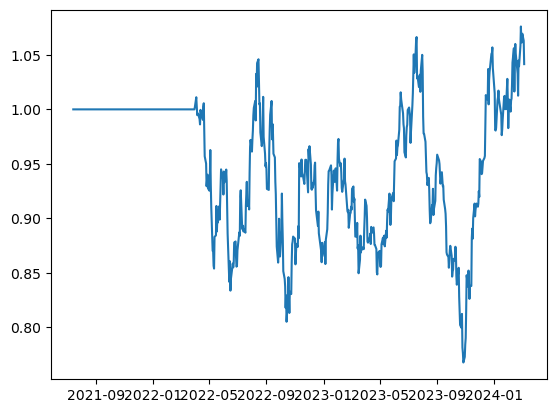

In [50]:
plt.plot(bt["nav"])
plt.show()

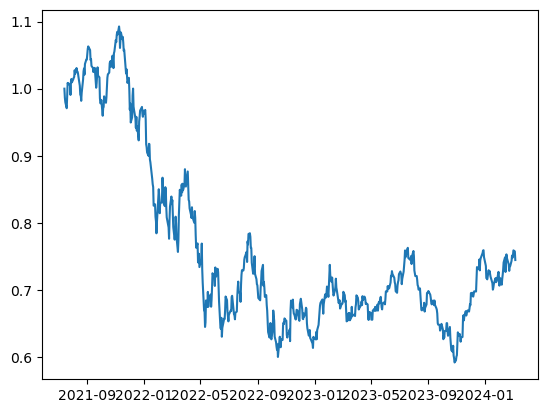

In [53]:
plt.plot(theme_close.mean(axis=1))
plt.show()

In [ ]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance)
# - Data: yfinance (Close, Volume)
# - Signals: Price (risk-adjusted momentum), Volume (attention), Flow-proxy (signed dollar flow)
# - Score: MMS-like (last 3m vs prev 3m; abs & pct changes; cross-sectional z; sum; re-z)
# - Add-ons:
#   (1) MSCI-like fallback to 3m risk-adjusted momentum
#   (2) Liquidity filter (ADTV in dollar volume)
#   (3) Risk targeting (daily RV estimate -> monthly fixed scaling)
# ============================================================

import numpy as np
import pandas as pd

# If you use yfinance:
import yfinance as yf

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],  # weak match but included
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None  # None -> today

TOP_K = 4
REBAL_FREQ = "Q"         # quarterly
EXEC_LAG_DAYS = 1        # execution lag (avoid look-ahead)
FEE_BPS = 10.0           # transaction cost bps per $ traded (simple)

# 3 months ~ 63 trading days
LB_3M = 63

# Liquidity filter: 3m avg dollar volume threshold
MIN_DV_3M = 3_000_000    # e.g. $3m/day; adjust for your universe

# Risk targeting: daily RV estimate -> monthly fixed scaling
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

EPS = 1e-12

# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def safe_div(a, b, eps=1e-12):
    return a / (np.abs(b) + eps)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

# ----------------------------
# 3) Download data from yfinance
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    # yfinance returns MultiIndex columns: ("Close","ARKQ") etc
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    # For multiple tickers, columns are MultiIndex with first level field
    # We need Close and Volume
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        # single ticker case
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume

# ----------------------------
# 4) Build theme-level daily returns & dollar volume
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    """
    Theme return: equal-weight across available component ETF returns each day.
    Theme dollar volume: sum of component dollar volumes.
    """
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        # equal-weight daily return across available components (renormalize if missing)
        r = etf_ret[cols]
        # renormalize: mean over non-NaN components
        tr = r.mean(axis=1, skipna=True)

        # dollar volume sum
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index)

    # fill dv missing with 0 (but liquidity filter will exclude)
    theme_dv = theme_dv.fillna(0.0)
    return theme_ret, theme_dv

# ----------------------------
# 5) MMS-like scoring at month-end
# ----------------------------
def compute_month_end_scores(theme_ret: pd.DataFrame,
                             theme_dv: pd.DataFrame,
                             lb_3m: int = LB_3M,
                             eps: float = EPS) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      score_m: month-end MMS-like score (winsorized & rounded)
      mom_m  : month-end 3m risk-adjusted momentum level (for fallback/tie)
    """
    idx = theme_ret.index
    themes = theme_ret.columns

    # signed dollar flow proxy
    sdf = np.sign(theme_ret).fillna(0.0) * theme_dv

    # month ends (use last trading day in each month)
    month_ends = theme_ret.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score = []
    rows_mom = []

    prev_rank = None

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                  # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)      # prev 3m

        # ---------- Price proxy: 3m risk-adjusted momentum (level) ----------
        # R over window, sigma of daily returns over window
        R0 = (1.0 + theme_ret.iloc[w0]).prod(axis=0) - 1.0
        S0 = theme_ret.iloc[w0].std(axis=0, ddof=0)
        mom0 = R0 / (S0 + eps)

        R1 = (1.0 + theme_ret.iloc[w1]).prod(axis=0) - 1.0
        S1 = theme_ret.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        # ---------- Volume proxy: avg dollar volume ----------
        dv0 = theme_dv.iloc[w0].mean(axis=0)
        dv1 = theme_dv.iloc[w1].mean(axis=0)

        # ---------- Flow proxy: avg signed dollar flow ----------
        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        # changes (MMS-like)
        mom_abs, mom_pct = change_abs_pct(mom0, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cross-sectional z
        cs = pd.DataFrame({
            "mom_abs": zscore_cs(mom_abs),
            "mom_pct": zscore_cs(mom_pct),
            "dv_abs":  zscore_cs(dv_abs),
            "dv_pct":  zscore_cs(dv_pct),
            "sdf_abs": zscore_cs(sdf_abs),
            "sdf_pct": zscore_cs(sdf_pct),
        })

        raw = cs.sum(axis=1)
        score = zscore_cs(raw)                  # re-z (MMS step)
        score = winsorize(score, 3.0).round(1)  # MSCI-like stabilize

        # tie-break by previous rank (if exists)
        if prev_rank is not None:
            rank_df = pd.DataFrame({"score": score, "prev": prev_rank.reindex(score.index)})
            rank_df["prev"] = rank_df["prev"].fillna(rank_df["prev"].max() + 1)
            rank_df = rank_df.sort_values(["score", "prev"], ascending=[False, True])
            score = score.reindex(rank_df.index)
            prev_rank = pd.Series(np.arange(1, len(score)+1), index=score.index)
        else:
            prev_rank = score.rank(ascending=False, method="first")

        rows_score.append(score.rename(t))
        rows_mom.append(mom0.rename(t))  # keep level for fallback

    score_m = pd.DataFrame(rows_score).sort_index()
    mom_m   = pd.DataFrame(rows_mom).sort_index()
    return score_m, mom_m

# ----------------------------
# 6) Liquidity filter + quarterly top-k selection + fallback
# ----------------------------
def build_quarterly_weights(score_m: pd.DataFrame,
                            mom_m: pd.DataFrame,
                            theme_dv: pd.DataFrame,
                            top_k: int = TOP_K,
                            lb_3m: int = LB_3M,
                            min_dv_3m: float = MIN_DV_3M) -> pd.DataFrame:
    """
    - Liquidity filter: 3m avg dollar volume must exceed min_dv_3m at decision time.
    - Fallback: if score unavailable/excluded, fill remaining slots by mom ranking.
    """
    # quarterly endpoints from month-end score
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom   = mom_m.reindex(q_end)

    # compute 3m avg dollar volume at those quarter-end dates using daily dv
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        if t not in idx:
            # align to previous trading day if necessary
            t0 = idx[idx.get_indexer([t], method="ffill")[0]]
        else:
            t0 = t
        loc = idx.get_loc(t0)
        if loc < lb_3m:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)

    for t in q_end:
        s = q_score.loc[t].copy()
        m = q_mom.loc[t].copy()
        dv_ok = dv3m_at_q.loc[t] >= min_dv_3m

        # apply liquidity filter
        s[~dv_ok] = np.nan
        m[~dv_ok] = np.nan

        # primary selection by score
        pick = []
        if s.notna().sum() > 0:
            pick = list(s.dropna().sort_values(ascending=False).head(top_k).index)

        # fallback: fill remaining by mom
        if len(pick) < top_k:
            cand = m.dropna().sort_values(ascending=False)
            for name in cand.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        # assign weights
        if len(pick) > 0:
            Wq.loc[t, pick] = 1.0 / len(pick)

    return Wq

# ----------------------------
# 7) Expand quarterly weights to daily and backtest
# ----------------------------
def expand_weights_daily(Wq: pd.DataFrame, daily_index: pd.DatetimeIndex, exec_lag_days: int = EXEC_LAG_DAYS) -> pd.DataFrame:
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)

    for t in Wq.index:
        # find next trading day (bfill)
        t0 = daily_index[daily_index.get_indexer([t], method="bfill")[0]]
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        apply_date = daily_index[apply_loc]
        Wd.loc[apply_date] = Wq.loc[t]

    Wd = Wd.ffill().fillna(0.0)
    return Wd

def apply_monthly_risk_targeting(port_gross_ret: pd.Series,
                                turnover: pd.Series,
                                fee_bps: float,
                                target_vol_ann: float = TARGET_VOL_ANN,
                                vol_lookback: int = VOL_LOOKBACK,
                                max_leverage: float = MAX_LEVERAGE) -> pd.DataFrame:
    """
    - Estimate daily realized vol (over vol_lookback) on unlevered gross returns.
    - At each month start, set leverage = target / rv (annualized), fixed within the month.
    - Costs scale with leverage (approx).
    """
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            # compute RV using previous vol_lookback days ending day-1
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                # insufficient history
                current_lev = 1.0
        lev.loc[d] = current_lev

    # scale both gross return and costs
    net = lev * port_gross_ret - lev * cost

    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest(theme_ret: pd.DataFrame, Wq: pd.DataFrame, exec_lag_days: int = EXEC_LAG_DAYS, fee_bps: float = FEE_BPS):
    rets = theme_ret.dropna(how="all").copy()
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)

    # gross portfolio return
    port_gross = (Wd * rets).sum(axis=1)

    # turnover (L1 change in weights)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)

    # risk targeting (monthly fixed scaling)
    bt = apply_monthly_risk_targeting(
        port_gross_ret=port_gross,
        turnover=turnover,
        fee_bps=fee_bps,
        target_vol_ann=TARGET_VOL_ANN,
        vol_lookback=VOL_LOOKBACK,
        max_leverage=MAX_LEVERAGE
    )
    return bt, Wd

# ----------------------------
# 8) Benchmark: equal-weight across all themes (same risk targeting optional)
# ----------------------------
def benchmark_equal_weight(theme_ret: pd.DataFrame, fee_bps: float = 0.0):
    rets = theme_ret.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)

    turnover = W.diff().abs().sum(axis=1).fillna(0.0)  # essentially 0 (constant)
    bt = apply_monthly_risk_targeting(
        port_gross_ret=gross,
        turnover=turnover,
        fee_bps=fee_bps,
        target_vol_ann=TARGET_VOL_ANN,
        vol_lookback=VOL_LOOKBACK,
        max_leverage=MAX_LEVERAGE
    )
    return bt

# ----------------------------
# 9) Run all
# ----------------------------
def run_all():
    # all ETFs
    all_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst})

    close, volume = download_ohlcv(all_etfs, start=START, end=END)
    theme_ret, theme_dv = build_theme_series(close, volume)

    # Month-end MMS-like score
    score_m, mom_m = compute_month_end_scores(theme_ret, theme_dv, lb_3m=LB_3M)

    # Quarterly weights with liquidity filter + fallback
    Wq = build_quarterly_weights(
        score_m=score_m,
        mom_m=mom_m,
        theme_dv=theme_dv,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M
    )

    # Backtest
    bt, Wd = backtest(theme_ret, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)

    # Benchmark (equal-weight across themes)
    bt_eqw = benchmark_equal_weight(theme_ret, fee_bps=0.0)

    
    # --- Summary stats ---
    def summarize(bt_df, name):
        r = bt_df["net_ret"]
        ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
        ann_vol = annualize_vol(r)
        sharpe = ann_ret / (ann_vol + 1e-12)
        mdd = max_drawdown(bt_df["nav"])
        avg_turn = float(bt_df["turnover"].mean())
        return pd.Series({
            "ann_ret": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "max_dd": mdd,
            "avg_turnover": avg_turn,
            "final_nav": float(bt_df["nav"].iloc[-1])
        }, name=name)

    summary = pd.concat([
        summarize(bt, "Strategy"),
        summarize(bt_eqw, "EQW(All Themes)")
    ], axis=1).T

    # selected themes each quarter
    picked = (Wq > 0).apply(lambda row: list(row.index[row.values].values), axis=1)
    picked = picked.rename("picked_themes")

    return {
        "close": close,
        "volume": volume,
        "theme_ret": theme_ret,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom_m": mom_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
        "summary": summary,
        "picked": picked
    }

# ----------------------------
# 10) Execute
# ----------------------------
if __name__ == "__main__":
    out = run_all()

    print("\n=== Summary ===")
    print(out["summary"])

    print("\n=== Last 10 selected quarters ===")
    print(out["picked"].tail(10))

    print("\n=== Strategy NAV tail ===")
    print(out["bt"][["nav", "leverage", "turnover", "cost"]].tail())



=== Summary ===
                  ann_ret   ann_vol    sharpe    max_dd  avg_turnover  \
Strategy         0.074289  0.114494  0.648846 -0.238355      0.013505   
EQW(All Themes)  0.071517  0.145337  0.492079 -0.265593      0.000000   

                 final_nav  
Strategy          2.371018  
EQW(All Themes)   2.298365  

=== Last 10 selected quarters ===
2023-09-30                                                   []
2023-12-31                                                   []
2024-03-31                                                   []
2024-06-30                                                   []
2024-09-30    [Autonomous Technology & Industrial Innovation...
2024-12-31    [Autonomous Technology & Industrial Innovation...
2025-03-31    [Genomic Innovation, Clean Energy Infrastructu...
2025-06-30    [Autonomous Technology & Industrial Innovation...
2025-09-30    [Efficient Energy, Genomic Innovation, Smart C...
2025-12-31    [Autonomous Technology & Industrial Innovation...
F

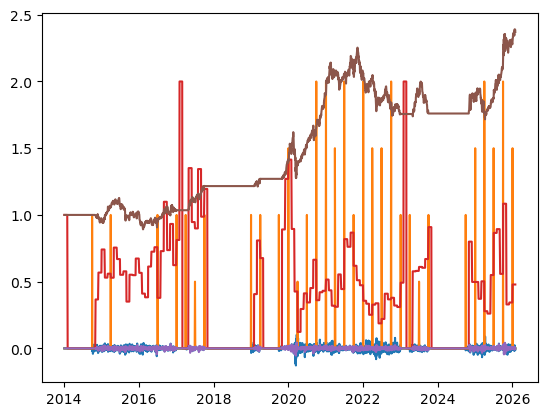

In [59]:
plt.plot(out["bt"])
plt.show()


1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                  ann_ret   ann_vol    sharpe    max_dd  avg_turnover  \
Strategy         0.064548  0.112832  0.572068 -0.264491      0.014328   
EQW(All Themes)  0.070859  0.143885  0.492469 -0.265594      0.000000   

                 final_nav  
Strategy          2.124592  
EQW(All Themes)   2.281400  

=== Last 10 selected quarters ===
2023-09-30                                                   []
2023-12-31                                                   []
2024-03-31                                                   []
2024-06-30                                                   []
2024-09-30    [Autonomous Technology & Industrial Innovation...
2024-12-31    [Autonomous Technology & Industrial Innovation...
2025-03-31    [Robotics, Clean Energy Infrastructure, Cybers...
2025-06-30    [Autonomous Technology & Industrial Innovation...
2025-09-30    [Efficient Energy, Smart Cities, Clean Energy ...
2025-12-31    [Genomic Innovation, Blockchain Economy, Renew...
F

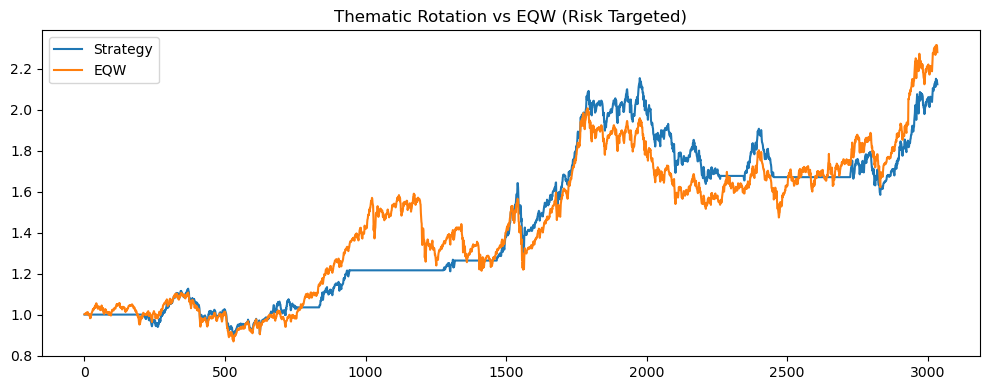

In [60]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL
# Data: yfinance (Close, Volume)
# Signals: (market-neutral) Price + Volume(attention) + Flow-proxy(demand pressure)
# Score: MMS-like (last 3m vs prev 3m; abs & pct; cs-z; sum; re-z)
# Add-ons:
#   - winsorize ±3 & round(0.1)
#   - execution lag to avoid look-ahead
#   - MSCI-like fallback to 3m risk-adjusted momentum
#   - liquidity filter via 3m avg dollar volume (ADTV proxy)
#   - market neutralization: rolling beta vs SPY -> residuals for signals
#   - risk targeting: daily RV -> monthly fixed leverage
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],  # weak match but included
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None  # None -> today

TOP_K = 4
REBAL_FREQ = "Q"           # quarterly
EXEC_LAG_DAYS = 1          # execution lag (avoid look-ahead)
FEE_BPS = 10.0             # cost bps per $ traded (simple)

# 3 months ~ 63 trading days
LB_3M = 63

# Liquidity filter: 3m avg dollar volume threshold
MIN_DV_3M = 3_000_000      # $/day; adjust

# Market neutralization
MKT_TICKER = "SPY"
BETA_WIN = 63              # rolling window for beta estimation
USE_INTERCEPT = True       # de-mean within window (approx intercept)

# Risk targeting: daily RV estimate -> monthly fixed scaling
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

PLOT = True
EPS = 1e-12

# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    # method: "ffill" or "bfill"
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

# ----------------------------
# 3) Download data from yfinance
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )

    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume

# ----------------------------
# 4) Build theme-level daily returns & dollar volume
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    """
    Theme return: equal-weight across component ETF returns each day (skip NaN).
    Theme dollar volume: sum of component dollar volumes.
    """
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        r = etf_ret[cols]
        tr = r.mean(axis=1, skipna=True)  # equal-weight daily return
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv

# ----------------------------
# 5) Market neutralization (rolling beta vs SPY)
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    """
    Compute rolling beta and return residual: r - beta * r_mkt - alpha (approx).
    We do it fast using rolling de-mean (intercept) + cov/var.

    Returns residual series aligned with theme_ret index.
    """
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            # alpha approx via rolling mean difference
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m

        out[c] = resid

    return out

# ----------------------------
# 6) MMS-like scoring at month-end
# ----------------------------
def compute_month_end_scores(ret_for_signals: pd.DataFrame,
                             theme_dv: pd.DataFrame,
                             lb_3m: int = LB_3M,
                             eps: float = EPS) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    - ret_for_signals: the return series used for signals (market-neutral residuals recommended)
    - theme_dv: dollar volume (not neutralized)
    Returns:
      score_m: month-end MMS-like score (winsorized & rounded)
      mom_m  : month-end 3m risk-adjusted momentum level (for fallback)
    """
    idx = ret_for_signals.index

    # signed dollar flow proxy: sign(residual return) * dollar volume
    sdf = np.sign(ret_for_signals).fillna(0.0) * theme_dv.reindex(idx).fillna(0.0)

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score = []
    rows_mom = []
    prev_rank = None

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                  # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)      # prev 3m

        # --- Price proxy: 3m risk-adjusted momentum (level) ---
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom0 = R0 / (S0 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        # --- Volume proxy: avg dollar volume ---
        dv0 = theme_dv.iloc[w0].mean(axis=0)
        dv1 = theme_dv.iloc[w1].mean(axis=0)

        # --- Flow proxy: avg signed dollar flow (resid-sign) ---
        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom0, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        cs = pd.DataFrame({
            "mom_abs": zscore_cs(mom_abs),
            "mom_pct": zscore_cs(mom_pct),
            "dv_abs":  zscore_cs(dv_abs),
            "dv_pct":  zscore_cs(dv_pct),
            "sdf_abs": zscore_cs(sdf_abs),
            "sdf_pct": zscore_cs(sdf_pct),
        })

        raw = cs.sum(axis=1)
        score = zscore_cs(raw)                  # MMS re-standardize
        score = winsorize(score, 3.0).round(1)  # winsorize ±3 + 0.1 rounding

        # tie-break by previous rank (if any)
        if prev_rank is not None:
            rank_df = pd.DataFrame({"score": score, "prev": prev_rank.reindex(score.index)})
            rank_df["prev"] = rank_df["prev"].fillna(rank_df["prev"].max() + 1)
            rank_df = rank_df.sort_values(["score", "prev"], ascending=[False, True])
            score = score.reindex(rank_df.index)
            prev_rank = pd.Series(np.arange(1, len(score)+1), index=score.index)
        else:
            prev_rank = score.rank(ascending=False, method="first")

        rows_score.append(score.rename(t))
        rows_mom.append(mom0.rename(t))  # fallback uses level

    score_m = pd.DataFrame(rows_score).sort_index()
    mom_m   = pd.DataFrame(rows_mom).sort_index()
    return score_m, mom_m

# ----------------------------
# 7) Liquidity filter + quarterly selection + fallback
# ----------------------------
def build_quarterly_weights(score_m: pd.DataFrame,
                            mom_m: pd.DataFrame,
                            theme_dv: pd.DataFrame,
                            top_k: int = TOP_K,
                            lb_3m: int = LB_3M,
                            min_dv_3m: float = MIN_DV_3M) -> pd.DataFrame:
    """
    - Liquidity filter: 3m avg dollar volume >= min_dv_3m at decision time.
    - Primary: choose by score
    - Fallback: fill remaining by mom ranking (MSCI-like)
    """
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom   = mom_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m

    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)

    for t in q_end:
        s = q_score.loc[t].copy()
        m = q_mom.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m[~dv_ok] = np.nan

        pick = []
        if s.notna().sum() > 0:
            pick = list(s.dropna().sort_values(ascending=False).head(top_k).index)

        # fallback via mom
        if len(pick) < top_k:
            cand = m.dropna().sort_values(ascending=False)
            for name in cand.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) > 0:
            Wq.loc[t, pick] = 1.0 / len(pick)

    return Wq

# ----------------------------
# 8) Expand weights to daily (execution lag) and compute gross return
# ----------------------------
def expand_weights_daily(Wq: pd.DataFrame, daily_index: pd.DatetimeIndex, exec_lag_days: int = EXEC_LAG_DAYS) -> pd.DataFrame:
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        apply_date = daily_index[apply_loc]
        Wd.loc[apply_date] = Wq.loc[t]
    return Wd.ffill().fillna(0.0)

# ----------------------------
# 9) Risk targeting (monthly fixed scaling)
# ----------------------------
def apply_monthly_risk_targeting(port_gross_ret: pd.Series,
                                turnover: pd.Series,
                                fee_bps: float,
                                target_vol_ann: float = TARGET_VOL_ANN,
                                vol_lookback: int = VOL_LOOKBACK,
                                max_leverage: float = MAX_LEVERAGE) -> pd.DataFrame:
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost

    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

# ----------------------------
# 10) Backtest strategy & benchmark
# ----------------------------
def backtest_strategy(theme_ret_trade: pd.DataFrame,
                      Wq: pd.DataFrame,
                      exec_lag_days: int = EXEC_LAG_DAYS,
                      fee_bps: float = FEE_BPS) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    theme_ret_trade: actual tradable theme returns (NOT neutralized).
    """
    rets = theme_ret_trade.dropna(how="all").copy()
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)

    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)

    bt = apply_monthly_risk_targeting(
        port_gross_ret=port_gross,
        turnover=turnover,
        fee_bps=fee_bps,
        target_vol_ann=TARGET_VOL_ANN,
        vol_lookback=VOL_LOOKBACK,
        max_leverage=MAX_LEVERAGE
    )
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade: pd.DataFrame) -> pd.DataFrame:
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)

    bt = apply_monthly_risk_targeting(
        port_gross_ret=gross,
        turnover=turnover,
        fee_bps=0.0,
        target_vol_ann=TARGET_VOL_ANN,
        vol_lookback=VOL_LOOKBACK,
        max_leverage=MAX_LEVERAGE
    )
    return bt

# ----------------------------
# 11) Run all
# ----------------------------
def run_all():
    # all ETF tickers used by themes + SPY for market
    all_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst} | {MKT_TICKER})

    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # split out market series
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # build theme series from ETFs (exclude SPY in theme build)
    close_etf = close.drop(columns=[MKT_TICKER], errors="ignore")
    vol_etf   = volume.drop(columns=[MKT_TICKER], errors="ignore")

    theme_ret_trade, theme_dv = build_theme_series(close_etf, vol_etf)

    # market-neutral returns for signals
    theme_ret_neut = neutralize_by_market(
        theme_ret=theme_ret_trade,
        mkt_ret=mkt_ret,
        win=BETA_WIN,
        use_intercept=USE_INTERCEPT
    )

    # month-end MMS-like scores computed from neutralized returns (signals),
    # while dollar volume remains raw (attention / demand proxy).
    score_m, mom_m = compute_month_end_scores(
        ret_for_signals=theme_ret_neut,
        theme_dv=theme_dv,
        lb_3m=LB_3M
    )

    # quarterly weights with liquidity filter + fallback
    Wq = build_quarterly_weights(
        score_m=score_m,
        mom_m=mom_m,
        theme_dv=theme_dv,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M
    )

    # backtest on tradable returns (not neutralized)
    bt, Wd = backtest_strategy(
        theme_ret_trade=theme_ret_trade,
        Wq=Wq,
        exec_lag_days=EXEC_LAG_DAYS,
        fee_bps=FEE_BPS
    )

    # benchmark
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    # summary
    def summarize(bt_df, name):
        r = bt_df["net_ret"].dropna()
        ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
        ann_vol = annualize_vol(r)
        sharpe = ann_ret / (ann_vol + 1e-12)
        mdd = max_drawdown(bt_df["nav"])
        avg_turn = float(bt_df["turnover"].mean())
        return pd.Series({
            "ann_ret": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "max_dd": mdd,
            "avg_turnover": avg_turn,
            "final_nav": float(bt_df["nav"].iloc[-1])
        }, name=name)

    summary = pd.concat([
        summarize(bt, "Strategy"),
        summarize(bt_eqw, "EQW(All Themes)")
    ], axis=1).T

    # selected themes each quarter
    picked = (Wq > 0).apply(lambda row: list(row.index[row.values].values), axis=1)
    picked = picked.rename("picked_themes")

    out = {
        "close": close_etf,
        "volume": vol_etf,
        "theme_ret_trade": theme_ret_trade,
        "theme_ret_neut": theme_ret_neut,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom_m": mom_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
        "summary": summary,
        "picked": picked
    }
    return out

# ----------------------------
# 12) Plot helper
# ----------------------------
def plot_nav(bt, bt_eqw, title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt["nav"].values, label="Strategy")
    plt.plot(bt_eqw["nav"].values, label="EQW")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------
# 13) Execute
# ----------------------------
if __name__ == "__main__":
    out = run_all()

    print("\n=== Summary ===")
    print(out["summary"])

    print("\n=== Last 10 selected quarters ===")
    print(out["picked"].tail(10))

    if PLOT:
        plot_nav(out["bt"], out["bt_eqw"], title="Thematic Rotation vs EQW (Risk Targeted)")



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                  ann_ret   ann_vol    sharpe    max_dd  \
Strategy (Neutralized signals)   0.064548  0.112832  0.572069 -0.264491   
Strategy (Raw signals)           0.073428  0.114810  0.639555 -0.238355   
EQW (All themes; same universe)  0.070859  0.143884  0.492469 -0.265593   

                                 avg_turnover  final_nav  
Strategy (Neutralized signals)       0.014328   2.124594  
Strategy (Raw signals)               0.013011   2.348219  
EQW (All themes; same universe)      0.000000   2.281402  


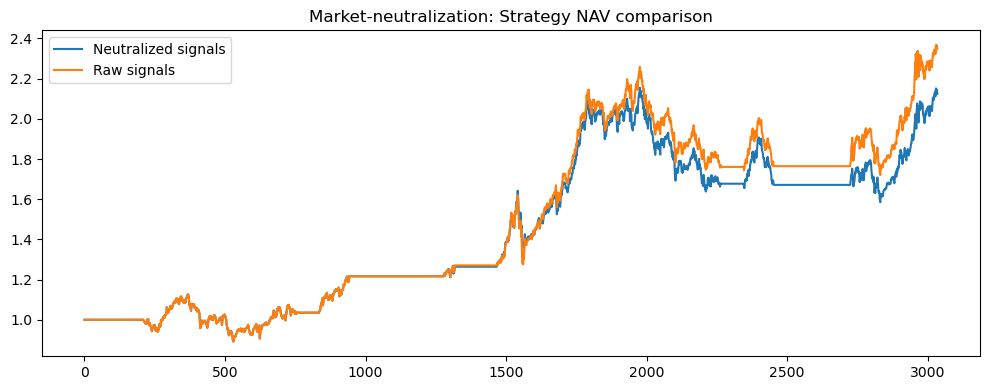

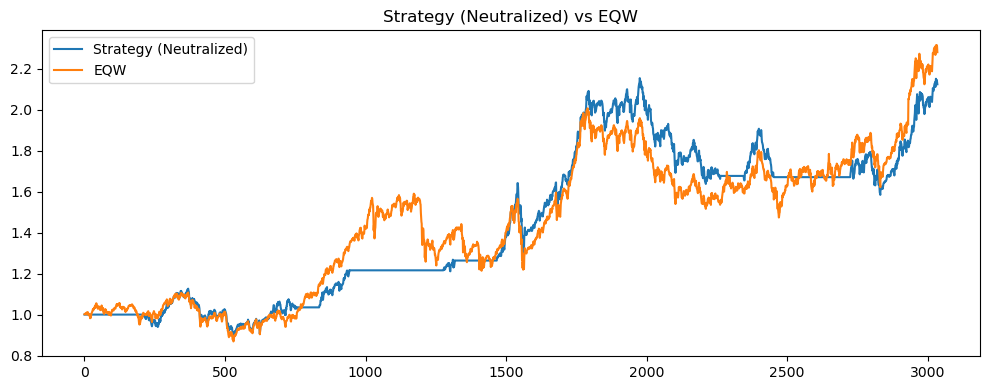

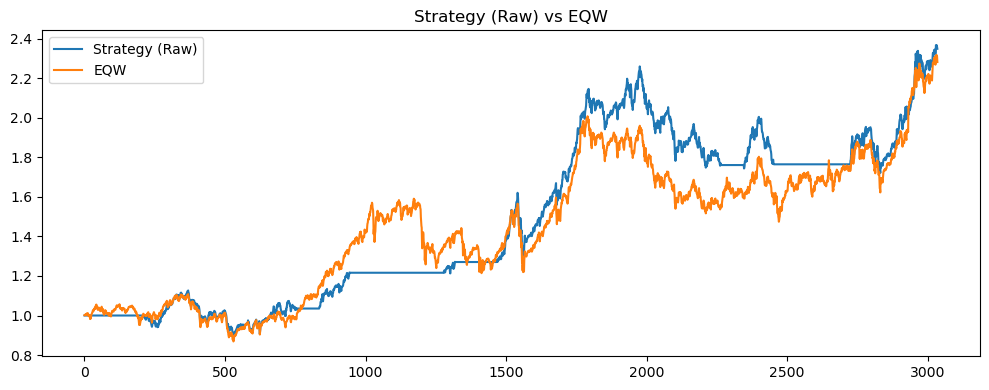

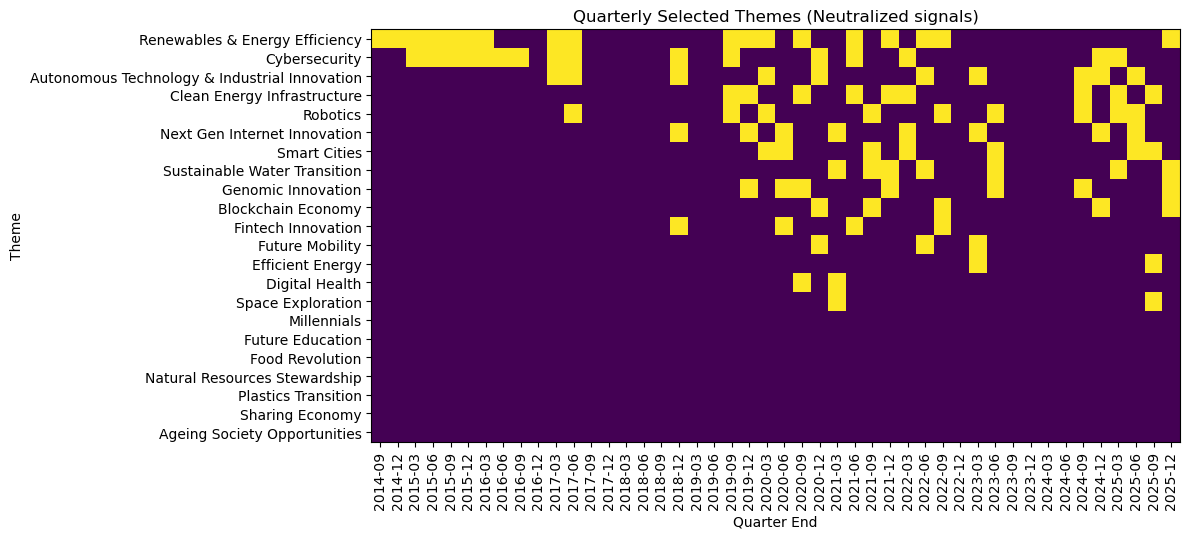

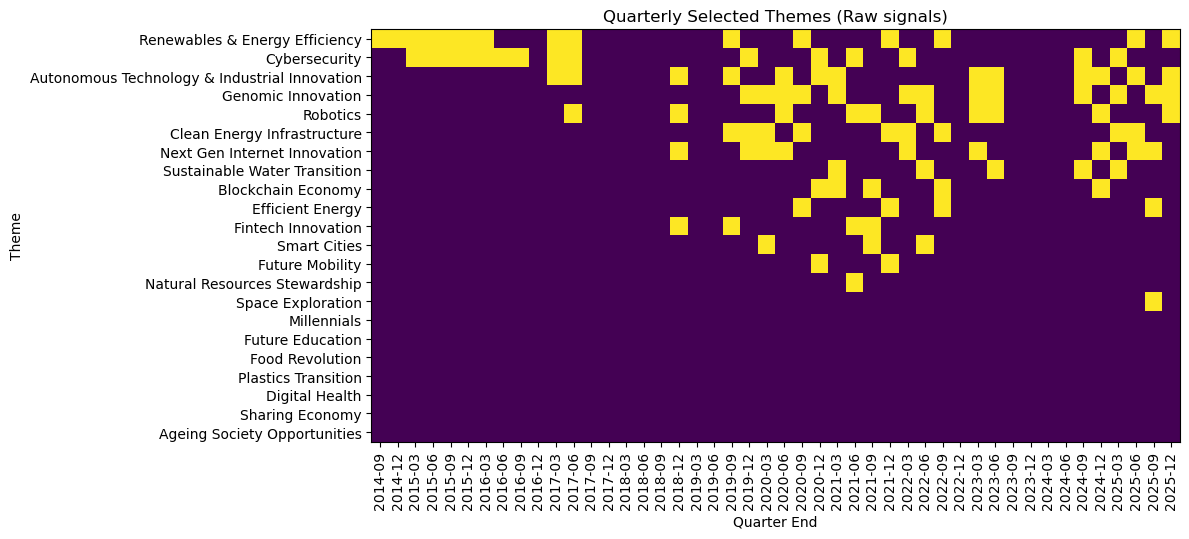

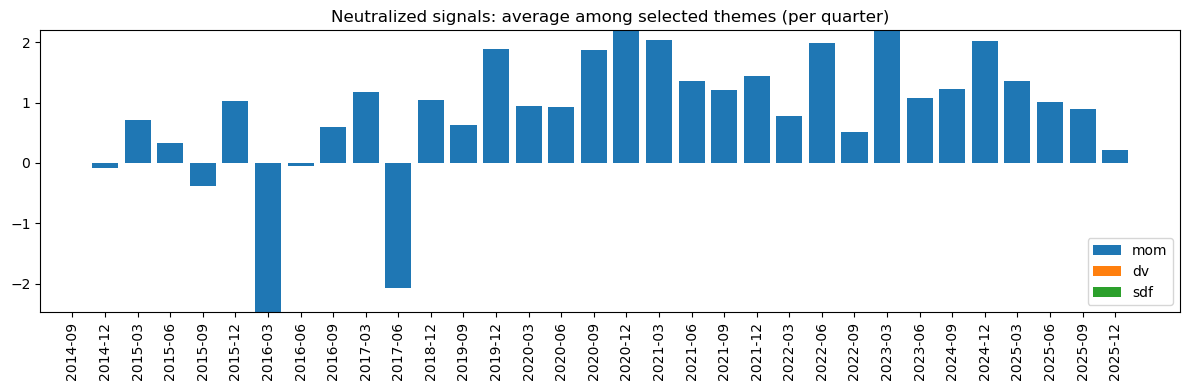

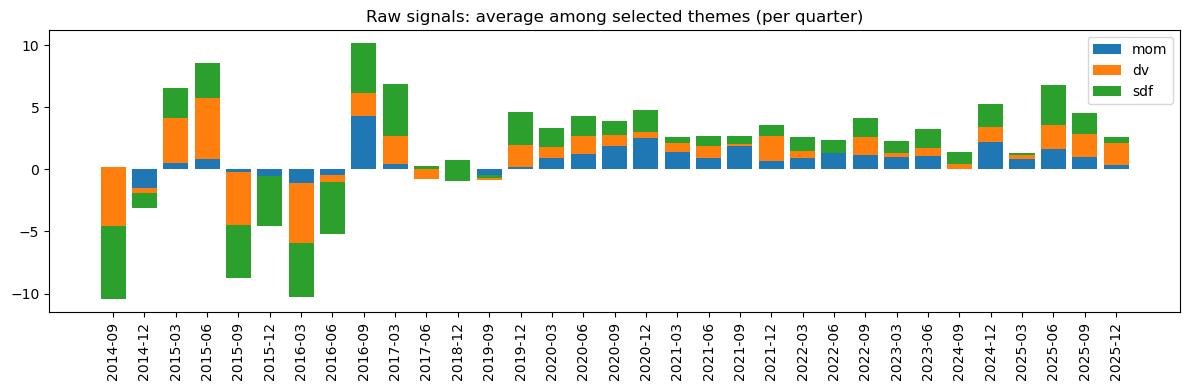

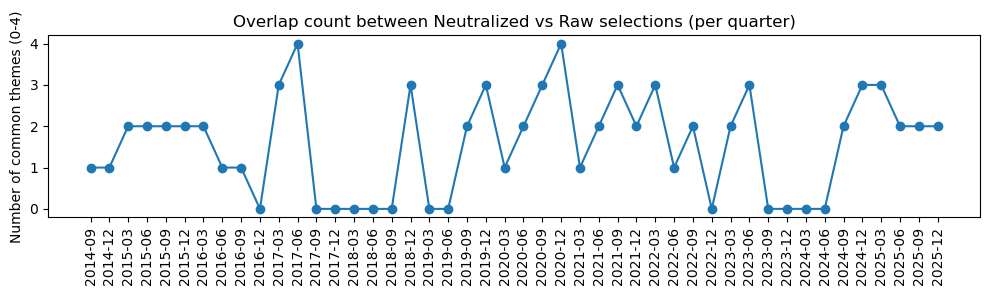

In [61]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#
# Data: yfinance (Close, Volume)
# Signals:
#   - mom: 3m risk-adjusted momentum (changes last 3m vs prev 3m)
#   - dv : dollar-volume attention (changes)
#   - sdf: signed dollar-flow proxy (changes; sign from signal returns)
# Score: MMS-like -> cs-z per component -> sum -> re-z -> winsorize±3 -> round(0.1)
# Add-ons:
#   - execution lag
#   - liquidity filter (3m avg dollar volume)
#   - fallback to mom ranking
#   - risk targeting (daily RV -> monthly fixed leverage)
#   - optional market neutralization (rolling beta vs SPY)
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],  # weak match but included
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "Q"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63

MIN_DV_3M = 3_000_000  # $/day; adjust

# market neutralization
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# risk targeting
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

PLOT = True
EPS = 1e-12

# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume

# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)  # theme return = equal-weight components
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv

# ----------------------------
# 5) Market neutralization
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out

# ----------------------------
# 6) MMS-like scores + decomposition
# ----------------------------
def compute_month_end_scores_with_decomp(
    ret_for_signals: pd.DataFrame,  # residuals if neutralized else raw returns
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    """
    Returns:
      score_m: month-end final score (winsorized+rounded)
      mom_m  : month-end mom level (fallback)
      comp_m : month-end component contributions (mom/dv/sdf) AFTER cs-z & (abs+pct) summation:
               columns: [mom, dv, sdf, raw_sum, score_final]
    """
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv  # demand/flow proxy

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score = []
    rows_mom = []
    rows_comp = []

    prev_rank = None

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                  # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)      # prev 3m

        # mom: 3m risk-adjusted momentum level in each window
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom0 = R0 / (S0 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        # dv: attention proxy
        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        # sdf: demand proxy
        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom0, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cs-z each
        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        # component contributions (post z and sum abs+pct)
        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)                 # re-z (MMS step)
        score = winsorize(score, 3.0).round(1)

        # tie-break by previous rank (optional; affects ordering, not values)
        if prev_rank is not None:
            rank_df = pd.DataFrame({"score": score, "prev": prev_rank.reindex(score.index)})
            rank_df["prev"] = rank_df["prev"].fillna(rank_df["prev"].max() + 1)
            rank_df = rank_df.sort_values(["score", "prev"], ascending=[False, True])
            score = score.reindex(rank_df.index)
            # keep prev rank updated with current ordering
            prev_rank = pd.Series(np.arange(1, len(score)+1), index=score.index)
        else:
            prev_rank = score.rank(ascending=False, method="first")

        rows_score.append(score.rename(t))
        rows_mom.append(mom0.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom_m   = pd.DataFrame(rows_mom).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom_m, comp_m

# ----------------------------
# 7) Liquidity filter + quarterly top-k + fallback
# ----------------------------
def build_quarterly_weights(score_m, mom_m, theme_dv, top_k=TOP_K, lb_3m=LB_3M, min_dv_3m=MIN_DV_3M):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom   = mom_m.reindex(q_end)

    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)

    for t in q_end:
        s = q_score.loc[t].copy()
        m = q_mom.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m[~dv_ok] = np.nan

        pick = []
        if s.notna().sum() > 0:
            pick = list(s.dropna().sort_values(ascending=False).head(top_k).index)

        if len(pick) < top_k:
            cand = m.dropna().sort_values(ascending=False)
            for name in cand.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) > 0:
            Wq.loc[t, pick] = 1.0 / len(pick)

    return Wq

# ----------------------------
# 8) Expand weights + backtest + risk targeting
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting(port_gross_ret, turnover, fee_bps,
                                target_vol_ann=TARGET_VOL_ANN, vol_lookback=VOL_LOOKBACK, max_leverage=MAX_LEVERAGE):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(gross, turnover, fee_bps=0.0)
    return bt

# ----------------------------
# 9) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    # binary selection matrix [quarter x theme]
    sel = (Wq > 0).astype(int)

    # order themes by total selected count (more selected on top)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]

    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    im = ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")  # no explicit colors
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    """
    comp_m: MultiIndex (date, theme) with columns [mom,dv,sdf,raw_sum,score_final]
    Wq: quarterly weights (date=quarter end)
    mode:
      - "avg_selected": for each quarter, average contributions among selected themes
      - "all_selected": bar for each selected theme per quarter (can get busy)
    """
    q_end = Wq.index
    # comp_m is month-end dates; align by taking the same quarter-end month-end comp if available
    # We'll map each quarter-end t -> comp at that exact date (month-end). If missing, ffill month-end.
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        # find comp date <= t (ffill) in month-end space
        t_comp = comp_dates[comp_dates.get_indexer([t], method="ffill")[0]] if len(comp_dates)>0 else None
        if t_comp is None:
            continue

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            # each theme as separate row
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        # stacked bars WITHOUT specifying colors
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        # "all_selected" can be large; simple per-quarter grouped bars
        # Recommend using avg_selected first.
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        df = df.sort_values(["date","theme"])
        # no plotting here by default
        return df

# ----------------------------
# 10) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool):
    all_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst} | {MKT_TICKER})

    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes (exclude SPY)
    close_etf = close.drop(columns=[MKT_TICKER], errors="ignore")
    vol_etf   = volume.drop(columns=[MKT_TICKER], errors="ignore")

    theme_ret_trade, theme_dv = build_theme_series(close_etf, vol_etf)

    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    score_m, mom_m, comp_m = compute_month_end_scores_with_decomp(ret_for_signals, theme_dv, lb_3m=LB_3M)

    Wq = build_quarterly_weights(score_m, mom_m, theme_dv, top_k=TOP_K, lb_3m=LB_3M, min_dv_3m=MIN_DV_3M)

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)

    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom_m": mom_m,
        "comp_m": comp_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
    ann_vol = annualize_vol(r)
    sharpe = ann_ret / (ann_vol + 1e-12)
    mdd = max_drawdown(bt_df["nav"])
    avg_turn = float(bt_df["turnover"].mean())
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1])
    }, name=name)

# ----------------------------
# 11) Execute
# ----------------------------
if __name__ == "__main__":
    # Run BOTH
    out_neut = run_pipeline(use_neutralization=True)
    out_raw  = run_pipeline(use_neutralization=False)

    # Summaries (strategy vs EQW) for both variants
    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes; same universe)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    if PLOT:
        # (C) Market-neutral vs non-neutral NAV comparison
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        # Also compare each vs EQW (optional)
        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        # (A) Quarterly selection heatmap (neutralized version shown; raw also possible)
        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        # (B) Score decomposition (average over selected themes per quarter)
        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        # Optional: show how often selections differ
        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                                    ann_ret   ann_vol  \
Strategy (Neutralized signals; optimized weights)  0.064548  0.112832   
Strategy (Raw signals; optimized weights)          0.073428  0.114810   
EQW (All themes)                                   0.070859  0.143885   

                                                     sharpe    max_dd  \
Strategy (Neutralized signals; optimized weights)  0.572067 -0.264491   
Strategy (Raw signals; optimized weights)          0.639555 -0.238356   
EQW (All themes)                                   0.492469 -0.265593   

                                                   avg_turnover  final_nav  
Strategy (Neutralized signals; optimized weights)      0.014328   2.124591  
Strategy (Raw signals; optimized weights)              0.013011   2.348217  
EQW (All themes)                                       0.000000   2.281400  


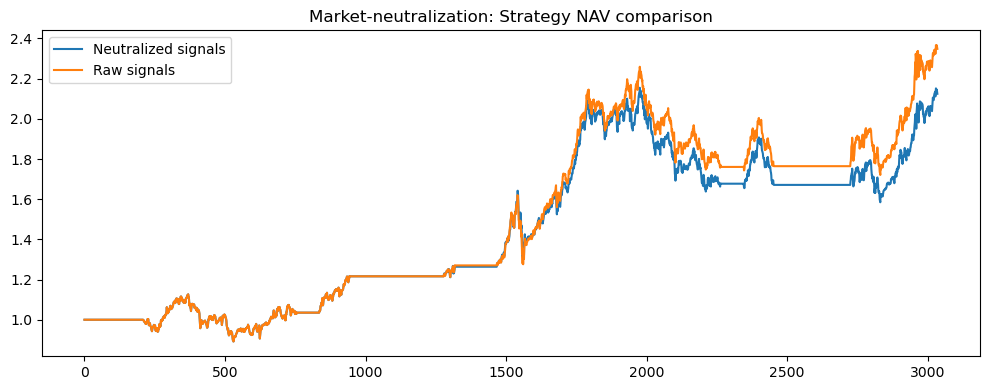

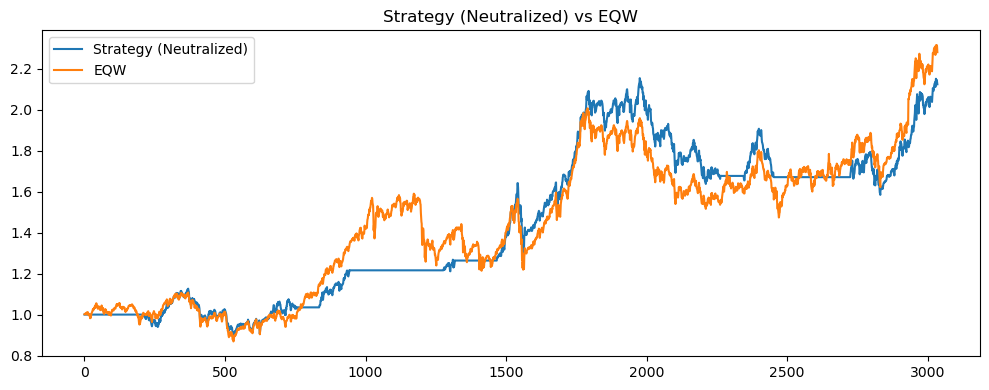

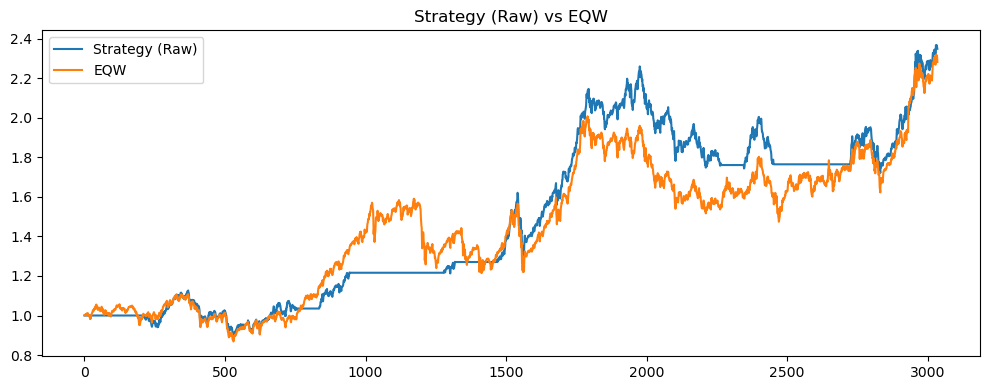

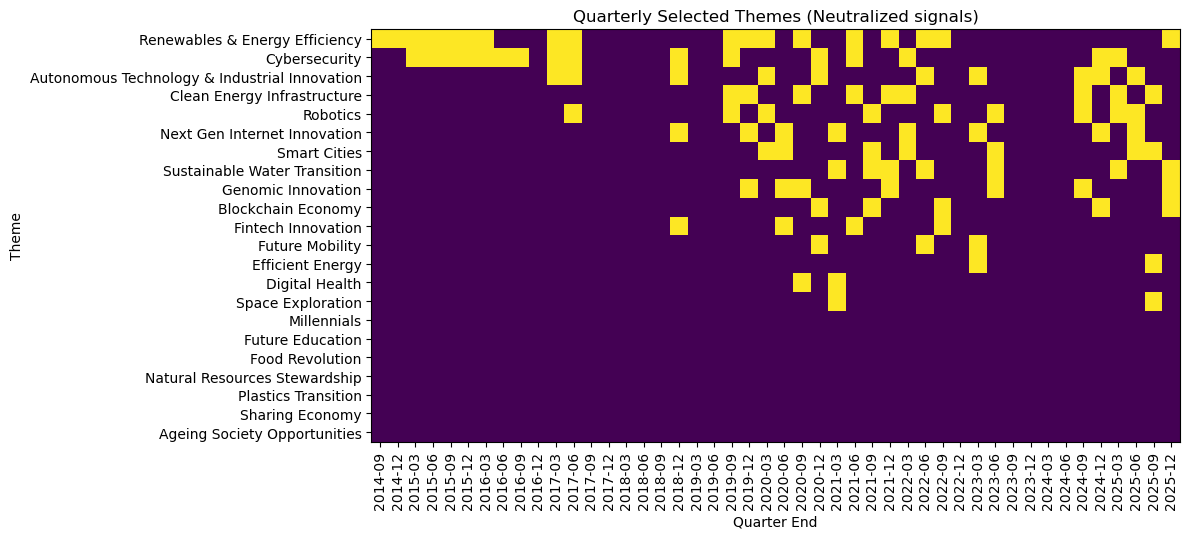

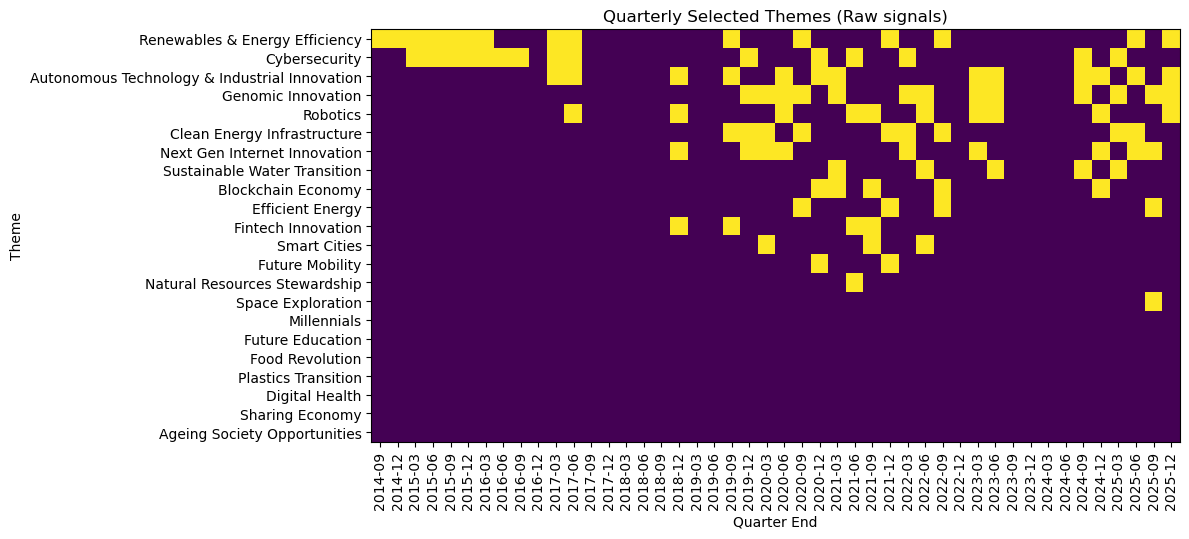

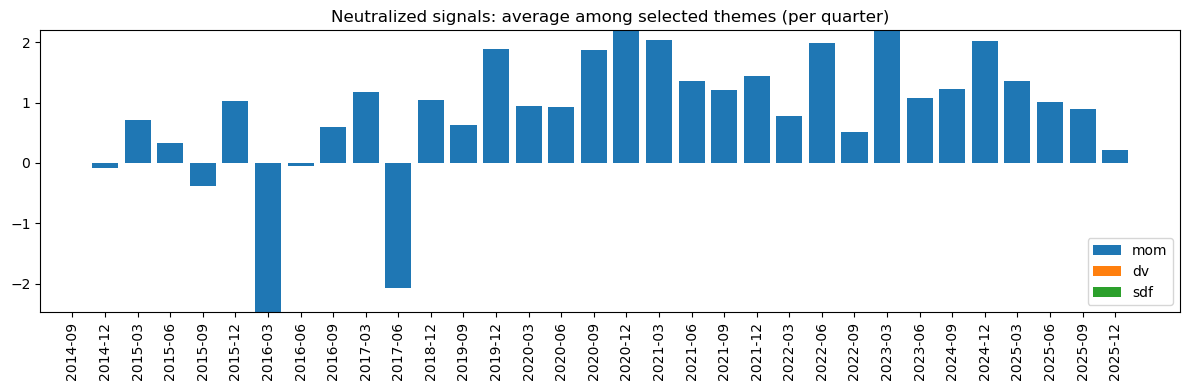

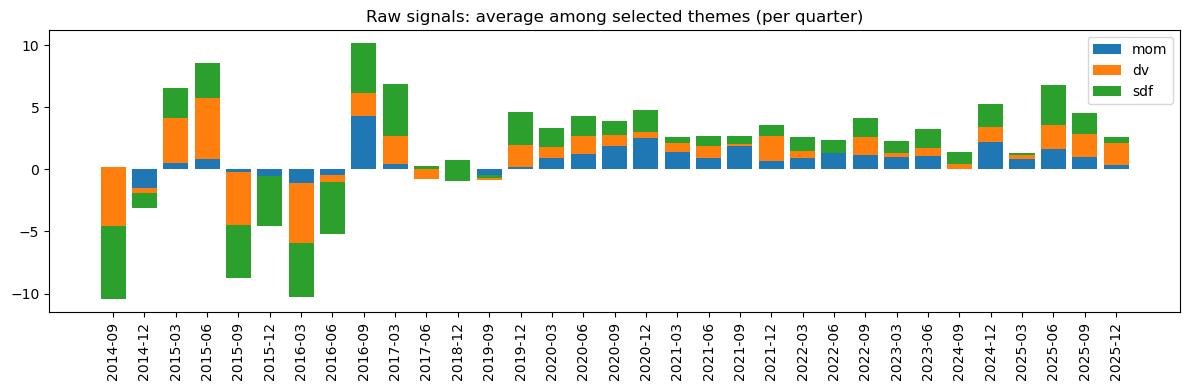

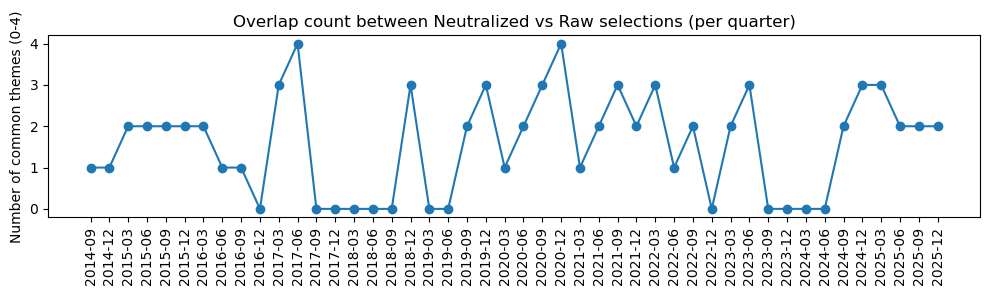

In [62]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#   (D) MSCI-like "2nd stage optimizer" for weights within selected themes
#
# Data: yfinance (Close, Volume)
# Signals:
#   - mom: 3m risk-adjusted momentum (changes last 3m vs prev 3m)
#   - dv : dollar-volume attention (changes)
#   - sdf: signed dollar-flow proxy (changes; sign from signal returns)
# Score: MMS-like -> cs-z per component -> sum -> re-z -> winsorize±3 -> round(0.1)
# Add-ons:
#   - execution lag
#   - liquidity filter (3m avg dollar volume)
#   - fallback to mom ranking
#   - risk targeting (daily RV -> monthly fixed leverage)
#   - optional market neutralization (rolling beta vs SPY)
#   - NEW: optimization of weights (score max - risk - turnover) within selected set
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "Q"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63
MIN_DV_3M = 3_000_000  # $/day; adjust

# market neutralization
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# risk targeting (portfolio-level)
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

# ---- NEW: optimizer controls (MSCI-like 2nd stage) ----
USE_WEIGHT_OPTIMIZER = True   # <- switch on/off
W_MAX = 0.25                  # cap per selected theme; 0.25 ~ "equal 4 themes"
COV_WIN = 63                  # covariance lookback (days)
COV_SHRINK = 0.10             # shrinkage toward diagonal to stabilize
GAMMA_RISK = 10.0             # risk penalty strength (increase => more conservative)
LAMBDA_TURN = 1.0             # turnover penalty (L2) strength
GD_STEPS = 250                # fallback solver iterations
GD_LR = 0.05                  # fallback solver learning rate
EPS = 1e-12

PLOT = True


# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

def project_to_capped_simplex(v: np.ndarray, z: float = 1.0, ub: float = 1.0) -> np.ndarray:
    """
    Projection onto {w: sum w = z, 0<=w<=ub}. Uses bisection on tau:
      w = clip(v - tau, 0, ub), find tau s.t. sum w = z.
    Always returns feasible vector (if ub*z feasible).
    """
    v = np.asarray(v, float).ravel()
    n = v.size
    ub = float(ub)

    # feasibility: require z <= n*ub
    if z > n * ub + 1e-12:
        # if infeasible, spread at ub then renormalize (best effort)
        w = np.ones(n) * ub
        return w / w.sum() * z

    lo = v.min() - ub
    hi = v.max()

    for _ in range(80):
        tau = 0.5 * (lo + hi)
        w = np.clip(v - tau, 0.0, ub)
        s = w.sum()
        if s > z:
            lo = tau
        else:
            hi = tau

    w = np.clip(v - 0.5 * (lo + hi), 0.0, ub)
    s = w.sum()
    if s <= 0:
        # fallback: uniform capped
        k = int(np.floor(z / ub))
        w = np.zeros(n)
        if k > 0:
            w[:k] = ub
        rem = z - w.sum()
        if rem > 0 and k < n:
            w[k] = min(ub, rem)
        return w
    return w * (z / s)

def shrink_cov(S: np.ndarray, shrink: float = 0.1, eps: float = 1e-8) -> np.ndarray:
    S = np.asarray(S, float)
    D = np.diag(np.diag(S))
    out = (1.0 - shrink) * S + shrink * D
    out = out + eps * np.eye(out.shape[0])
    return out

# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume

# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)  # theme return = equal-weight components
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv

# ----------------------------
# 5) Market neutralization
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out

# ----------------------------
# 6) MMS-like scores + decomposition
# ----------------------------
def compute_month_end_scores_with_decomp(
    ret_for_signals: pd.DataFrame,
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv  # demand/flow proxy

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score, rows_mom, rows_comp = [], [], []
    prev_rank = None

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)

        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom0 = R0 / (S0 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom0, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)
        score = winsorize(score, 3.0).round(1)

        if prev_rank is not None:
            rank_df = pd.DataFrame({"score": score, "prev": prev_rank.reindex(score.index)})
            rank_df["prev"] = rank_df["prev"].fillna(rank_df["prev"].max() + 1)
            rank_df = rank_df.sort_values(["score", "prev"], ascending=[False, True])
            score = score.reindex(rank_df.index)
            prev_rank = pd.Series(np.arange(1, len(score)+1), index=score.index)
        else:
            prev_rank = score.rank(ascending=False, method="first")

        rows_score.append(score.rename(t))
        rows_mom.append(mom0.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom_m   = pd.DataFrame(rows_mom).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom_m, comp_m

# ----------------------------
# 7) NEW: Weight optimizer within selected themes
# ----------------------------
def optimize_weights_within_selected(
    score_vec: pd.Series,
    cov_mat: np.ndarray,
    w_prev: np.ndarray,
    w_max: float = 0.25,
    gamma_risk: float = 10.0,
    lambda_turn: float = 1.0,
    use_scipy: bool = True
) -> np.ndarray:
    """
    maximize score·w - gamma*(w' Σ w) - lambda*||w-w_prev||^2
    s.t. sum(w)=1, 0<=w<=w_max
    """

    s = np.asarray(score_vec.values, float)
    n = s.size
    Sigma = np.asarray(cov_mat, float)
    w_prev = np.asarray(w_prev, float).ravel()
    if w_prev.size != n:
        w_prev = np.ones(n) / n

    # initial guess: project prev onto capped simplex
    w0 = project_to_capped_simplex(w_prev, z=1.0, ub=w_max)

    # Try scipy SLSQP; fallback to projected GD
    if use_scipy:
        try:
            from scipy.optimize import minimize

            def obj(w):
                w = np.asarray(w)
                ret_term = -np.dot(s, w)
                risk_term = gamma_risk * float(w @ Sigma @ w)
                turn_term = lambda_turn * float(np.sum((w - w_prev) ** 2))
                return ret_term + risk_term + turn_term

            def grad(w):
                w = np.asarray(w)
                g = -s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev)
                return g

            cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0, "jac": lambda w: np.ones_like(w)}]
            bnds = [(0.0, w_max) for _ in range(n)]

            res = minimize(
                obj, w0, jac=grad, method="SLSQP",
                bounds=bnds, constraints=cons,
                options={"maxiter": 200, "ftol": 1e-12, "disp": False}
            )
            w = np.asarray(res.x, float)
            w = project_to_capped_simplex(w, z=1.0, ub=w_max)
            return w
        except Exception:
            pass

    # Fallback: projected gradient descent
    w = w0.copy()
    for _ in range(GD_STEPS):
        g = -s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev)
        w = w - GD_LR * g
        w = project_to_capped_simplex(w, z=1.0, ub=w_max)
    return w

def compute_cov_at_date(theme_ret_trade: pd.DataFrame, t: pd.Timestamp, win: int = 63) -> pd.DataFrame:
    """
    Rolling sample covariance of theme returns up to time t (ffill to trading date),
    using last `win` observations.
    """
    idx = theme_ret_trade.index
    t0 = safe_get_loc(idx, t, method="ffill")
    if t0 is None:
        return None
    loc = idx.get_loc(t0)
    if loc < win:
        return None
    X = theme_ret_trade.iloc[loc - win + 1: loc + 1]
    # drop themes with all NaN in window
    X = X.dropna(axis=1, how="all").fillna(0.0)
    if X.shape[1] < 2:
        return None
    S = X.cov(ddof=0)
    return S

# ----------------------------
# 8) Liquidity filter + quarterly top-k + fallback + (NEW) optimizer
# ----------------------------
def build_quarterly_weights(
    score_m,
    mom_m,
    theme_dv,
    theme_ret_trade,             # NEW: for covariance estimation
    top_k=TOP_K,
    lb_3m=LB_3M,
    min_dv_3m=MIN_DV_3M,
    use_optimizer: bool = True,
    w_max: float = W_MAX,
    cov_win: int = COV_WIN,
    cov_shrink: float = COV_SHRINK,
    gamma_risk: float = GAMMA_RISK,
    lambda_turn: float = LAMBDA_TURN
):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom   = mom_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends for liquidity
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)

    # previous quarter weights (for turnover penalty)
    w_prev_full = np.zeros(Wq.shape[1], dtype=float)  # aligned with Wq.columns

    for t in q_end:
        s = q_score.loc[t].copy()
        m = q_mom.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m[~dv_ok] = np.nan

        # ---- step1: pick top_k themes (same as before) ----
        pick = []
        if s.notna().sum() > 0:
            pick = list(s.dropna().sort_values(ascending=False).head(top_k).index)

        if len(pick) < top_k:
            cand = m.dropna().sort_values(ascending=False)
            for name in cand.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) == 0:
            continue

        # ---- step2: assign weights ----
        if (not use_optimizer) or (len(pick) == 1):
            # equal within selected
            Wq.loc[t, pick] = 1.0 / len(pick)
        else:
            # optimizer only over selected subset
            score_vec = s.reindex(pick).fillna(0.0)

            # covariance from tradable theme returns
            S = compute_cov_at_date(theme_ret_trade[pick], t, win=cov_win)
            if S is None:
                # fallback: equal if covariance not available
                Wq.loc[t, pick] = 1.0 / len(pick)
            else:
                Sigma = shrink_cov(S.values, shrink=cov_shrink, eps=1e-8)

                # previous weights restricted to subset
                prev_series = pd.Series(w_prev_full, index=Wq.columns)
                w_prev_sub = prev_series.reindex(pick).values

                w_opt = optimize_weights_within_selected(
                    score_vec=score_vec,
                    cov_mat=Sigma,
                    w_prev=w_prev_sub,
                    w_max=w_max,
                    gamma_risk=gamma_risk,
                    lambda_turn=lambda_turn,
                    use_scipy=True
                )

                # write back
                Wq.loc[t, pick] = w_opt

        # update previous
        w_prev_full = Wq.loc[t].values.copy()

    return Wq

# ----------------------------
# 9) Expand weights + backtest + risk targeting
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting(port_gross_ret, turnover, fee_bps,
                                target_vol_ann=TARGET_VOL_ANN, vol_lookback=VOL_LOOKBACK, max_leverage=MAX_LEVERAGE):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(gross, turnover, fee_bps=0.0)
    return bt

# ----------------------------
# 10) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    sel = (Wq > 0).astype(int)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]
    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    q_end = Wq.index
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        if len(comp_dates) == 0:
            break
        i = comp_dates.get_indexer([t], method="ffill")[0]
        if i < 0:
            continue
        t_comp = comp_dates[i]

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        return df.sort_values(["date","theme"])

# ----------------------------
# 11) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool):
    all_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst} | {MKT_TICKER})
    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes (exclude SPY)
    close_etf = close.drop(columns=[MKT_TICKER], errors="ignore")
    vol_etf   = volume.drop(columns=[MKT_TICKER], errors="ignore")
    theme_ret_trade, theme_dv = build_theme_series(close_etf, vol_etf)

    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    score_m, mom_m, comp_m = compute_month_end_scores_with_decomp(ret_for_signals, theme_dv, lb_3m=LB_3M)

    # ---- NEW: build quarterly weights with optimizer ----
    Wq = build_quarterly_weights(
        score_m=score_m,
        mom_m=mom_m,
        theme_dv=theme_dv,
        theme_ret_trade=theme_ret_trade,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M,
        use_optimizer=USE_WEIGHT_OPTIMIZER,
        w_max=W_MAX,
        cov_win=COV_WIN,
        cov_shrink=COV_SHRINK,
        gamma_risk=GAMMA_RISK,
        lambda_turn=LAMBDA_TURN
    )

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom_m": mom_m,
        "comp_m": comp_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
    ann_vol = annualize_vol(r)
    sharpe = ann_ret / (ann_vol + 1e-12)
    mdd = max_drawdown(bt_df["nav"])
    avg_turn = float(bt_df["turnover"].mean())
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1])
    }, name=name)

# ----------------------------
# 12) Execute
# ----------------------------
if __name__ == "__main__":
    out_neut = run_pipeline(use_neutralization=True)
    out_raw  = run_pipeline(use_neutralization=False)

    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals; optimized weights)" if USE_WEIGHT_OPTIMIZER else "Strategy (Neutralized signals; equal weights)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals; optimized weights)" if USE_WEIGHT_OPTIMIZER else "Strategy (Raw signals; equal weights)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    if PLOT:
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                                    ann_ret   ann_vol  \
Strategy (Neutralized signals; optimized weights)  0.046447  0.116760   
Strategy (Raw signals; optimized weights)          0.059280  0.120315   
EQW (All themes)                                   0.070514  0.143865   

                                                     sharpe    max_dd  \
Strategy (Neutralized signals; optimized weights)  0.397795 -0.284123   
Strategy (Raw signals; optimized weights)          0.492704 -0.237832   
EQW (All themes)                                   0.490141 -0.265593   

                                                   avg_turnover  final_nav  
Strategy (Neutralized signals; optimized weights)      0.039074   1.728311  
Strategy (Raw signals; optimized weights)              0.037427   2.001787  
EQW (All themes)                                       0.000000   2.273192  


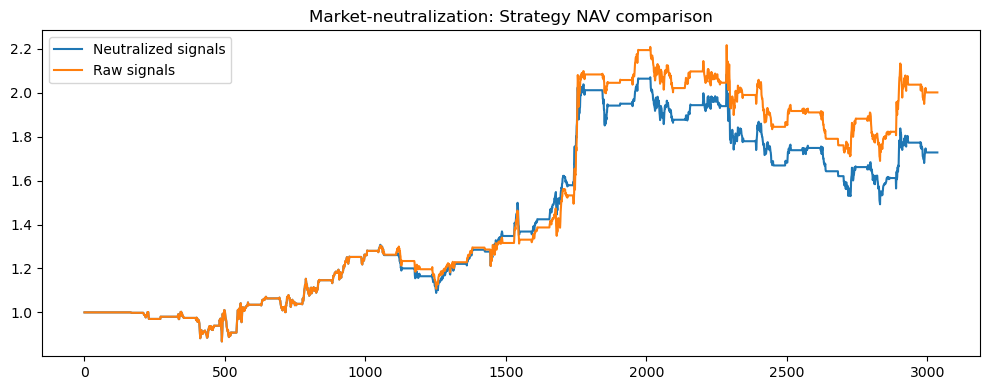

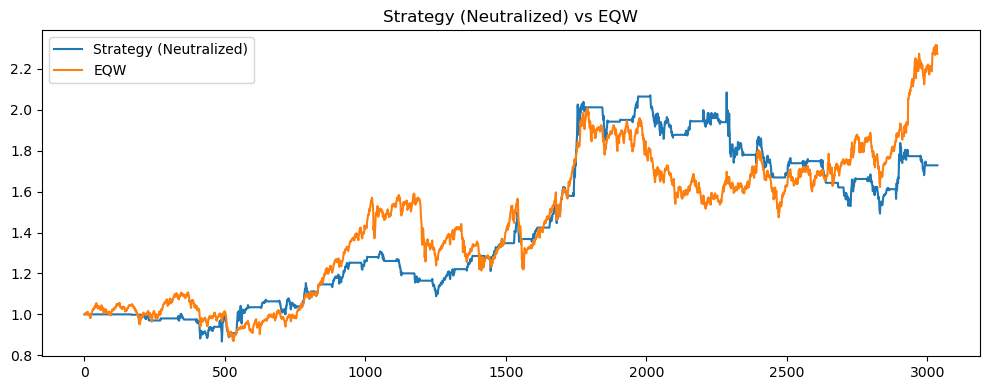

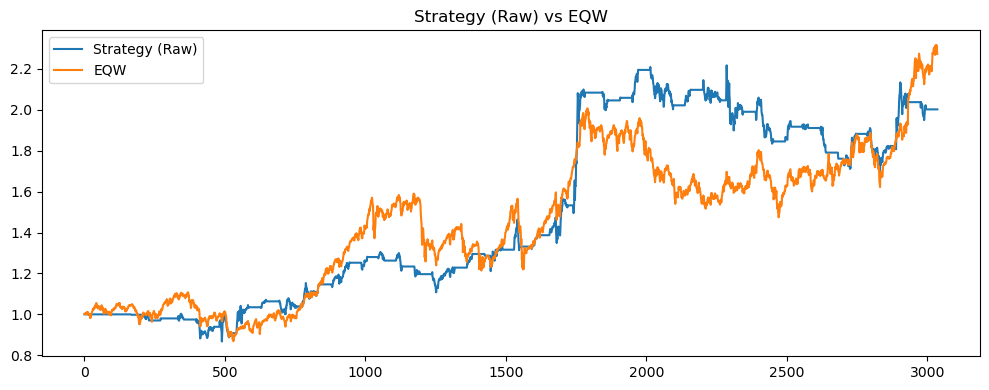

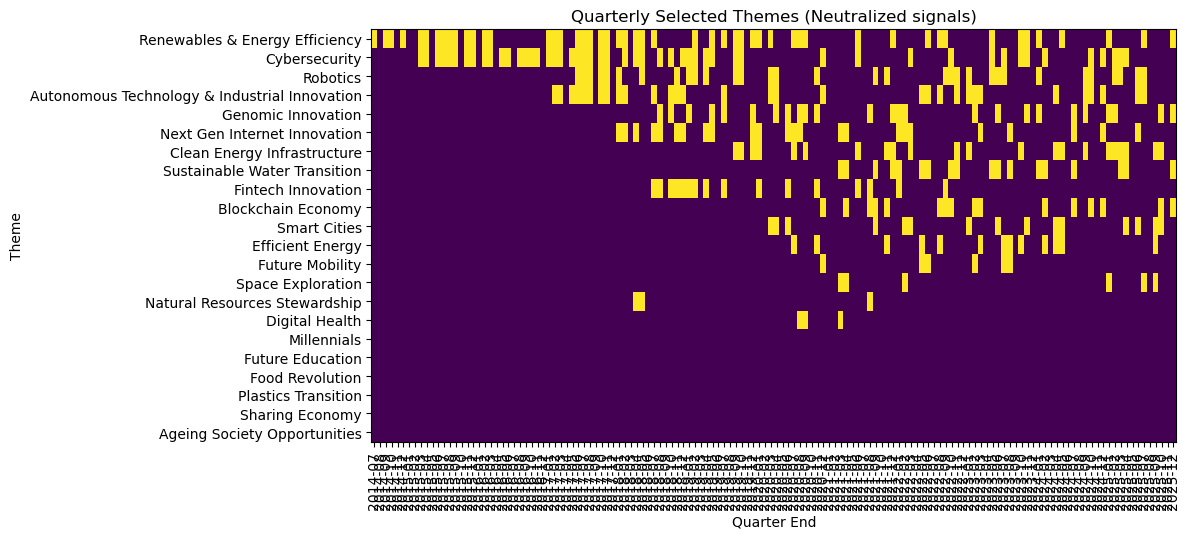

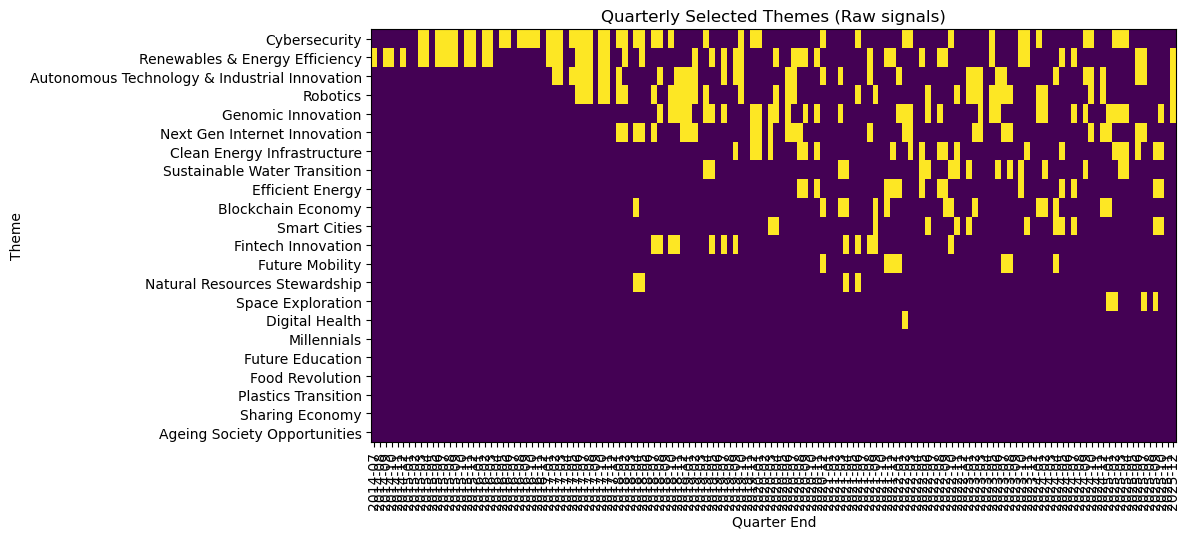

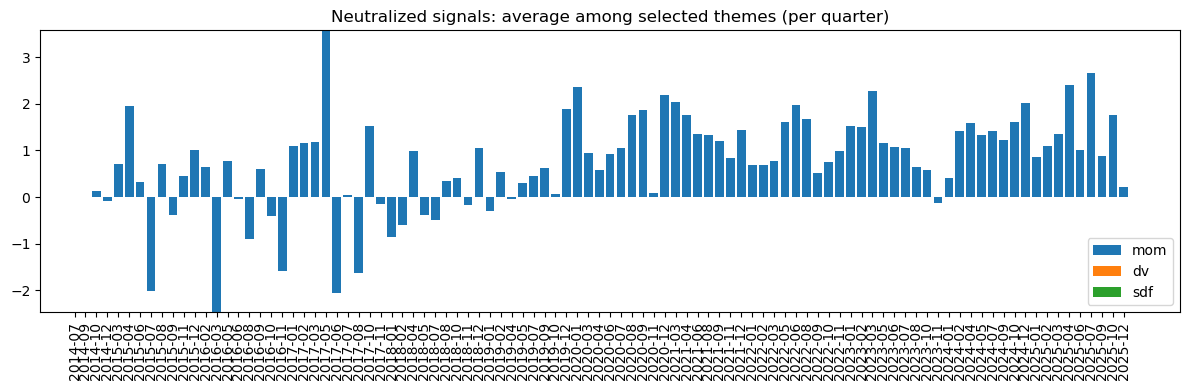

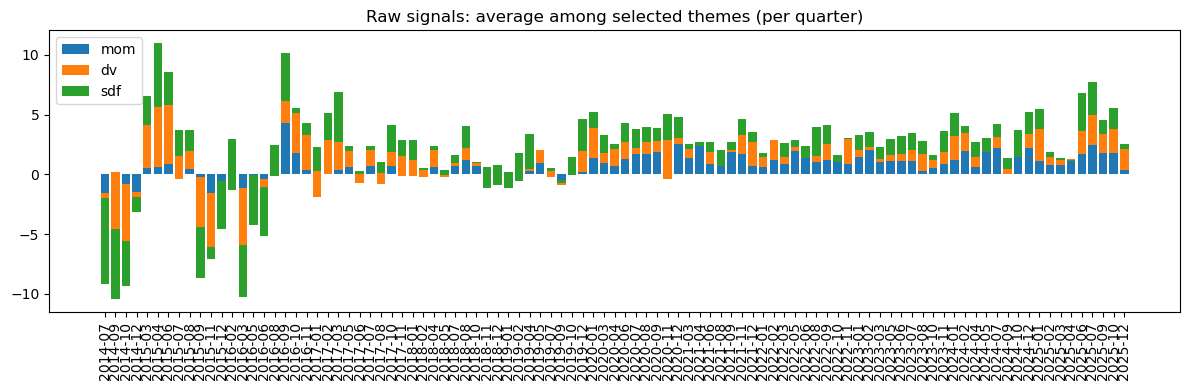

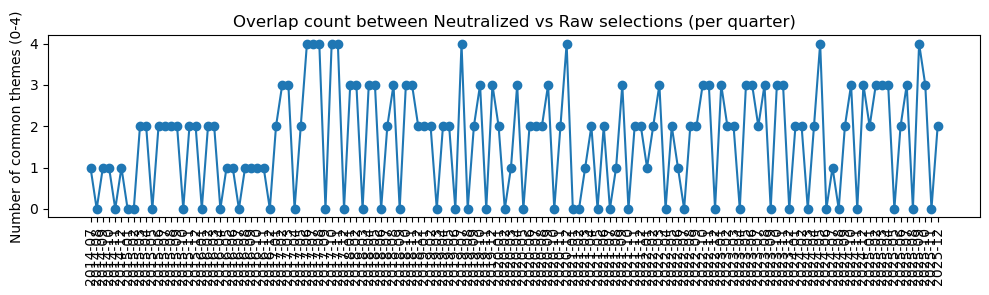

In [92]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#   (D) MSCI-like "2nd stage optimizer" for weights within selected themes
#   (E) NEW: 6M tie-break / fallback 강화 (mom3 -> mom6)
#
# Data: yfinance (Close, Volume)
# Signals:
#   - mom: 3m risk-adjusted momentum (changes last 3m vs prev 3m)  [MMS-like]
#   - dv : dollar-volume attention (changes)
#   - sdf: signed dollar-flow proxy (changes; sign from signal returns)
# Score: MMS-like -> cs-z per component -> sum -> re-z -> winsorize±3 -> round(0.1)
# Add-ons:
#   - execution lag
#   - liquidity filter (3m avg dollar volume)
#   - fallback to mom ranking (NEW: tie-break via 6M mom)
#   - risk targeting (daily RV -> monthly fixed leverage)
#   - optional market neutralization (rolling beta vs SPY)
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "M"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63             # ~3 months trading days
LB_6M = 2 * LB_3M       # ~6 months
MIN_DV_3M = 3_000_000   # $/day

# market neutralization
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# risk targeting (portfolio-level)
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

# optimizer controls
USE_WEIGHT_OPTIMIZER = True
W_MAX = 0.25
COV_WIN = 63
COV_SHRINK = 0.10
GAMMA_RISK = 10.0
LAMBDA_TURN = 1.0
GD_STEPS = 250
GD_LR = 0.05

PLOT = True
EPS = 1e-12


# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

def project_to_capped_simplex(v: np.ndarray, z: float = 1.0, ub: float = 1.0) -> np.ndarray:
    v = np.asarray(v, float).ravel()
    n = v.size
    ub = float(ub)

    if z > n * ub + 1e-12:
        w = np.ones(n) * ub
        return w / w.sum() * z

    lo = v.min() - ub
    hi = v.max()

    for _ in range(80):
        tau = 0.5 * (lo + hi)
        w = np.clip(v - tau, 0.0, ub)
        s = w.sum()
        if s > z:
            lo = tau
        else:
            hi = tau

    w = np.clip(v - 0.5 * (lo + hi), 0.0, ub)
    s = w.sum()
    if s <= 0:
        k = int(np.floor(z / ub))
        w = np.zeros(n)
        if k > 0:
            w[:k] = ub
        rem = z - w.sum()
        if rem > 0 and k < n:
            w[k] = min(ub, rem)
        return w
    return w * (z / s)

def shrink_cov(S: np.ndarray, shrink: float = 0.1, eps: float = 1e-8) -> np.ndarray:
    S = np.asarray(S, float)
    D = np.diag(np.diag(S))
    out = (1.0 - shrink) * S + shrink * D
    out = out + eps * np.eye(out.shape[0])
    return out


# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume


# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv


# ----------------------------
# 5) Market neutralization
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out


# ----------------------------
# 6) MMS-like scores + decomposition + mom3/mom6 levels
# ----------------------------
def compute_month_end_scores_with_decomp_and_mom_levels(
    ret_for_signals: pd.DataFrame,
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    """
    Returns:
      score_m : month-end final score (winsorized+rounded)
      mom3_m  : month-end 3M risk-adjusted momentum LEVEL (fallback)
      mom6_m  : month-end 6M risk-adjusted momentum LEVEL (tie-break/fallback)
      comp_m  : month-end component contributions (mom/dv/sdf) after cs-z etc.
    """
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score, rows_mom3, rows_mom6, rows_comp = [], [], [], []
    prev_rank = None

    for t in month_ends:
        loc = idx.get_loc(t)
        # need at least prev 3M and last 6M for mom6 level
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                 # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)     # prev 3m
        w6 = slice(loc - 2 * lb_3m + 1, loc + 1)             # last 6m

        # mom level in each window (risk-adjusted)
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom3 = R0 / (S0 + eps)

        R6 = (1.0 + ret_for_signals.iloc[w6]).prod(axis=0) - 1.0
        S6 = ret_for_signals.iloc[w6].std(axis=0, ddof=0)
        mom6 = R6 / (S6 + eps)

        # prev 3m for "change" construction
        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        # dv/sdf window stats
        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom3, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cs-z each
        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        # contributions
        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)
        score = winsorize(score, 3.0).round(1)

        # keep prev ordering for stable tie-break AFTER numeric ties
        if prev_rank is not None:
            # do not reorder here; we will handle tie-break at selection stage
            # but keep prev_rank updated on score ordering for fallback
            tmp = pd.DataFrame({"score": score, "prev": prev_rank.reindex(score.index)})
            tmp["prev"] = tmp["prev"].fillna(tmp["prev"].max() + 1)
            tmp = tmp.sort_values(["score", "prev"], ascending=[False, True])
            prev_rank = pd.Series(np.arange(1, len(tmp)+1), index=tmp.index)
        else:
            prev_rank = score.rank(ascending=False, method="first")

        rows_score.append(score.rename(t))
        rows_mom3.append(mom3.rename(t))
        rows_mom6.append(mom6.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom3_m  = pd.DataFrame(rows_mom3).sort_index()
    mom6_m  = pd.DataFrame(rows_mom6).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom3_m, mom6_m, comp_m


# ----------------------------
# 7) Optimizer within selected themes
# ----------------------------
def optimize_weights_within_selected(
    score_vec: pd.Series,
    cov_mat: np.ndarray,
    w_prev: np.ndarray,
    w_max: float = 0.25,
    gamma_risk: float = 10.0,
    lambda_turn: float = 1.0,
    use_scipy: bool = True
) -> np.ndarray:
    s = np.asarray(score_vec.values, float)
    n = s.size
    Sigma = np.asarray(cov_mat, float)
    w_prev = np.asarray(w_prev, float).ravel()
    if w_prev.size != n:
        w_prev = np.ones(n) / n

    w0 = project_to_capped_simplex(w_prev, z=1.0, ub=w_max)

    if use_scipy:
        try:
            from scipy.optimize import minimize

            def obj(w):
                w = np.asarray(w)
                ret_term = -np.dot(s, w)
                risk_term = gamma_risk * float(w @ Sigma @ w)
                turn_term = lambda_turn * float(np.sum((w - w_prev) ** 2))
                return ret_term + risk_term + turn_term

            def grad(w):
                w = np.asarray(w)
                return (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))

            cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0, "jac": lambda w: np.ones_like(w)}]
            bnds = [(0.0, w_max) for _ in range(n)]

            res = minimize(
                obj, w0, jac=grad, method="SLSQP",
                bounds=bnds, constraints=cons,
                options={"maxiter": 200, "ftol": 1e-12, "disp": False}
            )
            w = np.asarray(res.x, float)
            w = project_to_capped_simplex(w, z=1.0, ub=w_max)
            return w
        except Exception:
            pass

    w = w0.copy()
    for _ in range(GD_STEPS):
        g = (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))
        w = w - GD_LR * g
        w = project_to_capped_simplex(w, z=1.0, ub=w_max)
    return w

def compute_cov_at_date(theme_ret_trade: pd.DataFrame, t: pd.Timestamp, win: int = 63):
    idx = theme_ret_trade.index
    t0 = safe_get_loc(idx, t, method="ffill")
    if t0 is None:
        return None
    loc = idx.get_loc(t0)
    if loc < win:
        return None
    X = theme_ret_trade.iloc[loc - win + 1: loc + 1]
    X = X.dropna(axis=1, how="all").fillna(0.0)
    if X.shape[1] < 2:
        return None
    return X.cov(ddof=0)


# ----------------------------
# 8) Liquidity filter + quarterly top-k + fallback (mom3->mom6) + optimizer
# ----------------------------
def build_quarterly_weights(
    score_m,
    mom3_m,
    mom6_m,
    theme_dv,
    theme_ret_trade,
    top_k=TOP_K,
    lb_3m=LB_3M,
    min_dv_3m=MIN_DV_3M,
    use_optimizer: bool = True,
    w_max: float = W_MAX,
    cov_win: int = COV_WIN,
    cov_shrink: float = COV_SHRINK,
    gamma_risk: float = GAMMA_RISK,
    lambda_turn: float = LAMBDA_TURN
):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom3  = mom3_m.reindex(q_end)
    q_mom6  = mom6_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)

    # previous weights (for turnover penalty)
    w_prev_full = np.zeros(Wq.shape[1], dtype=float)

    for t in q_end:
        s = q_score.loc[t].copy()
        m3 = q_mom3.loc[t].copy()
        m6 = q_mom6.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m3[~dv_ok] = np.nan
        m6[~dv_ok] = np.nan

        # ---- Step1: pick top_k with tie-break: score -> mom3 -> mom6 ----
        pick = []

        # ranking table (only themes with ANY candidate info)
        rank = pd.DataFrame({
            "score": s,
            "mom3": m3,
            "mom6": m6
        })

        # Candidate pool for "score-first" selection
        rank_score = rank.copy()
        # keep only score-available for primary selection
        rank_score = rank_score[rank_score["score"].notna()]

        if len(rank_score) > 0:
            # stable tie-break: score desc, mom3 desc, mom6 desc
            # (no prev_rank needed because we now have mom6 tie-break; any remaining ties are rare)
            rank_score = rank_score.sort_values(
                ["score", "mom3", "mom6"],
                ascending=[False, False, False],
                kind="mergesort"
            )
            pick = list(rank_score.head(top_k).index)

        # ---- Step2: fallback fill if < top_k ----
        if len(pick) < top_k:
            # fallback ranking: mom3 desc, mom6 desc
            rank_mom = rank.copy()
            rank_mom = rank_mom[rank_mom["mom3"].notna()]
            rank_mom = rank_mom.sort_values(
                ["mom3", "mom6"],
                ascending=[False, False],
                kind="mergesort"
            )
            for name in rank_mom.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) == 0:
            continue

        # ---- Step3: assign weights ----
        if (not use_optimizer) or (len(pick) == 1):
            Wq.loc[t, pick] = 1.0 / len(pick)
        else:
            # optimizer uses the *score* as alpha; if score missing for some selected via fallback,
            # inject fallback alpha using standardized mom3 (and mom6 as minor) to avoid zeros
            score_vec = s.reindex(pick)

            # fill NaN score among picked (selected via mom fallback)
            if score_vec.isna().any():
                # cross-sectional z of mom3 and mom6 within picked
                m3p = m3.reindex(pick).fillna(0.0)
                m6p = m6.reindex(pick).fillna(0.0)
                alpha_fill = zscore_cs(m3p) + 0.25 * zscore_cs(m6p)  # small weight for mom6
                score_vec = score_vec.fillna(alpha_fill)

            # covariance from tradable theme returns
            S = compute_cov_at_date(theme_ret_trade[pick], t, win=cov_win)
            if S is None:
                Wq.loc[t, pick] = 1.0 / len(pick)
            else:
                Sigma = shrink_cov(S.values, shrink=cov_shrink, eps=1e-8)

                prev_series = pd.Series(w_prev_full, index=Wq.columns)
                w_prev_sub = prev_series.reindex(pick).values

                w_opt = optimize_weights_within_selected(
                    score_vec=score_vec,
                    cov_mat=Sigma,
                    w_prev=w_prev_sub,
                    w_max=w_max,
                    gamma_risk=gamma_risk,
                    lambda_turn=lambda_turn,
                    use_scipy=True
                )
                Wq.loc[t, pick] = w_opt

        w_prev_full = Wq.loc[t].values.copy()

    return Wq


# ----------------------------
# 9) Expand weights + backtest + risk targeting
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting(port_gross_ret, turnover, fee_bps,
                                target_vol_ann=TARGET_VOL_ANN, vol_lookback=VOL_LOOKBACK, max_leverage=MAX_LEVERAGE):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(gross, turnover, fee_bps=0.0)
    return bt


# ----------------------------
# 10) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    sel = (Wq > 0).astype(int)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]
    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    q_end = Wq.index
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        if len(comp_dates) == 0:
            break
        i = comp_dates.get_indexer([t], method="ffill")[0]
        if i < 0:
            continue
        t_comp = comp_dates[i]

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        return df.sort_values(["date","theme"])


# ----------------------------
# 11) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool):
    all_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst} | {MKT_TICKER})
    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes
    close_etf = close.drop(columns=[MKT_TICKER], errors="ignore")
    vol_etf   = volume.drop(columns=[MKT_TICKER], errors="ignore")
    theme_ret_trade, theme_dv = build_theme_series(close_etf, vol_etf)

    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    # NEW: mom6 levels returned
    score_m, mom3_m, mom6_m, comp_m = compute_month_end_scores_with_decomp_and_mom_levels(
        ret_for_signals, theme_dv, lb_3m=LB_3M
    )

    Wq = build_quarterly_weights(
        score_m=score_m,
        mom3_m=mom3_m,
        mom6_m=mom6_m,
        theme_dv=theme_dv,
        theme_ret_trade=theme_ret_trade,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M,
        use_optimizer=USE_WEIGHT_OPTIMIZER,
        w_max=W_MAX,
        cov_win=COV_WIN,
        cov_shrink=COV_SHRINK,
        gamma_risk=GAMMA_RISK,
        lambda_turn=LAMBDA_TURN
    )

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom3_m": mom3_m,
        "mom6_m": mom6_m,
        "comp_m": comp_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
    ann_vol = annualize_vol(r)
    sharpe = ann_ret / (ann_vol + 1e-12)
    mdd = max_drawdown(bt_df["nav"])
    avg_turn = float(bt_df["turnover"].mean())
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1])
    }, name=name)


# ----------------------------
# 12) Execute
# ----------------------------
if __name__ == "__main__":
    out_neut = run_pipeline(use_neutralization=True)
    out_raw  = run_pipeline(use_neutralization=False)

    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals; optimized weights)" if USE_WEIGHT_OPTIMIZER else "Strategy (Neutralized signals; equal weights)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals; optimized weights)" if USE_WEIGHT_OPTIMIZER else "Strategy (Raw signals; equal weights)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    if PLOT:
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                                    ann_ret   ann_vol  \
Strategy (Neutralized signals; optimized weights)  0.064548  0.112832   
Strategy (Raw signals; optimized weights)          0.070300  0.114604   
EQW (All themes)                                   0.070859  0.143885   

                                                     sharpe    max_dd  \
Strategy (Neutralized signals; optimized weights)  0.572068 -0.264491   
Strategy (Raw signals; optimized weights)          0.613417 -0.238735   
EQW (All themes)                                   0.492468 -0.265593   

                                                   avg_turnover  final_nav  
Strategy (Neutralized signals; optimized weights)      0.014328   2.124592  
Strategy (Raw signals; optimized weights)              0.013340   2.267105  
EQW (All themes)                                       0.000000   2.281399  

[INFO] style_alpha_m computed. Example (last 3 rows):
            Ageing Society Opportu

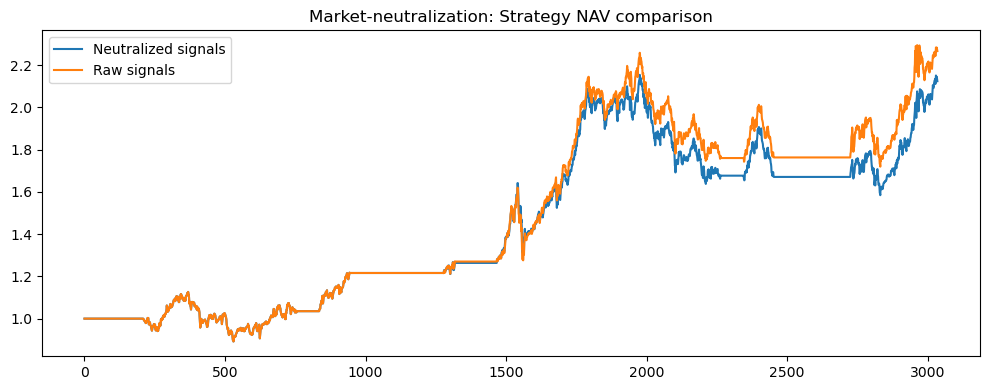

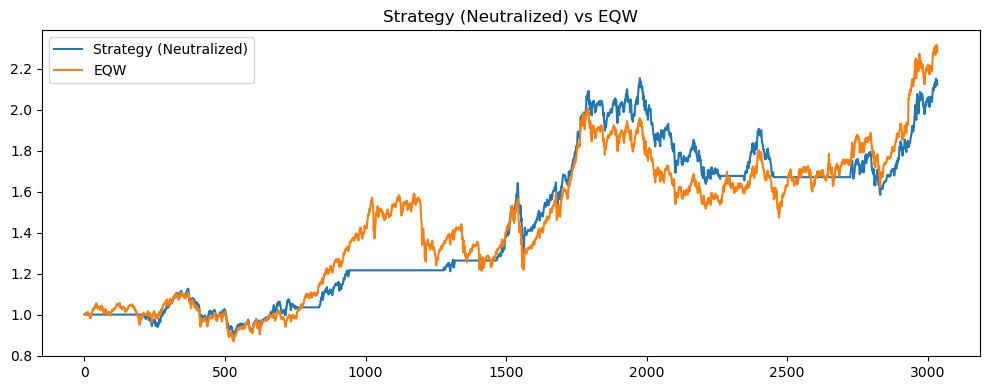

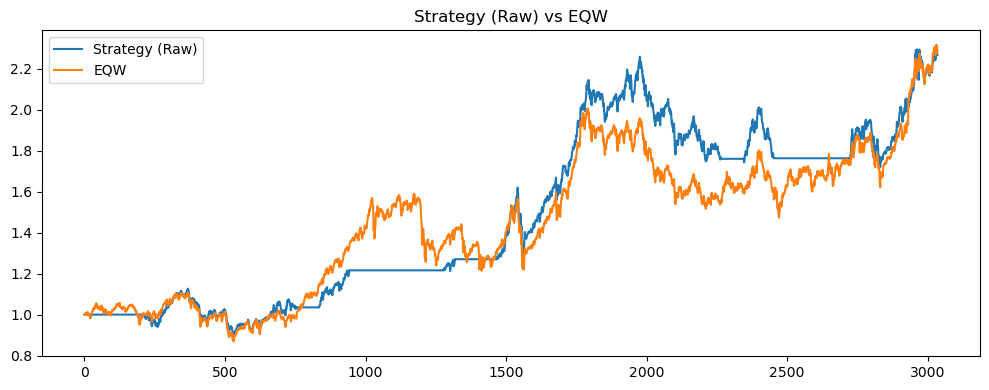

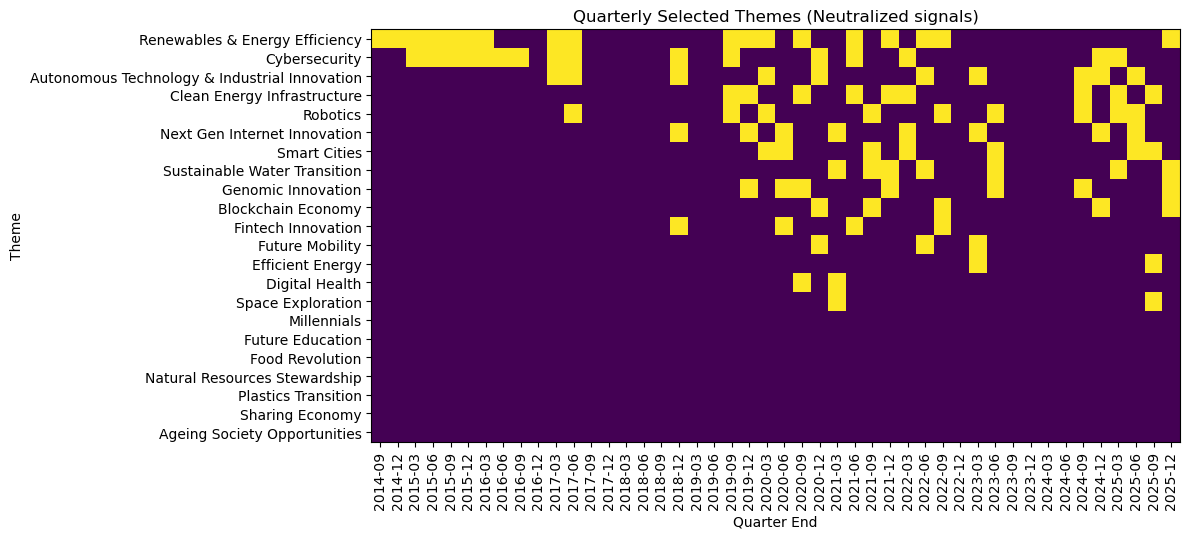

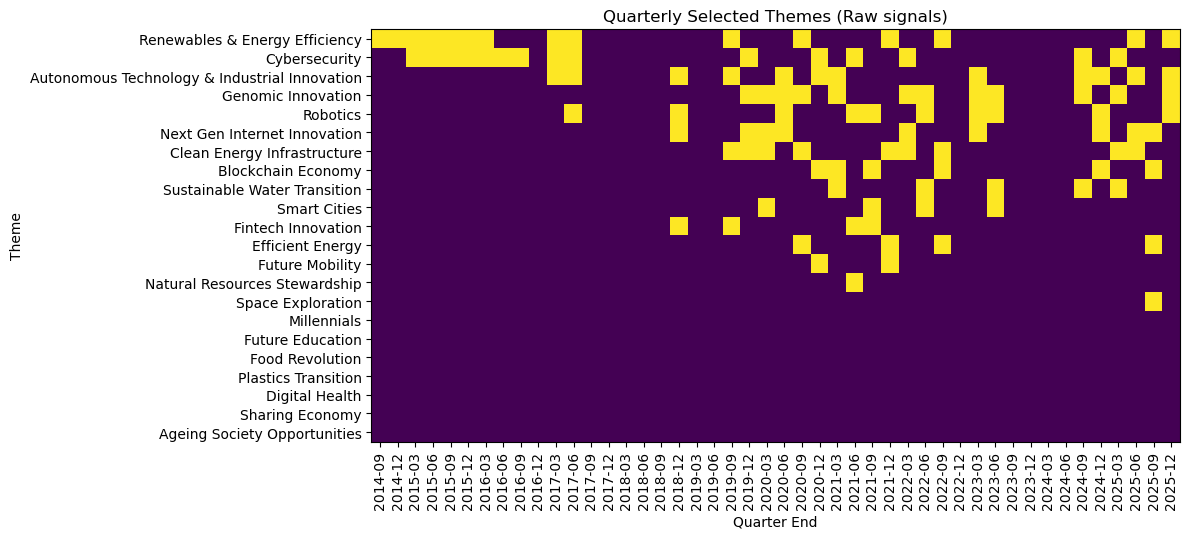

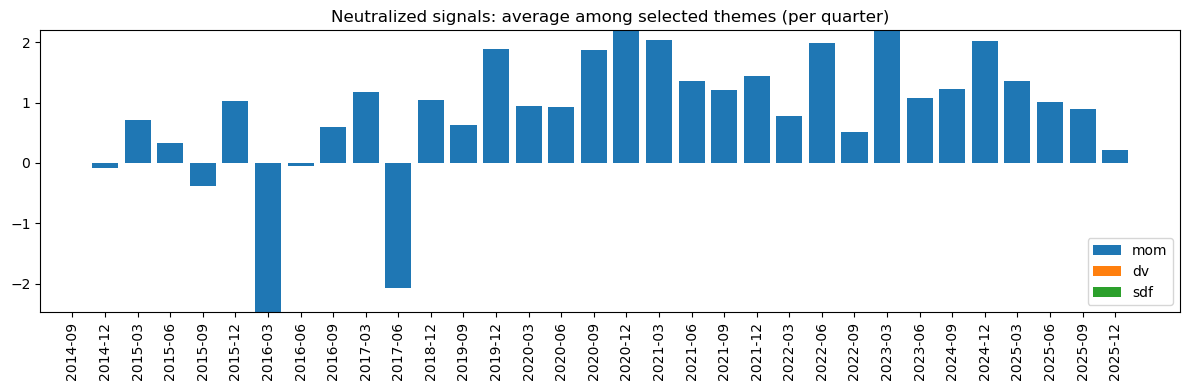

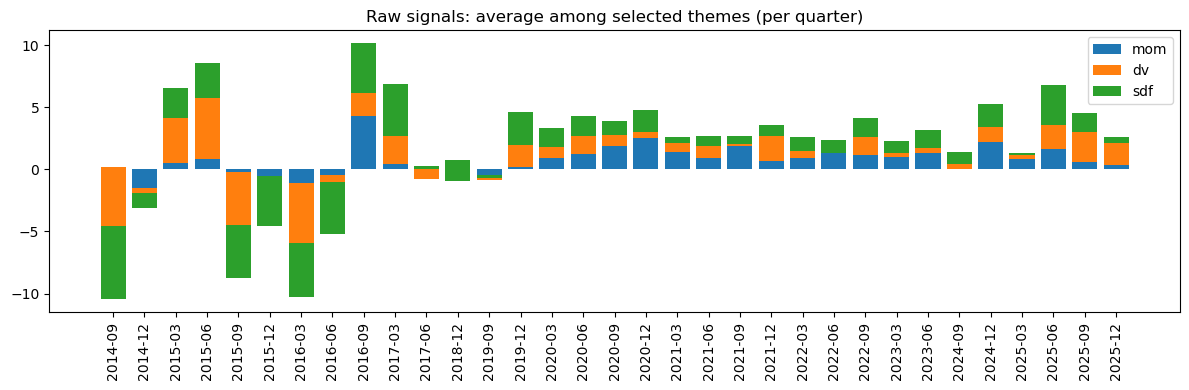

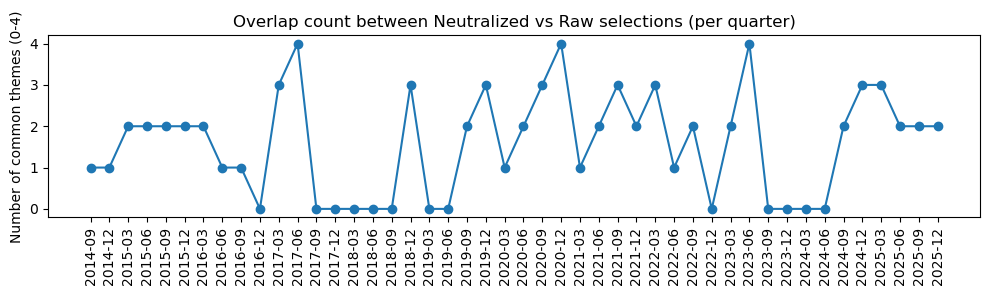

In [69]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#   (D) MSCI-like "2nd stage optimizer" for weights within selected themes
#   (E) 6M tie-break / fallback 강화 (score -> mom3 -> mom6)
#   (F) NEW: ETF factor regression (pseudo M/G/Q exposures) and inject into optimizer alpha
#
# Data: yfinance (Close, Volume)
# Signals:
#   - mom: 3m risk-adjusted momentum (changes last 3m vs prev 3m)  [MMS-like]
#   - dv : dollar-volume attention (changes)
#   - sdf: signed dollar-flow proxy (changes; sign from signal returns)
# Score: MMS-like -> cs-z per component -> sum -> re-z -> winsorize±3 -> round(0.1)
# Add-ons:
#   - execution lag
#   - liquidity filter (3m avg dollar volume)
#   - fallback to mom ranking (mom3 -> mom6)
#   - risk targeting (daily RV -> monthly fixed leverage)
#   - optional market neutralization (rolling beta vs SPY)
#   - NEW: style alpha from factor ETF regression (MTUM/IWF/QUAL) injected into optimizer alpha
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "Q"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63             # ~3 months trading days
LB_6M = 2 * LB_3M       # ~6 months
MIN_DV_3M = 3_000_000   # $/day

# market neutralization (for SIGNALS only)
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# risk targeting (portfolio-level)
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

# optimizer controls (2nd stage)
USE_WEIGHT_OPTIMIZER = True
W_MAX = 0.25
COV_WIN = 63
COV_SHRINK = 0.10
GAMMA_RISK = 10.0
LAMBDA_TURN = 1.0
GD_STEPS = 250
GD_LR = 0.05

# ---- NEW: factor regression (pseudo M/G/Q) ----
USE_STYLE_ALPHA = True
FACTOR_ETFS = {
    "M": "MTUM",   # Momentum
    "G": "IWF",    # Growth (alt: VUG)
    "Q": "QUAL",   # Quality
}
STYLE_WIN = 252          # rolling regression window (trading days)
STYLE_MIN_OBS = 126      # minimum obs to accept betas
STYLE_WEIGHT = 0.50      # weight on style_alpha in optimizer alpha
SCORE_WEIGHT = 1.00      # weight on MMS score in optimizer alpha
STYLE_WINSOR_K = 3.0     # winsorize style_alpha cross-sectionally at month-end
STYLE_TIEBREAK = True    # use style_alpha as extra tie-break in selection

PLOT = True
EPS = 1e-12


# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

def project_to_capped_simplex(v: np.ndarray, z: float = 1.0, ub: float = 1.0) -> np.ndarray:
    v = np.asarray(v, float).ravel()
    n = v.size
    ub = float(ub)

    if z > n * ub + 1e-12:
        w = np.ones(n) * ub
        return w / w.sum() * z

    lo = v.min() - ub
    hi = v.max()

    for _ in range(80):
        tau = 0.5 * (lo + hi)
        w = np.clip(v - tau, 0.0, ub)
        s = w.sum()
        if s > z:
            lo = tau
        else:
            hi = tau

    w = np.clip(v - 0.5 * (lo + hi), 0.0, ub)
    s = w.sum()
    if s <= 0:
        k = int(np.floor(z / ub))
        w = np.zeros(n)
        if k > 0:
            w[:k] = ub
        rem = z - w.sum()
        if rem > 0 and k < n:
            w[k] = min(ub, rem)
        return w
    return w * (z / s)

def shrink_cov(S: np.ndarray, shrink: float = 0.1, eps: float = 1e-8) -> np.ndarray:
    S = np.asarray(S, float)
    D = np.diag(np.diag(S))
    out = (1.0 - shrink) * S + shrink * D
    out = out + eps * np.eye(out.shape[0])
    return out


# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume


# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv


# ----------------------------
# 5) Market neutralization (signals only)
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out


# ----------------------------
# 6) MMS-like scores + decomposition + mom3/mom6 levels
# ----------------------------
def compute_month_end_scores_with_decomp_and_mom_levels(
    ret_for_signals: pd.DataFrame,
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score, rows_mom3, rows_mom6, rows_comp = [], [], [], []

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                 # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)     # prev 3m
        w6 = slice(loc - 2 * lb_3m + 1, loc + 1)             # last 6m

        # mom levels (risk-adjusted)
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom3 = R0 / (S0 + eps)

        R6 = (1.0 + ret_for_signals.iloc[w6]).prod(axis=0) - 1.0
        S6 = ret_for_signals.iloc[w6].std(axis=0, ddof=0)
        mom6 = R6 / (S6 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom3, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cs-z each
        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        # contributions
        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)
        score = winsorize(score, 3.0).round(1)

        rows_score.append(score.rename(t))
        rows_mom3.append(mom3.rename(t))
        rows_mom6.append(mom6.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom3_m  = pd.DataFrame(rows_mom3).sort_index()
    mom6_m  = pd.DataFrame(rows_mom6).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom3_m, mom6_m, comp_m


# ----------------------------
# 7) NEW: Style alpha via factor ETF regression (pseudo M/G/Q exposures)
# ----------------------------
def rolling_factor_betas_month_end(
    y_ret: pd.DataFrame,          # theme returns (daily)
    X_ret: pd.DataFrame,          # factor ETF returns (daily), columns = [M,G,Q]
    win: int = 252,
    min_obs: int = 126
):
    """
    Month-end rolling OLS betas with intercept:
      y = a + b'X + e
    Returns:
      betas_m: MultiIndex (date, theme) columns [beta_M, beta_G, beta_Q]
      style_alpha_m: month-end x theme (cross-sectional z of betas averaged)
    """
    idx = y_ret.index.intersection(X_ret.index)
    Y = y_ret.reindex(idx)
    X = X_ret.reindex(idx)

    # month ends based on idx
    month_ends = Y.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    betas_rows = []

    X_cols = list(X.columns)
    k = len(X_cols)
    if k < 2:
        # not enough factors
        betas_m = pd.DataFrame(columns=["beta_M","beta_G","beta_Q"])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    for t in month_ends:
        loc = idx.get_loc(t)
        start = loc - win + 1
        if start < 0:
            continue
        Xw = X.iloc[start:loc+1].copy()
        # build design matrix with intercept
        Xmat = np.column_stack([np.ones(len(Xw))] + [Xw[c].values for c in X_cols])

        for theme in Y.columns:
            yw = Y[theme].iloc[start:loc+1].values
            mask = np.isfinite(yw)
            for c in X_cols:
                mask = mask & np.isfinite(Xw[c].values)
            if mask.sum() < min_obs:
                continue
            A = Xmat[mask]
            b = yw[mask]
            # OLS via lstsq
            coef, *_ = np.linalg.lstsq(A, b, rcond=None)
            # coef[0]=intercept
            betas = coef[1:]
            row = {"date": t, "theme": theme}
            for j, c in enumerate(X_cols):
                row[f"beta_{c}"] = float(betas[j])
            betas_rows.append(row)

    if len(betas_rows) == 0:
        betas_m = pd.DataFrame(columns=[f"beta_{c}" for c in X_cols])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    betas_m = pd.DataFrame(betas_rows).set_index(["date","theme"]).sort_index()

    # build style alpha: cross-sectional z of betas each month-end, then average
    style_alpha_rows = []
    for d in betas_m.index.get_level_values(0).unique().sort_values():
        sub = betas_m.loc[d]
        # sub index: theme, columns: beta_*
        # cs-z each beta column
        zcols = []
        for c in [f"beta_{x}" for x in X_cols]:
            zc = zscore_cs(sub[c])
            zcols.append(zc)
        zmat = pd.concat(zcols, axis=1)
        zmat.columns = X_cols
        # average z across available factors
        a = zmat.mean(axis=1)
        a = winsorize(a, STYLE_WINSOR_K)
        style_alpha_rows.append(a.rename(d))

    style_alpha_m = pd.DataFrame(style_alpha_rows).sort_index()
    # align columns to all themes (missing -> NaN)
    style_alpha_m = style_alpha_m.reindex(columns=Y.columns)

    return betas_m, style_alpha_m


# ----------------------------
# 8) Optimizer within selected themes (2nd stage)
# ----------------------------
def optimize_weights_within_selected(
    score_vec: pd.Series,
    cov_mat: np.ndarray,
    w_prev: np.ndarray,
    w_max: float = 0.25,
    gamma_risk: float = 10.0,
    lambda_turn: float = 1.0,
    use_scipy: bool = True
) -> np.ndarray:
    s = np.asarray(score_vec.values, float)
    n = s.size
    Sigma = np.asarray(cov_mat, float)
    w_prev = np.asarray(w_prev, float).ravel()
    if w_prev.size != n:
        w_prev = np.ones(n) / n

    w0 = project_to_capped_simplex(w_prev, z=1.0, ub=w_max)

    if use_scipy:
        try:
            from scipy.optimize import minimize

            def obj(w):
                w = np.asarray(w)
                ret_term = -np.dot(s, w)
                risk_term = gamma_risk * float(w @ Sigma @ w)
                turn_term = lambda_turn * float(np.sum((w - w_prev) ** 2))
                return ret_term + risk_term + turn_term

            def grad(w):
                w = np.asarray(w)
                return (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))

            cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0, "jac": lambda w: np.ones_like(w)}]
            bnds = [(0.0, w_max) for _ in range(n)]

            res = minimize(
                obj, w0, jac=grad, method="SLSQP",
                bounds=bnds, constraints=cons,
                options={"maxiter": 200, "ftol": 1e-12, "disp": False}
            )
            w = np.asarray(res.x, float)
            w = project_to_capped_simplex(w, z=1.0, ub=w_max)
            return w
        except Exception:
            pass

    # fallback: projected GD
    w = w0.copy()
    for _ in range(GD_STEPS):
        g = (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))
        w = w - GD_LR * g
        w = project_to_capped_simplex(w, z=1.0, ub=w_max)
    return w

def compute_cov_at_date(theme_ret_trade: pd.DataFrame, t: pd.Timestamp, win: int = 63):
    idx = theme_ret_trade.index
    t0 = safe_get_loc(idx, t, method="ffill")
    if t0 is None:
        return None
    loc = idx.get_loc(t0)
    if loc < win:
        return None
    X = theme_ret_trade.iloc[loc - win + 1: loc + 1]
    X = X.dropna(axis=1, how="all").fillna(0.0)
    if X.shape[1] < 2:
        return None
    return X.cov(ddof=0)


# ----------------------------
# 9) Liquidity filter + quarterly top-k + fallback + optimizer (+ style alpha injection)
# ----------------------------
def build_quarterly_weights(
    score_m,
    mom3_m,
    mom6_m,
    style_alpha_m,          # NEW (can be None)
    theme_dv,
    theme_ret_trade,
    top_k=TOP_K,
    lb_3m=LB_3M,
    min_dv_3m=MIN_DV_3M,
    use_optimizer: bool = True,
    w_max: float = W_MAX,
    cov_win: int = COV_WIN,
    cov_shrink: float = COV_SHRINK,
    gamma_risk: float = GAMMA_RISK,
    lambda_turn: float = LAMBDA_TURN
):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom3  = mom3_m.reindex(q_end)
    q_mom6  = mom6_m.reindex(q_end)
    q_style = None if style_alpha_m is None else style_alpha_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)
    w_prev_full = np.zeros(Wq.shape[1], dtype=float)

    for t in q_end:
        s = q_score.loc[t].copy()
        m3 = q_mom3.loc[t].copy()
        m6 = q_mom6.loc[t].copy()
        st = None if q_style is None else q_style.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m3[~dv_ok] = np.nan
        m6[~dv_ok] = np.nan
        if st is not None:
            st[~dv_ok] = np.nan

        # ranking table
        rank = pd.DataFrame({"score": s, "mom3": m3, "mom6": m6})
        if st is not None and STYLE_TIEBREAK:
            rank["style"] = st
        else:
            rank["style"] = np.nan

        # ---- Step1: pick top_k with tie-break
        # score -> (style) -> mom3 -> mom6
        pick = []
        rank_score = rank[rank["score"].notna()].copy()
        if len(rank_score) > 0:
            sort_cols = ["score"]
            asc = [False]
            if STYLE_TIEBREAK and st is not None:
                sort_cols += ["style"]
                asc += [False]
            sort_cols += ["mom3", "mom6"]
            asc += [False, False]

            rank_score = rank_score.sort_values(sort_cols, ascending=asc, kind="mergesort")
            pick = list(rank_score.head(top_k).index)

        # ---- Step2: fallback fill if < top_k
        if len(pick) < top_k:
            rank_mom = rank[rank["mom3"].notna()].copy()
            sort_cols = ["mom3", "mom6"]
            asc = [False, False]
            if STYLE_TIEBREAK and st is not None:
                # style used as extra info even in fallback (weakly)
                sort_cols = ["mom3", "style", "mom6"]
                asc = [False, False, False]
            rank_mom = rank_mom.sort_values(sort_cols, ascending=asc, kind="mergesort")
            for name in rank_mom.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) == 0:
            continue

        # ---- Step3: assign weights
        if (not use_optimizer) or (len(pick) == 1):
            Wq.loc[t, pick] = 1.0 / len(pick)
        else:
            # Build optimizer alpha (score_vec):
            #   alpha = SCORE_WEIGHT * score + STYLE_WEIGHT * style_alpha
            score_vec = s.reindex(pick)

            # fill NaN score among picked via mom fallback
            if score_vec.isna().any():
                m3p = m3.reindex(pick).fillna(0.0)
                m6p = m6.reindex(pick).fillna(0.0)
                alpha_fill = zscore_cs(m3p) + 0.25 * zscore_cs(m6p)
                score_vec = score_vec.fillna(alpha_fill)

            # style component
            if USE_STYLE_ALPHA and (st is not None):
                style_vec = st.reindex(pick)
                # if style missing, set 0 (neutral)
                style_vec = style_vec.fillna(0.0)
            else:
                style_vec = pd.Series(0.0, index=pick)

            alpha_vec = SCORE_WEIGHT * score_vec + STYLE_WEIGHT * style_vec

            # covariance from tradable theme returns
            S = compute_cov_at_date(theme_ret_trade[pick], t, win=cov_win)
            if S is None:
                Wq.loc[t, pick] = 1.0 / len(pick)
            else:
                Sigma = shrink_cov(S.values, shrink=cov_shrink, eps=1e-8)

                prev_series = pd.Series(w_prev_full, index=Wq.columns)
                w_prev_sub = prev_series.reindex(pick).values

                w_opt = optimize_weights_within_selected(
                    score_vec=alpha_vec,
                    cov_mat=Sigma,
                    w_prev=w_prev_sub,
                    w_max=w_max,
                    gamma_risk=gamma_risk,
                    lambda_turn=lambda_turn,
                    use_scipy=True
                )
                Wq.loc[t, pick] = w_opt

        w_prev_full = Wq.loc[t].values.copy()

    return Wq


# ----------------------------
# 10) Expand weights + backtest + risk targeting
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting(port_gross_ret, turnover, fee_bps,
                                target_vol_ann=TARGET_VOL_ANN, vol_lookback=VOL_LOOKBACK, max_leverage=MAX_LEVERAGE):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(gross, turnover, fee_bps=0.0)
    return bt


# ----------------------------
# 11) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    sel = (Wq > 0).astype(int)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]
    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    q_end = Wq.index
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        if len(comp_dates) == 0:
            break
        i = comp_dates.get_indexer([t], method="ffill")[0]
        if i < 0:
            continue
        t_comp = comp_dates[i]

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        return df.sort_values(["date","theme"])


# ----------------------------
# 12) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool):
    theme_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst})
    factor_etfs = sorted(set(FACTOR_ETFS.values())) if USE_STYLE_ALPHA else []
    all_etfs = sorted(set(theme_etfs + factor_etfs + [MKT_TICKER]))

    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes
    close_theme = close.reindex(columns=theme_etfs).dropna(how="all")
    vol_theme   = volume.reindex(columns=theme_etfs).fillna(0.0)
    theme_ret_trade, theme_dv = build_theme_series(close_theme, vol_theme)

    # signals returns (neutralized or raw)
    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    # MMS-like scores + mom3/mom6
    score_m, mom3_m, mom6_m, comp_m = compute_month_end_scores_with_decomp_and_mom_levels(
        ret_for_signals, theme_dv, lb_3m=LB_3M
    )

    # ---- NEW: Style alpha (pseudo M/G/Q exposures) ----
    style_alpha_m = None
    betas_m = None
    if USE_STYLE_ALPHA:
        # factor returns
        fac_cols = []
        for key in ["M","G","Q"]:
            fac_cols.append(FACTOR_ETFS[key])
        # keep only available in downloaded data
        fac_cols_avail = [c for c in fac_cols if c in close.columns]
        if len(fac_cols_avail) >= 2:
            fac_close = close[fac_cols_avail].dropna(how="all").ffill()
            fac_ret = fac_close.pct_change()

            # align factor columns to keys (M/G/Q) if possible
            # we rename columns to M,G,Q if present
            rename_map = {}
            for k, tkr in FACTOR_ETFS.items():
                if tkr in fac_ret.columns:
                    rename_map[tkr] = k
            fac_ret = fac_ret.rename(columns=rename_map)

            # ensure order M,G,Q subset
            fac_ret = fac_ret[[c for c in ["M","G","Q"] if c in fac_ret.columns]]

            betas_m, style_alpha_m = rolling_factor_betas_month_end(
                y_ret=theme_ret_trade,    # exposures on tradable theme returns
                X_ret=fac_ret,
                win=STYLE_WIN,
                min_obs=STYLE_MIN_OBS
            )
        else:
            # if factors missing, disable gracefully
            style_alpha_m = None
            betas_m = None

    # Quarterly weights (selection + optimizer with style alpha injection)
    Wq = build_quarterly_weights(
        score_m=score_m,
        mom3_m=mom3_m,
        mom6_m=mom6_m,
        style_alpha_m=style_alpha_m,
        theme_dv=theme_dv,
        theme_ret_trade=theme_ret_trade,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M,
        use_optimizer=USE_WEIGHT_OPTIMIZER,
        w_max=W_MAX,
        cov_win=COV_WIN,
        cov_shrink=COV_SHRINK,
        gamma_risk=GAMMA_RISK,
        lambda_turn=LAMBDA_TURN
    )

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom3_m": mom3_m,
        "mom6_m": mom6_m,
        "comp_m": comp_m,
        "betas_m": betas_m,
        "style_alpha_m": style_alpha_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
    ann_vol = annualize_vol(r)
    sharpe = ann_ret / (ann_vol + 1e-12)
    mdd = max_drawdown(bt_df["nav"])
    avg_turn = float(bt_df["turnover"].mean())
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1])
    }, name=name)


# ----------------------------
# 13) Execute
# ----------------------------
if __name__ == "__main__":
    out_neut = run_pipeline(use_neutralization=True)
    out_raw  = run_pipeline(use_neutralization=False)

    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals; optimized weights)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals; optimized weights)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    # quick sanity: show if style alpha exists
    if USE_STYLE_ALPHA:
        if out_raw["style_alpha_m"] is None or out_raw["style_alpha_m"].dropna(how="all").empty:
            print("\n[WARN] style_alpha_m is empty (factor ETFs missing or insufficient data).")
        else:
            print("\n[INFO] style_alpha_m computed. Example (last 3 rows):")
            print(out_raw["style_alpha_m"].tail(3))

    if PLOT:
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                                    ann_ret   ann_vol  \
Strategy (Neutralized signals; optimized weights)  0.090346  0.220374   
Strategy (Raw signals; optimized weights)          0.084804  0.227328   
EQW (All themes)                                   0.085315  0.186418   

                                                     sharpe    max_dd  \
Strategy (Neutralized signals; optimized weights)  0.409967 -0.579583   
Strategy (Raw signals; optimized weights)          0.373047 -0.568709   
EQW (All themes)                                   0.457654 -0.458607   

                                                   avg_turnover  final_nav  
Strategy (Neutralized signals; optimized weights)      0.012846   2.835054  
Strategy (Raw signals; optimized weights)              0.011199   2.666236  
EQW (All themes)                                       0.000000   2.681400  

=== Config sanity ===
USE_SELECTION_BUFFER=True, BUFFER_N=2
USE_RISK_CONSTRAINT=True, RI

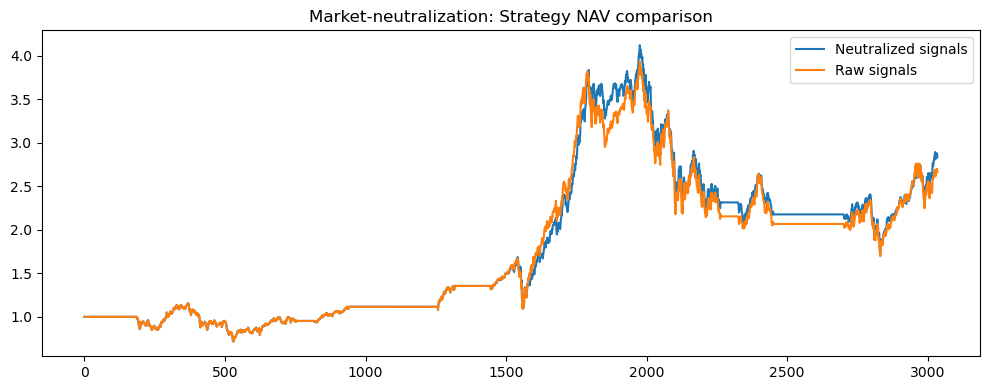

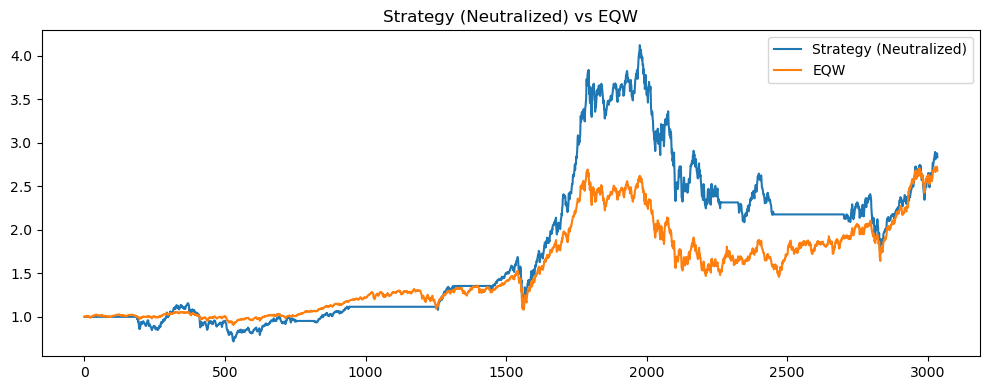

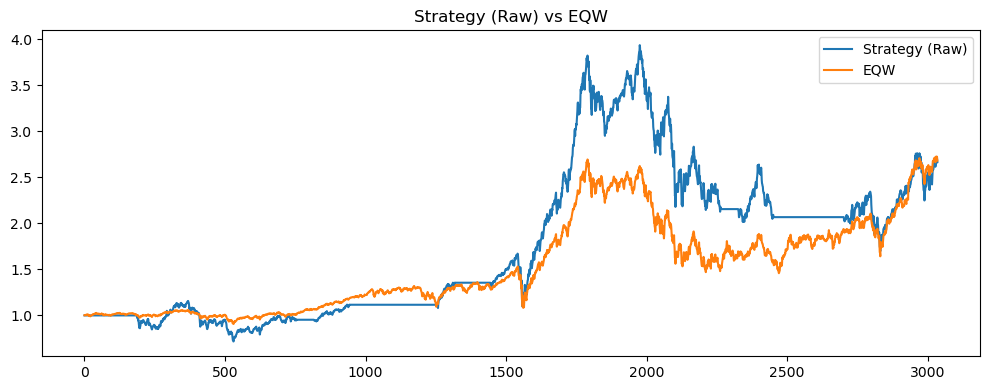

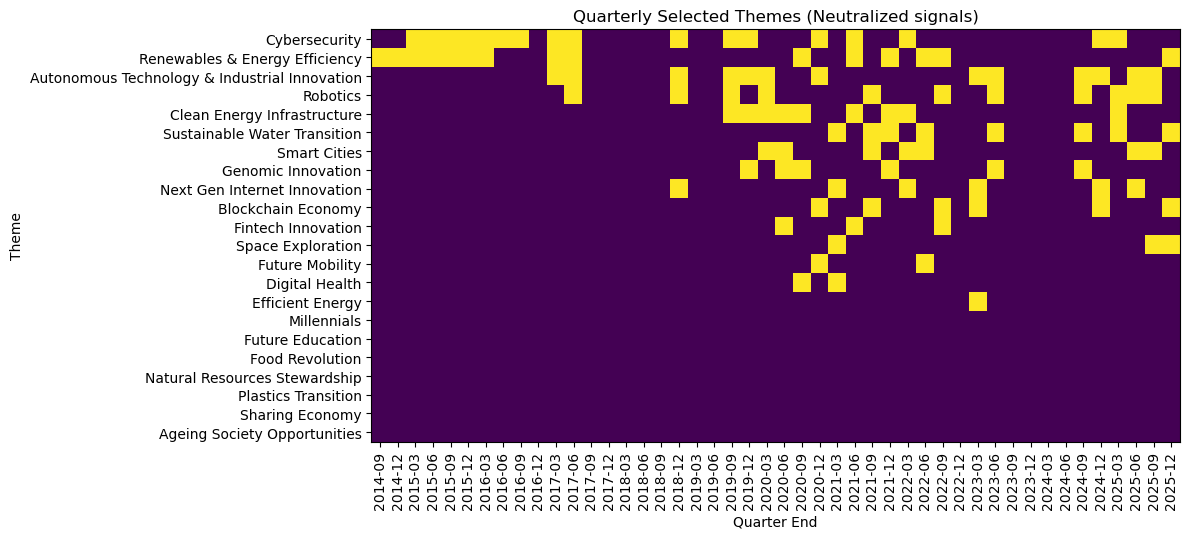

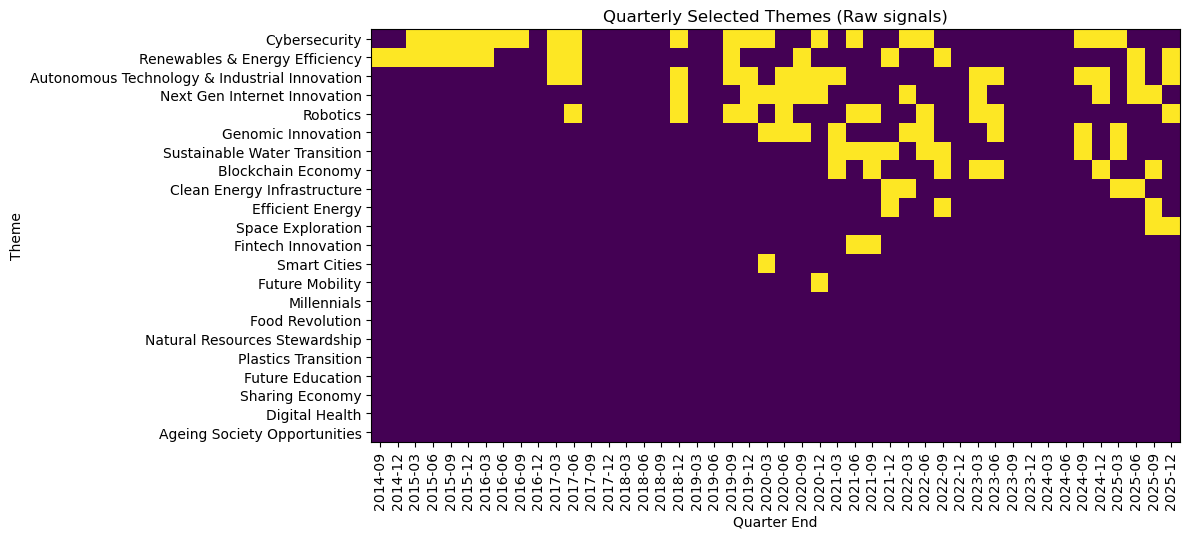

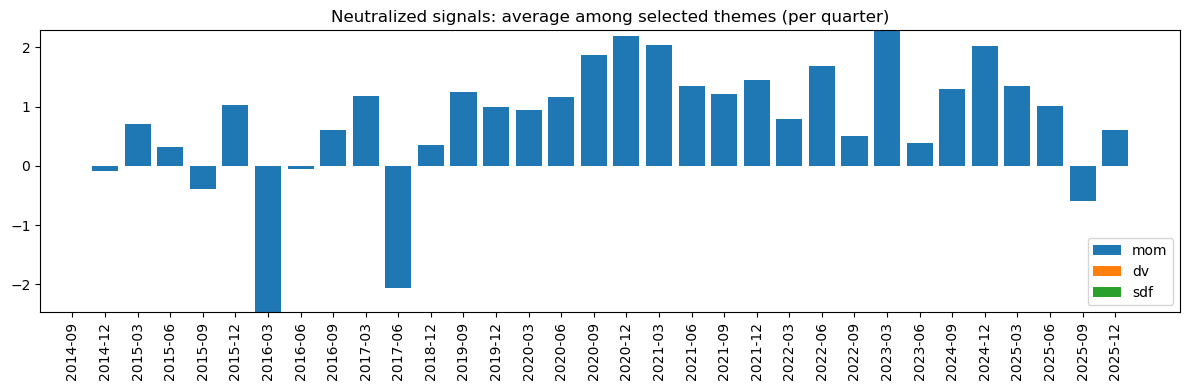

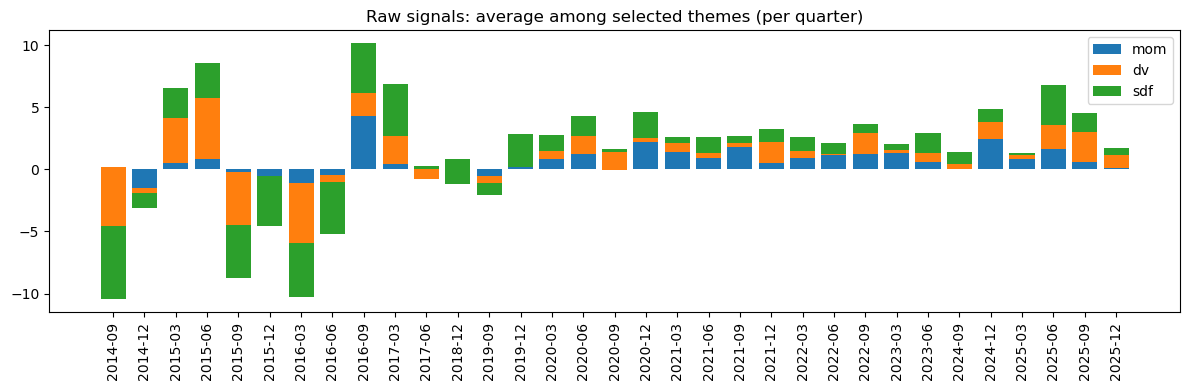

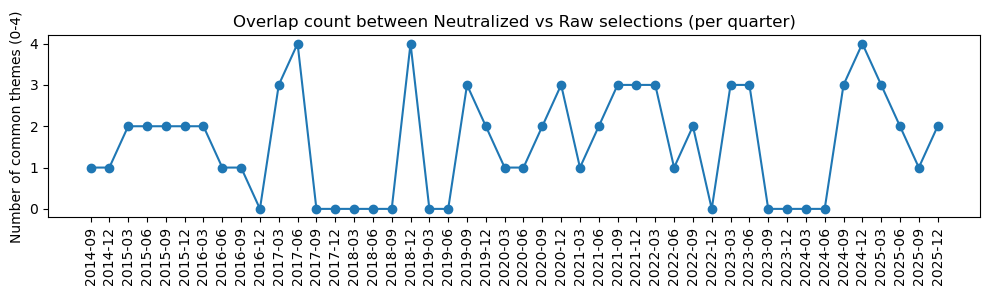

In [71]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#   (D) MSCI-like "2nd stage optimizer" for weights within selected themes
#   (E) 6M tie-break / fallback 강화 (score -> mom3 -> mom6)
#   (F) ETF factor regression (pseudo M/G/Q exposures) and inject into optimizer alpha
#
# NEW (this update):
#   (1) Selection buffer / hysteresis (turnover reduction at the "selection" layer)
#   (2) MSCI-like "target risk constraint" inside the optimizer:
#         maximize alpha subject to risk cap (w'Σw <= cap) + box + sum-to-1
#
# Data: yfinance (Close, Volume)
# Signals:
#   - mom: 3m risk-adjusted momentum (changes last 3m vs prev 3m)  [MMS-like]
#   - dv : dollar-volume attention (changes)
#   - sdf: signed dollar-flow proxy (changes; sign from signal returns)
# Score: MMS-like -> cs-z per component -> sum -> re-z -> winsorize±3 -> round(0.1)
# Add-ons:
#   - execution lag (look-ahead avoidance)
#   - liquidity filter (3m avg dollar volume)
#   - fallback to mom ranking (mom3 -> mom6)
#   - optional market neutralization (rolling beta vs SPY)  [signals only]
#   - optional overlay: volatility targeting (daily RV -> monthly fixed leverage)
#     NOTE: MSCI-like risk control is mainly via the optimizer risk constraint (2).
#           Therefore the most "MSCI-aligned" default here is:
#             USE_VOL_TARGETING = False
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "Q"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63              # ~3 months trading days
LB_6M = 2 * LB_3M       # ~6 months
MIN_DV_3M = 3_000_000    # $/day

# market neutralization (for SIGNALS only)
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# ---- NEW (1): selection buffer/hysteresis ----
USE_SELECTION_BUFFER = True
BUFFER_N = 2  # keep incumbents if ranked within TOP_K + BUFFER_N

# ---- Optimizer controls (2nd stage) ----
USE_WEIGHT_OPTIMIZER = True
W_MAX = 0.25
COV_WIN = 63
COV_SHRINK = 0.10
GAMMA_RISK = 5.0        # keep modest since we add a hard risk constraint below
LAMBDA_TURN = 1.0
GD_STEPS = 250
GD_LR = 0.05

# ---- NEW (2): MSCI-like target risk constraint inside optimizer ----
USE_RISK_CONSTRAINT = True
RISK_CAP_MULT = 1.00   # cap relative to equal-weight variance among picked (1.0 = same as EW; <1 tighter)

# ---- Optional overlay: volatility targeting (portfolio-level) ----
# Most MSCI-aligned choice: keep OFF, rely on optimizer risk constraint.
USE_VOL_TARGETING = False
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

# ---- ETF factor regression (pseudo M/G/Q) ----
USE_STYLE_ALPHA = True
FACTOR_ETFS = {
    "M": "MTUM",   # Momentum
    "G": "IWF",    # Growth (alt: VUG)
    "Q": "QUAL",   # Quality
}
STYLE_WIN = 252
STYLE_MIN_OBS = 126
STYLE_WEIGHT = 0.50
SCORE_WEIGHT = 1.00
STYLE_WINSOR_K = 3.0
STYLE_TIEBREAK = True   # use style_alpha as extra tie-break in selection

PLOT = True
EPS = 1e-12


# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

def project_to_capped_simplex(v: np.ndarray, z: float = 1.0, ub: float = 1.0) -> np.ndarray:
    v = np.asarray(v, float).ravel()
    n = v.size
    ub = float(ub)

    if z > n * ub + 1e-12:
        w = np.ones(n) * ub
        return w / w.sum() * z

    lo = v.min() - ub
    hi = v.max()

    for _ in range(80):
        tau = 0.5 * (lo + hi)
        w = np.clip(v - tau, 0.0, ub)
        s = w.sum()
        if s > z:
            lo = tau
        else:
            hi = tau

    w = np.clip(v - 0.5 * (lo + hi), 0.0, ub)
    s = w.sum()
    if s <= 0:
        k = int(np.floor(z / ub))
        w = np.zeros(n)
        if k > 0:
            w[:k] = ub
        rem = z - w.sum()
        if rem > 0 and k < n:
            w[k] = min(ub, rem)
        return w
    return w * (z / s)

def shrink_cov(S: np.ndarray, shrink: float = 0.1, eps: float = 1e-8) -> np.ndarray:
    S = np.asarray(S, float)
    D = np.diag(np.diag(S))
    out = (1.0 - shrink) * S + shrink * D
    out = out + eps * np.eye(out.shape[0])
    return out


# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume


# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv


# ----------------------------
# 5) Market neutralization (signals only)
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out


# ----------------------------
# 6) MMS-like scores + decomposition + mom3/mom6 levels
# ----------------------------
def compute_month_end_scores_with_decomp_and_mom_levels(
    ret_for_signals: pd.DataFrame,
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score, rows_mom3, rows_mom6, rows_comp = [], [], [], []

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                 # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)     # prev 3m
        w6 = slice(loc - 2 * lb_3m + 1, loc + 1)             # last 6m

        # mom levels (risk-adjusted)
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom3 = R0 / (S0 + eps)

        R6 = (1.0 + ret_for_signals.iloc[w6]).prod(axis=0) - 1.0
        S6 = ret_for_signals.iloc[w6].std(axis=0, ddof=0)
        mom6 = R6 / (S6 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom3, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cs-z each
        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        # contributions
        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)
        score = winsorize(score, 3.0).round(1)

        rows_score.append(score.rename(t))
        rows_mom3.append(mom3.rename(t))
        rows_mom6.append(mom6.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom3_m  = pd.DataFrame(rows_mom3).sort_index()
    mom6_m  = pd.DataFrame(rows_mom6).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom3_m, mom6_m, comp_m


# ----------------------------
# 7) Style alpha via factor ETF regression (pseudo M/G/Q exposures)
# ----------------------------
def rolling_factor_betas_month_end(
    y_ret: pd.DataFrame,
    X_ret: pd.DataFrame,
    win: int = 252,
    min_obs: int = 126
):
    """
    Month-end rolling OLS betas with intercept:
      y = a + b'X + e
    Returns:
      betas_m: MultiIndex (date, theme) columns beta_{M,G,Q subset}
      style_alpha_m: month-end x theme (cross-sectional z of betas averaged)
    """
    idx = y_ret.index.intersection(X_ret.index)
    Y = y_ret.reindex(idx)
    X = X_ret.reindex(idx)

    month_ends = Y.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    betas_rows = []
    X_cols = list(X.columns)
    if len(X_cols) < 2:
        betas_m = pd.DataFrame(columns=[f"beta_{c}" for c in X_cols])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    for t in month_ends:
        loc = idx.get_loc(t)
        start = loc - win + 1
        if start < 0:
            continue
        Xw = X.iloc[start:loc+1].copy()
        Xmat = np.column_stack([np.ones(len(Xw))] + [Xw[c].values for c in X_cols])

        for theme in Y.columns:
            yw = Y[theme].iloc[start:loc+1].values
            mask = np.isfinite(yw)
            for c in X_cols:
                mask = mask & np.isfinite(Xw[c].values)
            if mask.sum() < min_obs:
                continue
            A = Xmat[mask]
            b = yw[mask]
            coef, *_ = np.linalg.lstsq(A, b, rcond=None)
            betas = coef[1:]
            row = {"date": t, "theme": theme}
            for j, c in enumerate(X_cols):
                row[f"beta_{c}"] = float(betas[j])
            betas_rows.append(row)

    if len(betas_rows) == 0:
        betas_m = pd.DataFrame(columns=[f"beta_{c}" for c in X_cols])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    betas_m = pd.DataFrame(betas_rows).set_index(["date","theme"]).sort_index()

    style_alpha_rows = []
    for d in betas_m.index.get_level_values(0).unique().sort_values():
        sub = betas_m.loc[d]  # index=theme
        zcols = []
        for c in [f"beta_{x}" for x in X_cols]:
            zcols.append(zscore_cs(sub[c]))
        zmat = pd.concat(zcols, axis=1)
        zmat.columns = X_cols
        a = zmat.mean(axis=1)
        a = winsorize(a, STYLE_WINSOR_K)
        style_alpha_rows.append(a.rename(d))

    style_alpha_m = pd.DataFrame(style_alpha_rows).sort_index()
    style_alpha_m = style_alpha_m.reindex(columns=Y.columns)
    return betas_m, style_alpha_m


# ----------------------------
# 8) Optimizer within selected themes (2nd stage) with risk constraint
# ----------------------------
def optimize_weights_within_selected(
    score_vec: pd.Series,
    cov_mat: np.ndarray,
    w_prev: np.ndarray,
    w_max: float = 0.25,
    gamma_risk: float = 5.0,
    lambda_turn: float = 1.0,
    use_scipy: bool = True,
    use_risk_constraint: bool = True,
    risk_cap_var: float = None,
) -> np.ndarray:
    s = np.asarray(score_vec.values, float)
    n = s.size
    Sigma = np.asarray(cov_mat, float)
    w_prev = np.asarray(w_prev, float).ravel()
    if w_prev.size != n:
        w_prev = np.ones(n) / n

    w0 = project_to_capped_simplex(w_prev, z=1.0, ub=w_max)

    if (risk_cap_var is None) and use_risk_constraint:
        w_eq = np.ones(n) / n
        risk_cap_var = float(w_eq @ Sigma @ w_eq)

    if use_scipy:
        try:
            from scipy.optimize import minimize

            def obj(w):
                w = np.asarray(w)
                # maximize alpha' w  => minimize -alpha'w
                ret_term  = -float(np.dot(s, w))
                risk_term = gamma_risk * float(w @ Sigma @ w)
                turn_term = lambda_turn * float(np.sum((w - w_prev) ** 2))
                return ret_term + risk_term + turn_term

            def grad(w):
                w = np.asarray(w)
                return (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))

            cons = [{"type": "eq",
                     "fun": lambda w: np.sum(w) - 1.0,
                     "jac": lambda w: np.ones_like(w)}]

            if use_risk_constraint and (risk_cap_var is not None) and np.isfinite(risk_cap_var):
                # risk_cap_var - w'Σw >= 0
                cons.append({"type": "ineq",
                             "fun": lambda w, rc=risk_cap_var: rc - float(np.asarray(w) @ Sigma @ np.asarray(w))})

            bnds = [(0.0, w_max) for _ in range(n)]

            res = minimize(
                obj, w0, jac=grad, method="SLSQP",
                bounds=bnds, constraints=cons,
                options={"maxiter": 300, "ftol": 1e-12, "disp": False}
            )
            w = np.asarray(res.x, float)
            w = project_to_capped_simplex(w, z=1.0, ub=w_max)
            return w
        except Exception:
            pass

    # fallback: projected GD (does not strictly enforce risk cap)
    w = w0.copy()
    for _ in range(GD_STEPS):
        g = (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))
        w = w - GD_LR * g
        w = project_to_capped_simplex(w, z=1.0, ub=w_max)
    return w

def compute_cov_at_date(theme_ret_trade: pd.DataFrame, t: pd.Timestamp, win: int = 63):
    idx = theme_ret_trade.index
    t0 = safe_get_loc(idx, t, method="ffill")
    if t0 is None:
        return None
    loc = idx.get_loc(t0)
    if loc < win:
        return None
    X = theme_ret_trade.iloc[loc - win + 1: loc + 1]
    X = X.dropna(axis=1, how="all").fillna(0.0)
    if X.shape[1] < 2:
        return None
    return X.cov(ddof=0)


# ----------------------------
# 9) Liquidity filter + quarterly top-k + fallback + optimizer (+ style alpha injection)
#     + NEW (1): buffer/hysteresis
#     + NEW (2): risk constraint in optimizer
# ----------------------------
def build_quarterly_weights(
    score_m,
    mom3_m,
    mom6_m,
    style_alpha_m,
    theme_dv,
    theme_ret_trade,
    top_k=TOP_K,
    lb_3m=LB_3M,
    min_dv_3m=MIN_DV_3M,
    use_optimizer: bool = True,
    w_max: float = W_MAX,
    cov_win: int = COV_WIN,
    cov_shrink: float = COV_SHRINK,
    gamma_risk: float = GAMMA_RISK,
    lambda_turn: float = LAMBDA_TURN,
):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom3  = mom3_m.reindex(q_end)
    q_mom6  = mom6_m.reindex(q_end)
    q_style = None if style_alpha_m is None else style_alpha_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)
    w_prev_full = np.zeros(Wq.shape[1], dtype=float)

    for t in q_end:
        s = q_score.loc[t].copy()
        m3 = q_mom3.loc[t].copy()
        m6 = q_mom6.loc[t].copy()
        st = None if q_style is None else q_style.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m3[~dv_ok] = np.nan
        m6[~dv_ok] = np.nan
        if st is not None:
            st[~dv_ok] = np.nan

        # ranking table
        rank = pd.DataFrame({"score": s, "mom3": m3, "mom6": m6})
        if st is not None and STYLE_TIEBREAK:
            rank["style"] = st
        else:
            rank["style"] = np.nan

        # ----------------------------
        # Step1: ranking order (score -> style -> mom3 -> mom6)
        # + NEW (1): selection buffer/hysteresis
        # ----------------------------
        pick = []
        rank_score = rank[rank["score"].notna()].copy()
        if len(rank_score) > 0:
            sort_cols = ["score"]
            asc = [False]
            if STYLE_TIEBREAK and st is not None:
                sort_cols += ["style"]
                asc += [False]
            sort_cols += ["mom3", "mom6"]
            asc += [False, False]
            rank_score = rank_score.sort_values(sort_cols, ascending=asc, kind="mergesort")
            order = list(rank_score.index)
        else:
            order = []

        incumbents = list(Wq.columns[(w_prev_full > 0)]) if (USE_SELECTION_BUFFER and (w_prev_full.sum() > 0)) else []

        if USE_SELECTION_BUFFER and (len(order) > 0) and (len(incumbents) > 0):
            rank_pos = {name: i for i, name in enumerate(order)}
            keep = []
            for name in incumbents:
                if name in rank_pos and rank_pos[name] <= (top_k + BUFFER_N - 1):
                    keep.append(name)

            pick = keep.copy()
            for name in order:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break
        else:
            pick = order[:top_k]

        # ----------------------------
        # Step2: fallback fill if < top_k (mom3 -> mom6; optionally style)
        # ----------------------------
        if len(pick) < top_k:
            rank_mom = rank[rank["mom3"].notna()].copy()
            sort_cols = ["mom3", "mom6"]
            asc = [False, False]
            if STYLE_TIEBREAK and st is not None:
                sort_cols = ["mom3", "style", "mom6"]
                asc = [False, False, False]
            rank_mom = rank_mom.sort_values(sort_cols, ascending=asc, kind="mergesort")
            for name in rank_mom.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) == 0:
            continue

        # ----------------------------
        # Step3: assign weights (EQW or optimizer)
        # + NEW (2): risk constraint inside optimizer
        # ----------------------------
        if (not use_optimizer) or (len(pick) == 1):
            Wq.loc[t, pick] = 1.0 / len(pick)
        else:
            # alpha = SCORE_WEIGHT * score + STYLE_WEIGHT * style_alpha
            score_vec = s.reindex(pick)

            # fill NaN score among picked via mom fallback
            if score_vec.isna().any():
                m3p = m3.reindex(pick).fillna(0.0)
                m6p = m6.reindex(pick).fillna(0.0)
                alpha_fill = zscore_cs(m3p) + 0.25 * zscore_cs(m6p)
                score_vec = score_vec.fillna(alpha_fill)

            # style component
            if USE_STYLE_ALPHA and (st is not None):
                style_vec = st.reindex(pick).fillna(0.0)
            else:
                style_vec = pd.Series(0.0, index=pick)

            alpha_vec = SCORE_WEIGHT * score_vec + STYLE_WEIGHT * style_vec

            # covariance from tradable theme returns
            S = compute_cov_at_date(theme_ret_trade[pick], t, win=cov_win)
            if S is None:
                Wq.loc[t, pick] = 1.0 / len(pick)
            else:
                Sigma = shrink_cov(S.values, shrink=cov_shrink, eps=1e-8)

                prev_series = pd.Series(w_prev_full, index=Wq.columns)
                w_prev_sub = prev_series.reindex(pick).values

                # risk cap relative to equal-weight risk among picked
                w_eq = np.ones(len(pick)) / len(pick)
                base_var = float(w_eq @ Sigma @ w_eq)
                risk_cap_var = float(RISK_CAP_MULT * base_var)

                w_opt = optimize_weights_within_selected(
                    score_vec=alpha_vec,
                    cov_mat=Sigma,
                    w_prev=w_prev_sub,
                    w_max=w_max,
                    gamma_risk=gamma_risk,
                    lambda_turn=lambda_turn,
                    use_scipy=True,
                    use_risk_constraint=USE_RISK_CONSTRAINT,
                    risk_cap_var=risk_cap_var,
                )
                Wq.loc[t, pick] = w_opt

        w_prev_full = Wq.loc[t].values.copy()

    return Wq


# ----------------------------
# 10) Expand weights + backtest + (optional) volatility targeting overlay
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting_overlay(
    port_gross_ret: pd.Series,
    turnover: pd.Series,
    fee_bps: float,
    target_vol_ann: float = TARGET_VOL_ANN,
    vol_lookback: int = VOL_LOOKBACK,
    max_leverage: float = MAX_LEVERAGE,
):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def apply_cost_only(port_gross_ret: pd.Series, turnover: pd.Series, fee_bps: float):
    fee = fee_bps * 1e-4
    cost = turnover * fee
    net = port_gross_ret - cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": 1.0,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=port_gross_ret.index)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)

    if USE_VOL_TARGETING:
        bt = apply_monthly_risk_targeting_overlay(port_gross, turnover, fee_bps)
    else:
        bt = apply_cost_only(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)

    # benchmark has no trading costs; keep overlay consistent with strategy toggle
    if USE_VOL_TARGETING:
        bt = apply_monthly_risk_targeting_overlay(gross, turnover, fee_bps=0.0)
    else:
        bt = apply_cost_only(gross, turnover, fee_bps=0.0)
    return bt


# ----------------------------
# 11) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    sel = (Wq > 0).astype(int)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]
    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    q_end = Wq.index
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        if len(comp_dates) == 0:
            break
        i = comp_dates.get_indexer([t], method="ffill")[0]
        if i < 0:
            continue
        t_comp = comp_dates[i]

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        return df.sort_values(["date","theme"])


# ----------------------------
# 12) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool):
    theme_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst})
    factor_etfs = sorted(set(FACTOR_ETFS.values())) if USE_STYLE_ALPHA else []
    all_etfs = sorted(set(theme_etfs + factor_etfs + [MKT_TICKER]))

    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes
    close_theme = close.reindex(columns=theme_etfs).dropna(how="all")
    vol_theme   = volume.reindex(columns=theme_etfs).fillna(0.0)
    theme_ret_trade, theme_dv = build_theme_series(close_theme, vol_theme)

    # signals returns (neutralized or raw)
    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    # MMS-like scores + mom3/mom6
    score_m, mom3_m, mom6_m, comp_m = compute_month_end_scores_with_decomp_and_mom_levels(
        ret_for_signals, theme_dv, lb_3m=LB_3M
    )

    # Style alpha (pseudo M/G/Q exposures)
    style_alpha_m = None
    betas_m = None
    if USE_STYLE_ALPHA:
        fac_cols = [FACTOR_ETFS[k] for k in ["M","G","Q"]]
        fac_cols_avail = [c for c in fac_cols if c in close.columns]
        if len(fac_cols_avail) >= 2:
            fac_close = close[fac_cols_avail].dropna(how="all").ffill()
            fac_ret = fac_close.pct_change()

            rename_map = {}
            for k, tkr in FACTOR_ETFS.items():
                if tkr in fac_ret.columns:
                    rename_map[tkr] = k
            fac_ret = fac_ret.rename(columns=rename_map)
            fac_ret = fac_ret[[c for c in ["M","G","Q"] if c in fac_ret.columns]]

            betas_m, style_alpha_m = rolling_factor_betas_month_end(
                y_ret=theme_ret_trade,
                X_ret=fac_ret,
                win=STYLE_WIN,
                min_obs=STYLE_MIN_OBS
            )

    # Quarterly weights (selection + optimizer with style alpha injection)
    Wq = build_quarterly_weights(
        score_m=score_m,
        mom3_m=mom3_m,
        mom6_m=mom6_m,
        style_alpha_m=style_alpha_m,
        theme_dv=theme_dv,
        theme_ret_trade=theme_ret_trade,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M,
        use_optimizer=USE_WEIGHT_OPTIMIZER,
        w_max=W_MAX,
        cov_win=COV_WIN,
        cov_shrink=COV_SHRINK,
        gamma_risk=GAMMA_RISK,
        lambda_turn=LAMBDA_TURN
    )

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom3_m": mom3_m,
        "mom6_m": mom6_m,
        "comp_m": comp_m,
        "betas_m": betas_m,
        "style_alpha_m": style_alpha_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0) if len(r) > 0 else np.nan
    ann_vol = annualize_vol(r) if len(r) > 1 else np.nan
    sharpe = ann_ret / (ann_vol + 1e-12) if np.isfinite(ann_ret) and np.isfinite(ann_vol) else np.nan
    mdd = max_drawdown(bt_df["nav"]) if len(bt_df) > 0 else np.nan
    avg_turn = float(bt_df["turnover"].mean()) if "turnover" in bt_df.columns else np.nan
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1]) if len(bt_df) > 0 else np.nan
    }, name=name)


# ----------------------------
# 13) Execute
# ----------------------------
if __name__ == "__main__":
    out_neut = run_pipeline(use_neutralization=True)
    out_raw  = run_pipeline(use_neutralization=False)

    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals; optimized weights)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals; optimized weights)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    print("\n=== Config sanity ===")
    print(f"USE_SELECTION_BUFFER={USE_SELECTION_BUFFER}, BUFFER_N={BUFFER_N}")
    print(f"USE_RISK_CONSTRAINT={USE_RISK_CONSTRAINT}, RISK_CAP_MULT={RISK_CAP_MULT}")
    print(f"USE_VOL_TARGETING={USE_VOL_TARGETING} (overlay)")

    if USE_STYLE_ALPHA:
        if out_raw["style_alpha_m"] is None or out_raw["style_alpha_m"].dropna(how="all").empty:
            print("\n[WARN] style_alpha_m is empty (factor ETFs missing or insufficient data).")
        else:
            print("\n[INFO] style_alpha_m computed. Example (last 3 rows):")
            print(out_raw["style_alpha_m"].tail(3))

    if PLOT:
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                                    ann_ret   ann_vol  \
Strategy (Neutralized signals; optimized weights)  0.064548  0.112832   
Strategy (Raw signals; optimized weights)          0.071257  0.113668   
EQW (All themes)                                   0.070859  0.143885   

                                                     sharpe    max_dd  \
Strategy (Neutralized signals; optimized weights)  0.572068 -0.264491   
Strategy (Raw signals; optimized weights)          0.626886 -0.238735   
EQW (All themes)                                   0.492469 -0.265593   

                                                   avg_turnover  final_nav  
Strategy (Neutralized signals; optimized weights)      0.014328   2.124592  
Strategy (Raw signals; optimized weights)              0.013340   2.291648  
EQW (All themes)                                       0.000000   2.281401  

[INFO] style_alpha_m computed. Example (last 3 rows):
            Ageing Society Opportu

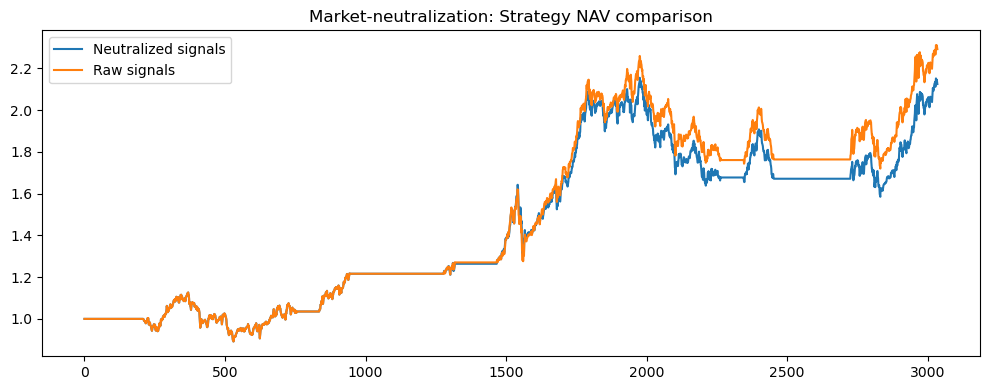

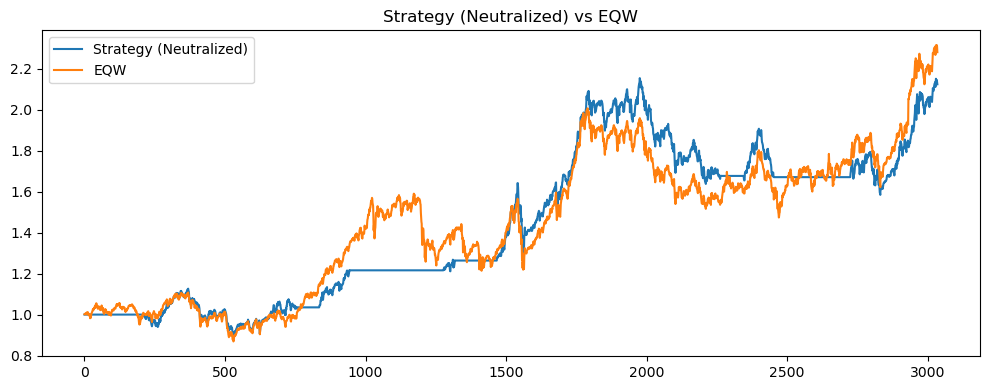

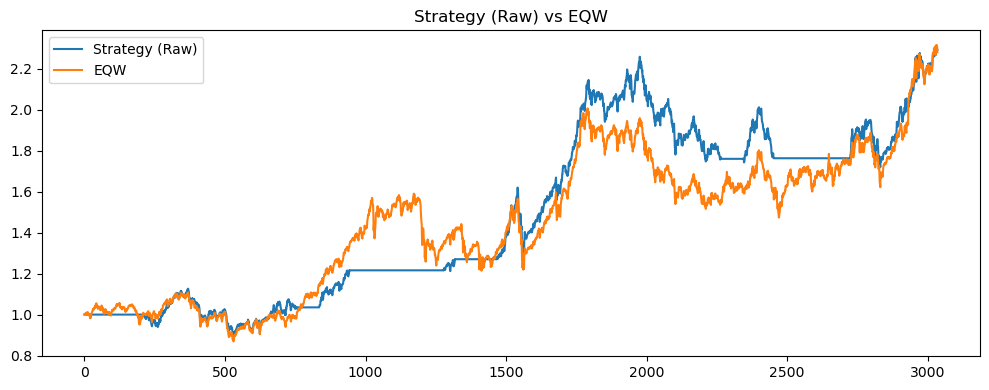

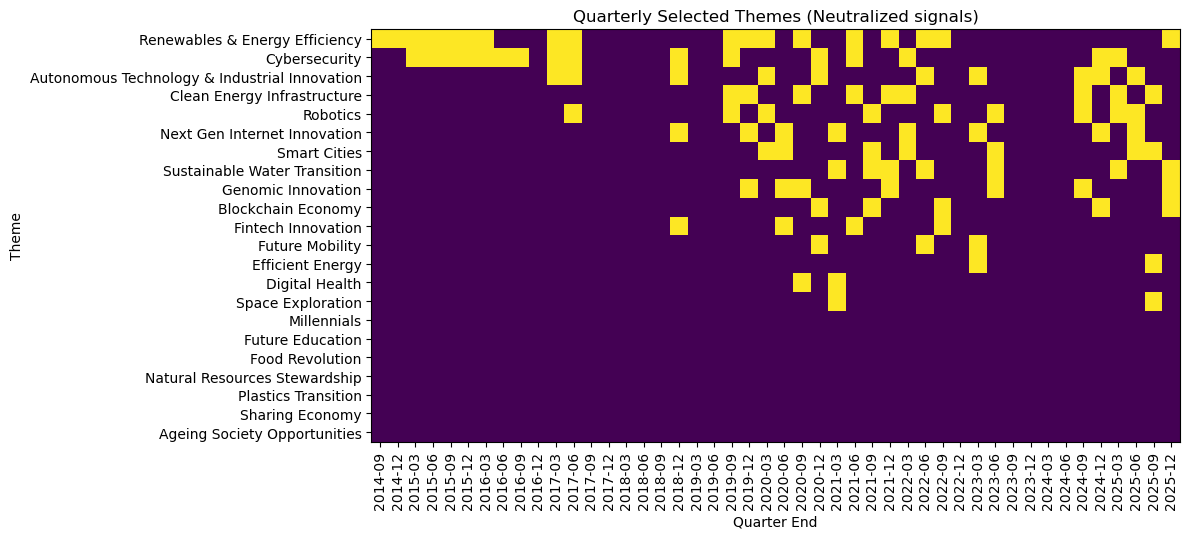

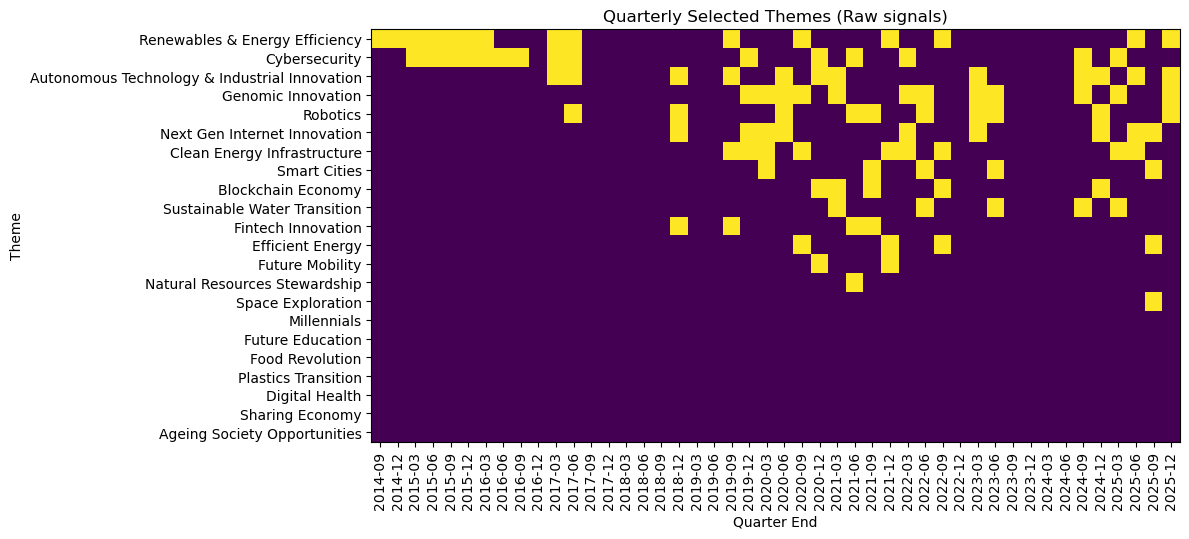

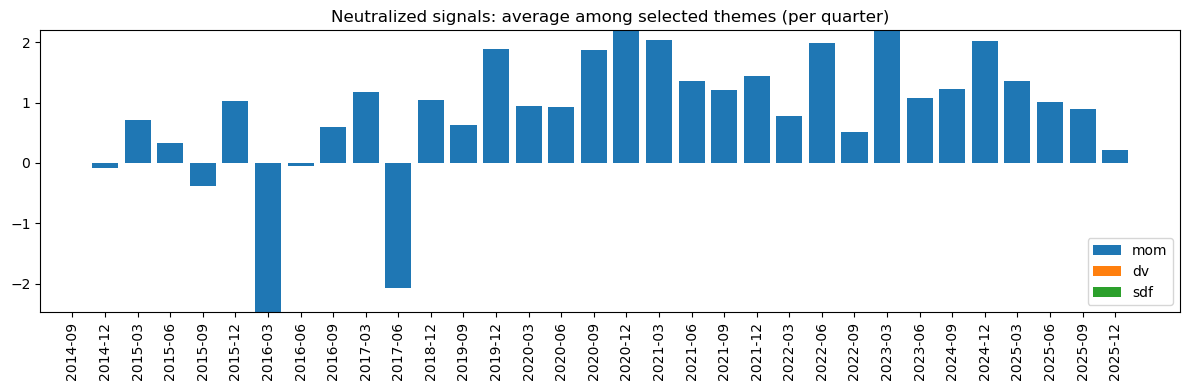

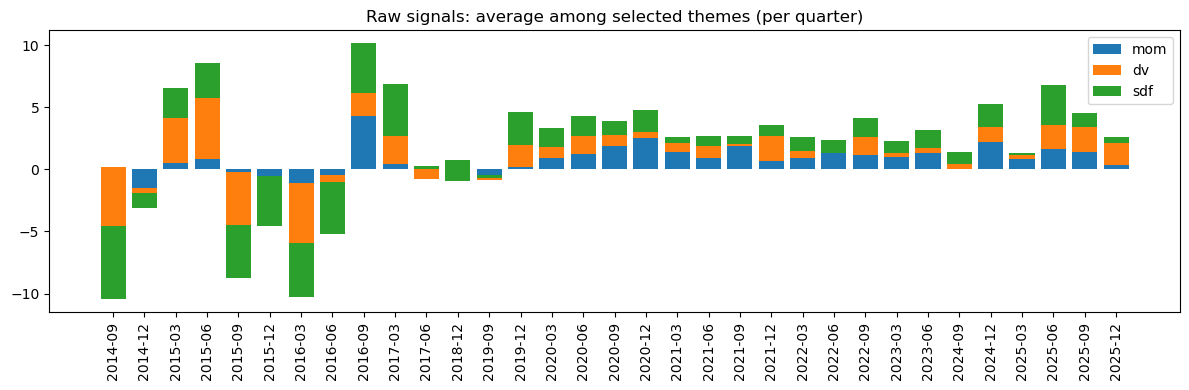

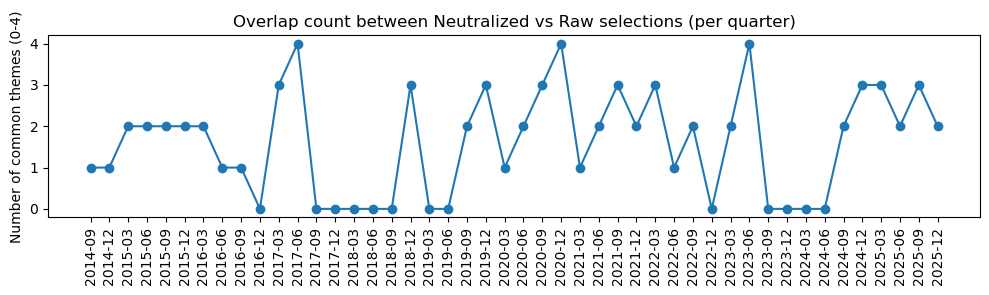

In [75]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#   (D) MSCI-like "2nd stage optimizer" for weights within selected themes
#   (E) 6M tie-break / fallback 강화 (score -> mom3 -> mom6)
#   (F) ETF factor regression (pseudo M/G/Q exposures) and inject into optimizer alpha
#   (1) NEW: Parent-index risk ratio constraint as explicit inequality constraint
#   (6) NEW: Embedding-based theme overlap suppression (selection + optimizer)
#
# Data: yfinance (Close, Volume)
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "Q"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63             # ~3 months trading days
LB_6M = 2 * LB_3M       # ~6 months
MIN_DV_3M = 3_000_000   # $/day

# market neutralization (for SIGNALS only)
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# risk targeting (portfolio-level overlay)
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

# optimizer controls (2nd stage)
USE_WEIGHT_OPTIMIZER = True
W_MAX = 0.25
COV_WIN = 63
COV_SHRINK = 0.10
GAMMA_RISK = 10.0
LAMBDA_TURN = 1.0

# (1) NEW: parent-index risk ratio constraint (explicit inequality)
USE_PARENT_RISK_CONSTRAINT = True
PARENT_RISK_RATIO_MAX = 1.00   # <= 1.0 : keep risk <= parent risk (tighten if desired)

# (6) NEW: embedding overlap suppression
USE_EMBED_DIVERSIFICATION = True

# selection-side (MMR)
EMBED_SELECT_LAMBDA = 0.50     # larger => stronger diversity at selection
EMBED_SELECT_MIN_CAND = 8      # apply MMR only if enough candidates

# optimizer-side (quadratic penalty)
GAMMA_SIM = 2.0                # strength of similarity co-holding penalty
SIM_DIAG_ZERO = True

# embedding method
EMBED_METHOD = "auto"          # "auto" | "tfidf" | "sbert"
SBERT_MODEL = "all-MiniLM-L6-v2"  # used if sentence_transformers available

# ---- factor regression (pseudo M/G/Q) ----
USE_STYLE_ALPHA = True
FACTOR_ETFS = {
    "M": "MTUM",   # Momentum
    "G": "IWF",    # Growth (alt: VUG)
    "Q": "QUAL",   # Quality
}
STYLE_WIN = 252
STYLE_MIN_OBS = 126
STYLE_WEIGHT = 0.50
SCORE_WEIGHT = 1.00
STYLE_WINSOR_K = 3.0
STYLE_TIEBREAK = True

PLOT = True
EPS = 1e-12


# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

def project_to_capped_simplex(v: np.ndarray, z: float = 1.0, ub: float = 1.0) -> np.ndarray:
    v = np.asarray(v, float).ravel()
    n = v.size
    ub = float(ub)

    if z > n * ub + 1e-12:
        w = np.ones(n) * ub
        return w / w.sum() * z

    lo = v.min() - ub
    hi = v.max()

    for _ in range(80):
        tau = 0.5 * (lo + hi)
        w = np.clip(v - tau, 0.0, ub)
        s = w.sum()
        if s > z:
            lo = tau
        else:
            hi = tau

    w = np.clip(v - 0.5 * (lo + hi), 0.0, ub)
    s = w.sum()
    if s <= 0:
        k = int(np.floor(z / ub))
        w = np.zeros(n)
        if k > 0:
            w[:k] = ub
        rem = z - w.sum()
        if rem > 0 and k < n:
            w[k] = min(ub, rem)
        return w
    return w * (z / s)

def shrink_cov(S: np.ndarray, shrink: float = 0.1, eps: float = 1e-8) -> np.ndarray:
    S = np.asarray(S, float)
    D = np.diag(np.diag(S))
    out = (1.0 - shrink) * S + shrink * D
    out = out + eps * np.eye(out.shape[0])
    return out

def make_psd(M: np.ndarray, eps: float = 1e-10) -> np.ndarray:
    """Shift diagonal to ensure PSD (for stability when using similarity penalties)."""
    M = 0.5 * (M + M.T)
    try:
        w = np.linalg.eigvalsh(M)
        m = float(w.min())
        if m < 0:
            M = M + (-m + eps) * np.eye(M.shape[0])
    except Exception:
        M = M + eps * np.eye(M.shape[0])
    return M

def cosine_sim_matrix(E: np.ndarray) -> np.ndarray:
    E = np.asarray(E, float)
    nrm = np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    U = E / nrm
    return U @ U.T


# ----------------------------
# 2.1) (6) Theme embeddings & similarity
# ----------------------------
def build_theme_texts(theme_names):
    # minimal deterministic text: theme name + tickers
    texts = []
    for th in theme_names:
        tks = THEME_ETFS.get(th, [])
        texts.append(f"{th} | tickers: {' '.join(tks)}")
    return texts

def compute_theme_embeddings(theme_names, method="auto"):
    texts = build_theme_texts(theme_names)

    if method == "auto":
        # try SBERT, else TF-IDF
        try:
            import sentence_transformers  # noqa: F401
            method_use = "sbert"
        except Exception:
            method_use = "tfidf"
    else:
        method_use = method

    if method_use == "sbert":
        try:
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer(SBERT_MODEL)
            E = model.encode(texts, normalize_embeddings=True)
            return np.asarray(E, float)
        except Exception:
            # fallback
            method_use = "tfidf"

    if method_use == "tfidf":
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            vec = TfidfVectorizer(ngram_range=(1, 2), min_df=1, stop_words="english")
            X = vec.fit_transform(texts)
            E = X.toarray().astype(float)
            return E
        except Exception:
            # final fallback: one-hot (weak, but safe)
            E = np.eye(len(texts), dtype=float)
            return E

    # default fallback
    return np.eye(len(texts), dtype=float)

def build_theme_similarity(theme_names):
    E = compute_theme_embeddings(theme_names, method=EMBED_METHOD)
    S = cosine_sim_matrix(E)
    if SIM_DIAG_ZERO:
        np.fill_diagonal(S, 0.0)
    # clip numeric noise
    S = np.clip(S, -1.0, 1.0)
    return S


# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume


# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv


# ----------------------------
# 5) Market neutralization (signals only)
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out


# ----------------------------
# 6) MMS-like scores + decomposition + mom3/mom6 levels
# ----------------------------
def compute_month_end_scores_with_decomp_and_mom_levels(
    ret_for_signals: pd.DataFrame,
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score, rows_mom3, rows_mom6, rows_comp = [], [], [], []

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                 # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)     # prev 3m
        w6 = slice(loc - 2 * lb_3m + 1, loc + 1)             # last 6m

        # mom levels (risk-adjusted)
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom3 = R0 / (S0 + eps)

        R6 = (1.0 + ret_for_signals.iloc[w6]).prod(axis=0) - 1.0
        S6 = ret_for_signals.iloc[w6].std(axis=0, ddof=0)
        mom6 = R6 / (S6 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom3, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cs-z each
        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        # contributions
        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)
        score = winsorize(score, 3.0).round(1)

        rows_score.append(score.rename(t))
        rows_mom3.append(mom3.rename(t))
        rows_mom6.append(mom6.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom3_m  = pd.DataFrame(rows_mom3).sort_index()
    mom6_m  = pd.DataFrame(rows_mom6).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom3_m, mom6_m, comp_m


# ----------------------------
# 7) Style alpha via factor ETF regression (pseudo M/G/Q exposures)
# ----------------------------
def rolling_factor_betas_month_end(
    y_ret: pd.DataFrame,
    X_ret: pd.DataFrame,
    win: int = 252,
    min_obs: int = 126
):
    idx = y_ret.index.intersection(X_ret.index)
    Y = y_ret.reindex(idx)
    X = X_ret.reindex(idx)

    month_ends = Y.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    betas_rows = []
    X_cols = list(X.columns)
    k = len(X_cols)
    if k < 2:
        betas_m = pd.DataFrame(columns=["beta_M","beta_G","beta_Q"])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    for t in month_ends:
        loc = idx.get_loc(t)
        start = loc - win + 1
        if start < 0:
            continue
        Xw = X.iloc[start:loc+1].copy()
        Xmat = np.column_stack([np.ones(len(Xw))] + [Xw[c].values for c in X_cols])

        for theme in Y.columns:
            yw = Y[theme].iloc[start:loc+1].values
            mask = np.isfinite(yw)
            for c in X_cols:
                mask = mask & np.isfinite(Xw[c].values)
            if mask.sum() < min_obs:
                continue
            A = Xmat[mask]
            b = yw[mask]
            coef, *_ = np.linalg.lstsq(A, b, rcond=None)
            betas = coef[1:]
            row = {"date": t, "theme": theme}
            for j, c in enumerate(X_cols):
                row[f"beta_{c}"] = float(betas[j])
            betas_rows.append(row)

    if len(betas_rows) == 0:
        betas_m = pd.DataFrame(columns=[f"beta_{c}" for c in X_cols])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    betas_m = pd.DataFrame(betas_rows).set_index(["date","theme"]).sort_index()

    style_alpha_rows = []
    for d in betas_m.index.get_level_values(0).unique().sort_values():
        sub = betas_m.loc[d]
        zcols = []
        for c in [f"beta_{x}" for x in X_cols]:
            zc = zscore_cs(sub[c])
            zcols.append(zc)
        zmat = pd.concat(zcols, axis=1)
        zmat.columns = X_cols
        a = zmat.mean(axis=1)
        a = winsorize(a, STYLE_WINSOR_K)
        style_alpha_rows.append(a.rename(d))

    style_alpha_m = pd.DataFrame(style_alpha_rows).sort_index()
    style_alpha_m = style_alpha_m.reindex(columns=Y.columns)
    return betas_m, style_alpha_m


# ----------------------------
# 8) Covariance helper
# ----------------------------
def compute_cov_at_date(theme_ret_trade: pd.DataFrame, t: pd.Timestamp, win: int = 63):
    idx = theme_ret_trade.index
    t0 = safe_get_loc(idx, t, method="ffill")
    if t0 is None:
        return None
    loc = idx.get_loc(t0)
    if loc < win:
        return None
    X = theme_ret_trade.iloc[loc - win + 1: loc + 1]
    X = X.dropna(axis=1, how="all").fillna(0.0)
    if X.shape[1] < 2:
        return None
    return X.cov(ddof=0)


# ----------------------------
# 9) (1)+(6) Optimizer within selected themes
# ----------------------------
def optimize_weights_within_selected(
    alpha_vec: pd.Series,              # objective alpha (score + style)
    cov_mat: np.ndarray,
    w_prev: np.ndarray,
    w_max: float = 0.25,
    gamma_risk: float = 10.0,
    lambda_turn: float = 1.0,
    # (1) parent risk constraint inputs
    use_parent_risk_constraint: bool = True,
    parent_var: float = None,   # parent predicted variance (scalar)
    parent_risk_ratio_max: float = 1.0,
    # (6) similarity penalty
    sim_penalty_mat: np.ndarray = None,
    gamma_sim: float = 0.0,
    use_scipy: bool = True
) -> np.ndarray:
    a = np.asarray(alpha_vec.values, float)
    n = a.size
    Sigma = np.asarray(cov_mat, float)
    w_prev = np.asarray(w_prev, float).ravel()
    if w_prev.size != n:
        w_prev = np.ones(n) / n

    w0 = project_to_capped_simplex(w_prev, z=1.0, ub=w_max)

    # effective quadratic term (risk + similarity penalty)
    Q = Sigma.copy()
    if sim_penalty_mat is not None and gamma_sim > 0:
        P = np.asarray(sim_penalty_mat, float)
        P = 0.5 * (P + P.T)
        if SIM_DIAG_ZERO:
            np.fill_diagonal(P, 0.0)
        # ensure PSD-ish for stability
        P = make_psd(P, eps=1e-10)
        Q = Q + (gamma_sim / max(gamma_risk, 1e-12)) * P
    Q = make_psd(Q, eps=1e-10)

    # parent risk cap
    risk_cap = None
    if use_parent_risk_constraint and (parent_var is not None) and np.isfinite(parent_var) and parent_var > 0:
        risk_cap = (float(parent_risk_ratio_max) ** 2) * float(parent_var)

    if use_scipy:
        try:
            from scipy.optimize import minimize

            def obj(w):
                w = np.asarray(w, float)
                ret_term = -float(np.dot(a, w))
                risk_term = float(gamma_risk * (w @ Q @ w))
                turn_term = float(lambda_turn * np.sum((w - w_prev) ** 2))
                return ret_term + risk_term + turn_term

            def grad(w):
                w = np.asarray(w, float)
                g = (-a + 2.0 * gamma_risk * (Q @ w) + 2.0 * lambda_turn * (w - w_prev))
                return g

            cons = [{"type": "eq",
                     "fun": lambda w: np.sum(w) - 1.0,
                     "jac": lambda w: np.ones_like(w)}]

            # (1) explicit inequality: w'Qw <= risk_cap
            if risk_cap is not None:
                cons.append({
                    "type": "ineq",
                    "fun": lambda w, rc=risk_cap: float(rc - (np.asarray(w) @ Q @ np.asarray(w))),
                    "jac": lambda w: -2.0 * (Q @ np.asarray(w))
                })

            bnds = [(0.0, w_max) for _ in range(n)]

            res = minimize(
                obj, w0, jac=grad, method="SLSQP",
                bounds=bnds, constraints=cons,
                options={"maxiter": 300, "ftol": 1e-12, "disp": False}
            )
            w = np.asarray(res.x, float)
            w = project_to_capped_simplex(w, z=1.0, ub=w_max)
            return w
        except Exception:
            pass

    # fallback: projected GD (no inequality support). We keep it as last resort.
    w = w0.copy()
    lr = 0.05
    for _ in range(400):
        g = (-a + 2.0 * gamma_risk * (Q @ w) + 2.0 * lambda_turn * (w - w_prev))
        w = w - lr * g
        w = project_to_capped_simplex(w, z=1.0, ub=w_max)
        # crude projection to satisfy risk cap (scale-down if violated)
        if risk_cap is not None:
            v = float(w @ Q @ w)
            if v > risk_cap + 1e-12:
                s = np.sqrt(risk_cap / max(v, 1e-12))
                w = w * s
                w = project_to_capped_simplex(w, z=1.0, ub=w_max)
    return w


# ----------------------------
# 10) (1)+(6) Liquidity filter + quarterly top-k + fallback + optimizer
# ----------------------------
def mmr_select(rank_df: pd.DataFrame,
               sim_df: pd.DataFrame,
               top_k: int,
               lambda_mmr: float = 0.5):
    """
    Greedy MMR:
      argmax_i [ base_i - lambda * max_{j in selected} sim(i,j) ]
    base_i is rank_df["base"].
    """
    cand = rank_df.dropna(subset=["base"]).copy()
    if cand.empty:
        return []

    # start with best base
    cand = cand.sort_values("base", ascending=False, kind="mergesort")
    pick = [cand.index[0]]

    while len(pick) < top_k and len(pick) < len(cand.index):
        best_name, best_val = None, -1e100
        for name in cand.index:
            if name in pick:
                continue
            # max similarity to current pick set
            sims = [float(sim_df.loc[name, j]) for j in pick if (name in sim_df.index and j in sim_df.columns)]
            max_sim = max(sims) if len(sims) else 0.0
            val = float(cand.loc[name, "base"]) - float(lambda_mmr) * max_sim
            if val > best_val:
                best_val = val
                best_name = name
        if best_name is None:
            break
        pick.append(best_name)
    return pick[:top_k]


def build_quarterly_weights(
    score_m,
    mom3_m,
    mom6_m,
    style_alpha_m,
    theme_dv,
    theme_ret_trade,
    theme_sim: pd.DataFrame = None,   # (6)
    top_k=TOP_K,
    lb_3m=LB_3M,
    min_dv_3m=MIN_DV_3M,
    use_optimizer: bool = True,
    w_max: float = W_MAX,
    cov_win: int = COV_WIN,
    cov_shrink: float = COV_SHRINK,
    gamma_risk: float = GAMMA_RISK,
    lambda_turn: float = LAMBDA_TURN,
    # (1)
    use_parent_risk_constraint: bool = True,
    parent_risk_ratio_max: float = 1.0,
    # (6)
    use_embed_diversification: bool = True,
    embed_select_lambda: float = 0.5,
    gamma_sim: float = 0.0
):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom3  = mom3_m.reindex(q_end)
    q_mom6  = mom6_m.reindex(q_end)
    q_style = None if style_alpha_m is None else style_alpha_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)
    w_prev_full = np.zeros(Wq.shape[1], dtype=float)

    # similarity lookup
    if theme_sim is not None:
        theme_sim = theme_sim.reindex(index=Wq.columns, columns=Wq.columns).fillna(0.0)

    for t in q_end:
        s = q_score.loc[t].copy()
        m3 = q_mom3.loc[t].copy()
        m6 = q_mom6.loc[t].copy()
        st = None if q_style is None else q_style.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        eligible = list(Wq.columns[dv_ok.fillna(False).values])

        s[~dv_ok] = np.nan
        m3[~dv_ok] = np.nan
        m6[~dv_ok] = np.nan
        if st is not None:
            st[~dv_ok] = np.nan

        # ranking table
        rank = pd.DataFrame({"score": s, "mom3": m3, "mom6": m6})
        if st is not None and STYLE_TIEBREAK:
            rank["style"] = st
        else:
            rank["style"] = np.nan

        # base sorting score with tie-break (lexicographic encoded into "base")
        # primary: score, then style, mom3, mom6
        base = rank["score"].copy()
        if STYLE_TIEBREAK and st is not None:
            base = base + 1e-3 * rank["style"].fillna(0.0)
        base = base + 1e-4 * rank["mom3"].fillna(0.0) + 1e-5 * rank["mom6"].fillna(0.0)
        rank["base"] = base

        # ---- Step1: pick top_k with tie-break (+ optional embedding diversity)
        pick = []
        cand = rank[rank["score"].notna()].copy()

        if len(cand) > 0:
            if (use_embed_diversification and USE_EMBED_DIVERSIFICATION and theme_sim is not None
                and len(cand) >= max(top_k, EMBED_SELECT_MIN_CAND)):
                sim_sub = theme_sim.loc[cand.index, cand.index]
                pick = mmr_select(cand[["base"]], sim_sub, top_k=top_k, lambda_mmr=embed_select_lambda)
            else:
                sort_cols = ["score"]
                asc = [False]
                if STYLE_TIEBREAK and st is not None:
                    sort_cols += ["style"]
                    asc += [False]
                sort_cols += ["mom3", "mom6"]
                asc += [False, False]
                cand = cand.sort_values(sort_cols, ascending=asc, kind="mergesort")
                pick = list(cand.head(top_k).index)

        # ---- Step2: fallback fill if < top_k (mom3 -> mom6, optional style)
        if len(pick) < top_k:
            rank_mom = rank[rank["mom3"].notna()].copy()
            if STYLE_TIEBREAK and st is not None:
                rank_mom = rank_mom.sort_values(["mom3", "style", "mom6"], ascending=[False, False, False], kind="mergesort")
            else:
                rank_mom = rank_mom.sort_values(["mom3", "mom6"], ascending=[False, False], kind="mergesort")
            for name in rank_mom.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) == 0:
            continue

        # ---- Step3: assign weights
        if (not use_optimizer) or (len(pick) == 1):
            Wq.loc[t, pick] = 1.0 / len(pick)
        else:
            # alpha = SCORE_WEIGHT * score + STYLE_WEIGHT * style_alpha
            score_vec = s.reindex(pick)

            # fill NaN score among picked via mom fallback
            if score_vec.isna().any():
                m3p = m3.reindex(pick).fillna(0.0)
                m6p = m6.reindex(pick).fillna(0.0)
                alpha_fill = zscore_cs(m3p) + 0.25 * zscore_cs(m6p)
                score_vec = score_vec.fillna(alpha_fill)

            if USE_STYLE_ALPHA and (st is not None):
                style_vec = st.reindex(pick).fillna(0.0)
            else:
                style_vec = pd.Series(0.0, index=pick)

            alpha_vec = SCORE_WEIGHT * score_vec + STYLE_WEIGHT * style_vec

            # covariance of selected
            S = compute_cov_at_date(theme_ret_trade[pick], t, win=cov_win)
            if S is None:
                Wq.loc[t, pick] = 1.0 / len(pick)
            else:
                Sigma = shrink_cov(S.values, shrink=cov_shrink, eps=1e-8)

                # (1) parent variance (eligible equal-weight as proxy for "parent index")
                parent_var = None
                if use_parent_risk_constraint and USE_PARENT_RISK_CONSTRAINT:
                    if len(eligible) >= 2:
                        S_all = compute_cov_at_date(theme_ret_trade[eligible], t, win=cov_win)
                        if S_all is not None:
                            Sig_all = shrink_cov(S_all.values, shrink=cov_shrink, eps=1e-8)
                            w_eq = np.ones(len(eligible), dtype=float) / len(eligible)
                            parent_var = float(w_eq @ Sig_all @ w_eq)

                # prev weights
                prev_series = pd.Series(w_prev_full, index=Wq.columns)
                w_prev_sub = prev_series.reindex(pick).values

                # (6) similarity penalty matrix on selected
                sim_mat = None
                if gamma_sim > 0 and theme_sim is not None:
                    sim_mat = theme_sim.loc[pick, pick].values

                w_opt = optimize_weights_within_selected(
                    alpha_vec=alpha_vec,
                    cov_mat=Sigma,
                    w_prev=w_prev_sub,
                    w_max=w_max,
                    gamma_risk=gamma_risk,
                    lambda_turn=lambda_turn,
                    use_parent_risk_constraint=use_parent_risk_constraint and USE_PARENT_RISK_CONSTRAINT,
                    parent_var=parent_var,
                    parent_risk_ratio_max=parent_risk_ratio_max,
                    sim_penalty_mat=sim_mat,
                    gamma_sim=gamma_sim,
                    use_scipy=True
                )
                Wq.loc[t, pick] = w_opt

        w_prev_full = Wq.loc[t].values.copy()

    return Wq


# ----------------------------
# 11) Expand weights + backtest + risk targeting overlay
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting(port_gross_ret, turnover, fee_bps,
                                target_vol_ann=TARGET_VOL_ANN, vol_lookback=VOL_LOOKBACK, max_leverage=MAX_LEVERAGE):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(gross, turnover, fee_bps=0.0)
    return bt


# ----------------------------
# 12) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    sel = (Wq > 0).astype(int)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]
    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    q_end = Wq.index
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        if len(comp_dates) == 0:
            break
        i = comp_dates.get_indexer([t], method="ffill")[0]
        if i < 0:
            continue
        t_comp = comp_dates[i]

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        return df.sort_values(["date","theme"])


# ----------------------------
# 13) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool, theme_sim: pd.DataFrame):
    theme_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst})
    factor_etfs = sorted(set(FACTOR_ETFS.values())) if USE_STYLE_ALPHA else []
    all_etfs = sorted(set(theme_etfs + factor_etfs + [MKT_TICKER]))

    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes
    close_theme = close.reindex(columns=theme_etfs).dropna(how="all")
    vol_theme   = volume.reindex(columns=theme_etfs).fillna(0.0)
    theme_ret_trade, theme_dv = build_theme_series(close_theme, vol_theme)

    # signals returns (neutralized or raw)
    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    # MMS-like scores + mom3/mom6
    score_m, mom3_m, mom6_m, comp_m = compute_month_end_scores_with_decomp_and_mom_levels(
        ret_for_signals, theme_dv, lb_3m=LB_3M
    )

    # Style alpha (pseudo M/G/Q exposures)
    style_alpha_m = None
    betas_m = None
    if USE_STYLE_ALPHA:
        fac_cols = [FACTOR_ETFS[k] for k in ["M","G","Q"]]
        fac_cols_avail = [c for c in fac_cols if c in close.columns]
        if len(fac_cols_avail) >= 2:
            fac_close = close[fac_cols_avail].dropna(how="all").ffill()
            fac_ret = fac_close.pct_change()
            rename_map = {}
            for k, tkr in FACTOR_ETFS.items():
                if tkr in fac_ret.columns:
                    rename_map[tkr] = k
            fac_ret = fac_ret.rename(columns=rename_map)
            fac_ret = fac_ret[[c for c in ["M","G","Q"] if c in fac_ret.columns]]

            betas_m, style_alpha_m = rolling_factor_betas_month_end(
                y_ret=theme_ret_trade,
                X_ret=fac_ret,
                win=STYLE_WIN,
                min_obs=STYLE_MIN_OBS
            )

    Wq = build_quarterly_weights(
        score_m=score_m,
        mom3_m=mom3_m,
        mom6_m=mom6_m,
        style_alpha_m=style_alpha_m,
        theme_dv=theme_dv,
        theme_ret_trade=theme_ret_trade,
        theme_sim=theme_sim,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M,
        use_optimizer=USE_WEIGHT_OPTIMIZER,
        w_max=W_MAX,
        cov_win=COV_WIN,
        cov_shrink=COV_SHRINK,
        gamma_risk=GAMMA_RISK,
        lambda_turn=LAMBDA_TURN,
        use_parent_risk_constraint=USE_PARENT_RISK_CONSTRAINT,
        parent_risk_ratio_max=PARENT_RISK_RATIO_MAX,
        use_embed_diversification=USE_EMBED_DIVERSIFICATION,
        embed_select_lambda=EMBED_SELECT_LAMBDA,
        gamma_sim=GAMMA_SIM
    )

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom3_m": mom3_m,
        "mom6_m": mom6_m,
        "comp_m": comp_m,
        "betas_m": betas_m,
        "style_alpha_m": style_alpha_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
    ann_vol = annualize_vol(r)
    sharpe = ann_ret / (ann_vol + 1e-12)
    mdd = max_drawdown(bt_df["nav"])
    avg_turn = float(bt_df["turnover"].mean())
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1])
    }, name=name)


# ----------------------------
# 14) Execute
# ----------------------------
if __name__ == "__main__":
    # (6) Build theme similarity once
    theme_names = list(THEME_ETFS.keys())
    sim = None
    if USE_EMBED_DIVERSIFICATION:
        S = build_theme_similarity(theme_names)
        sim = pd.DataFrame(S, index=theme_names, columns=theme_names)

    out_neut = run_pipeline(use_neutralization=True, theme_sim=sim)
    out_raw  = run_pipeline(use_neutralization=False, theme_sim=sim)

    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals; optimized weights)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals; optimized weights)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    if USE_STYLE_ALPHA:
        if out_raw["style_alpha_m"] is None or out_raw["style_alpha_m"].dropna(how="all").empty:
            print("\n[WARN] style_alpha_m is empty (factor ETFs missing or insufficient data).")
        else:
            print("\n[INFO] style_alpha_m computed. Example (last 3 rows):")
            print(out_raw["style_alpha_m"].tail(3))

    if PLOT:
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                                    ann_ret   ann_vol  \
Strategy (Neutralized signals; optimized weights)  0.064548  0.112832   
Strategy (Raw signals; optimized weights)          0.070300  0.114604   
EQW (All themes)                                   0.070859  0.143885   

                                                     sharpe    max_dd  \
Strategy (Neutralized signals; optimized weights)  0.572068 -0.264491   
Strategy (Raw signals; optimized weights)          0.613416 -0.238735   
EQW (All themes)                                   0.492469 -0.265593   

                                                   avg_turnover  final_nav  
Strategy (Neutralized signals; optimized weights)      0.014328   2.124593  
Strategy (Raw signals; optimized weights)              0.013340   2.267104  
EQW (All themes)                                       0.000000   2.281400  

[INFO] style_alpha_m computed. Example (last 3 rows):
            Ageing Society Opportu

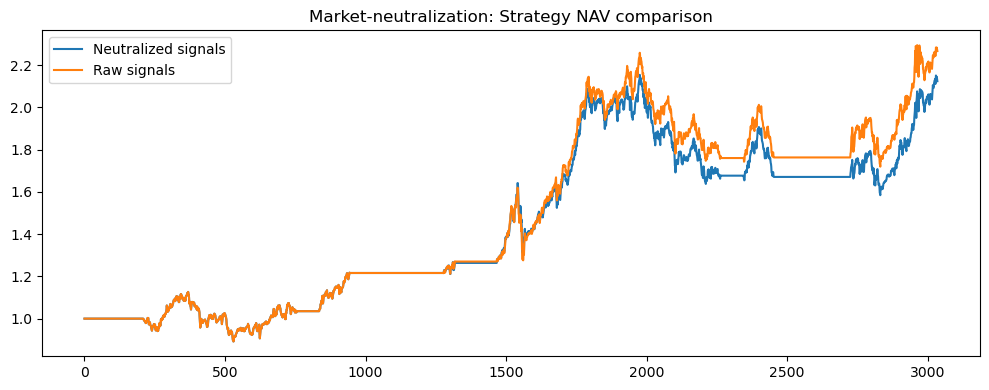

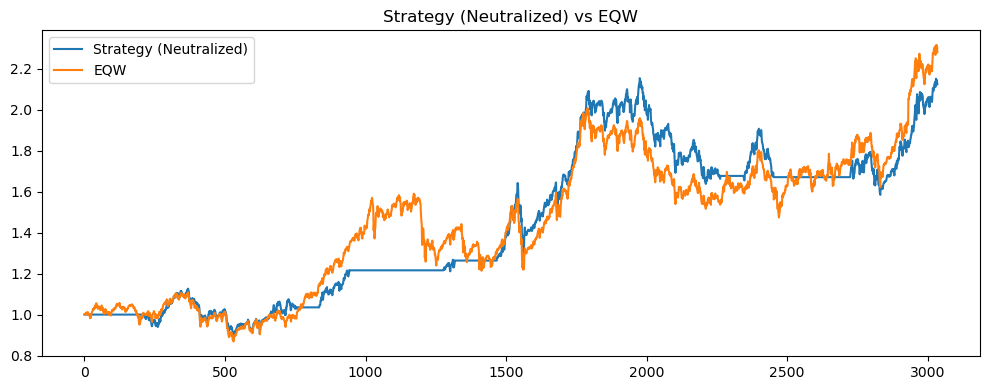

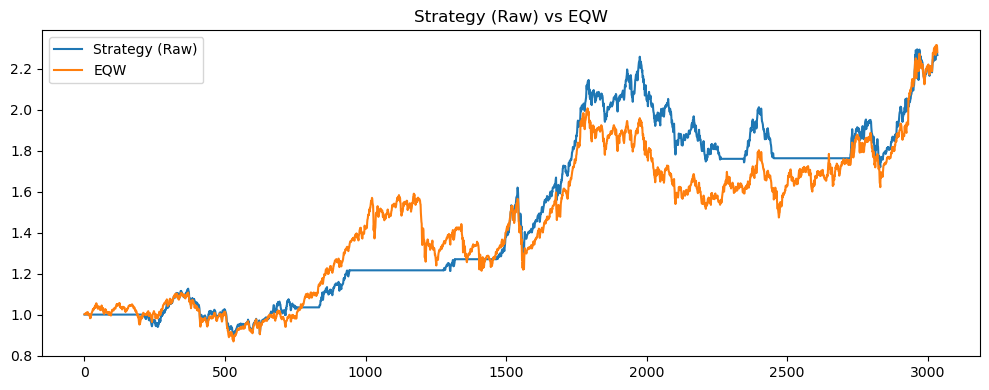

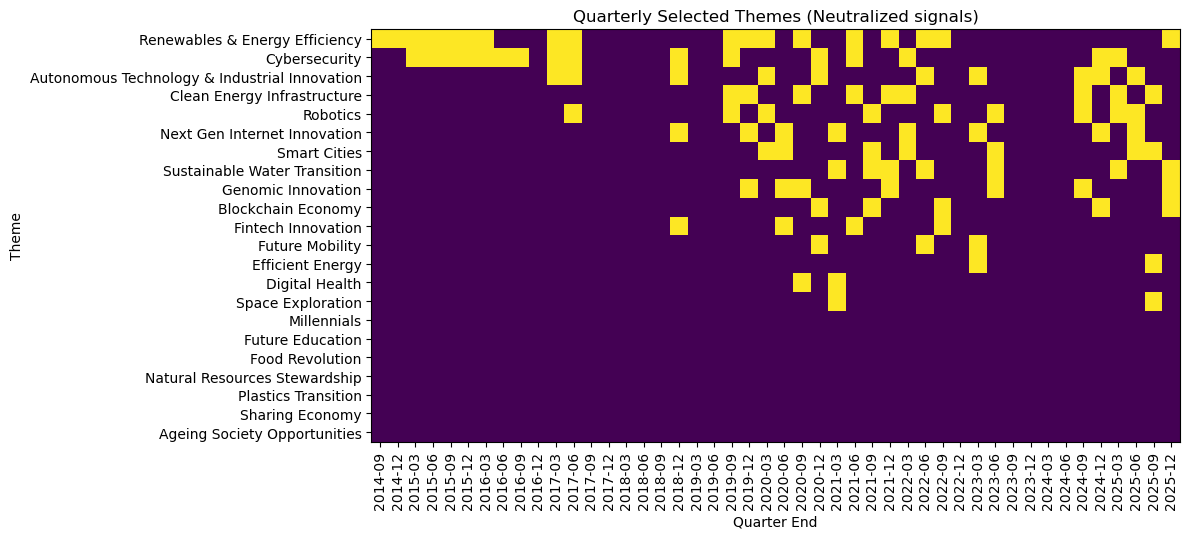

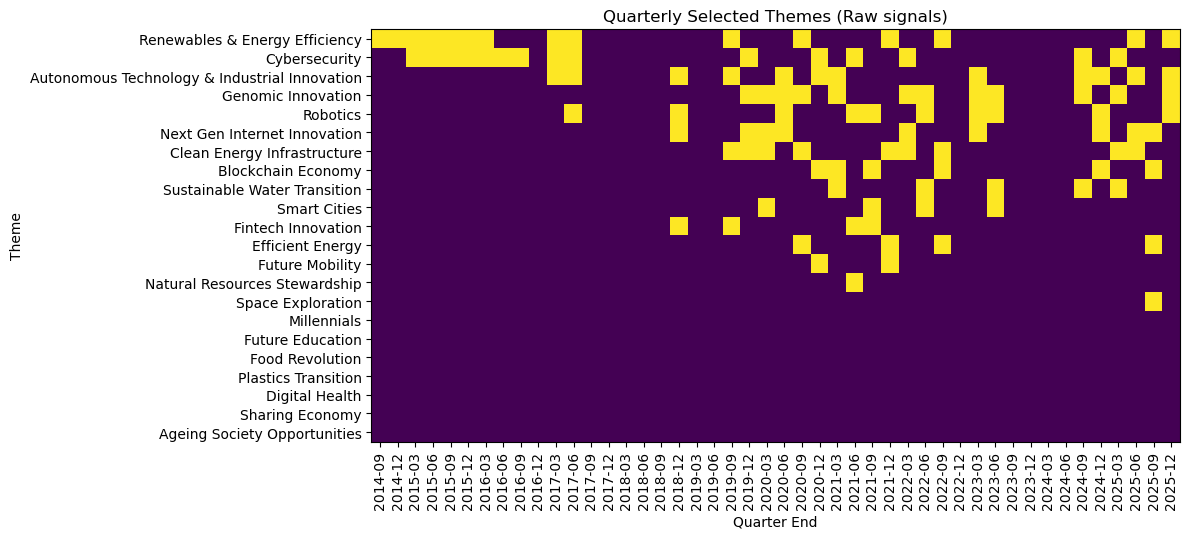

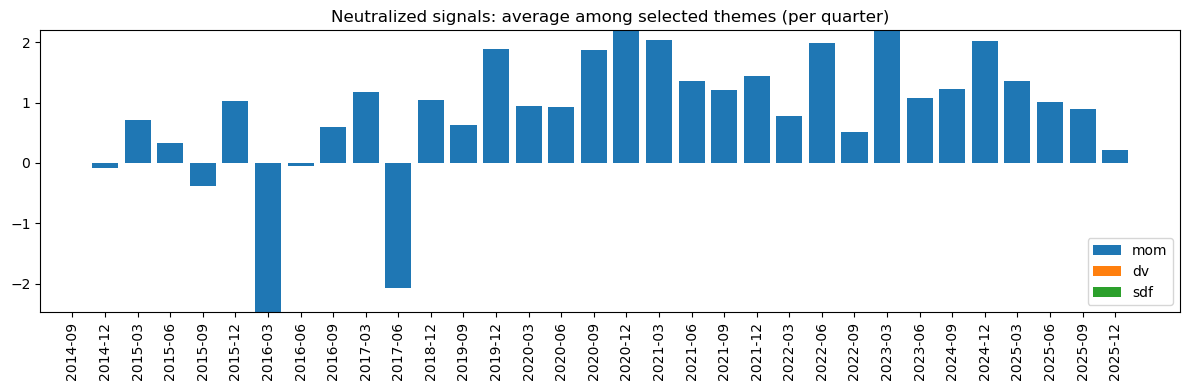

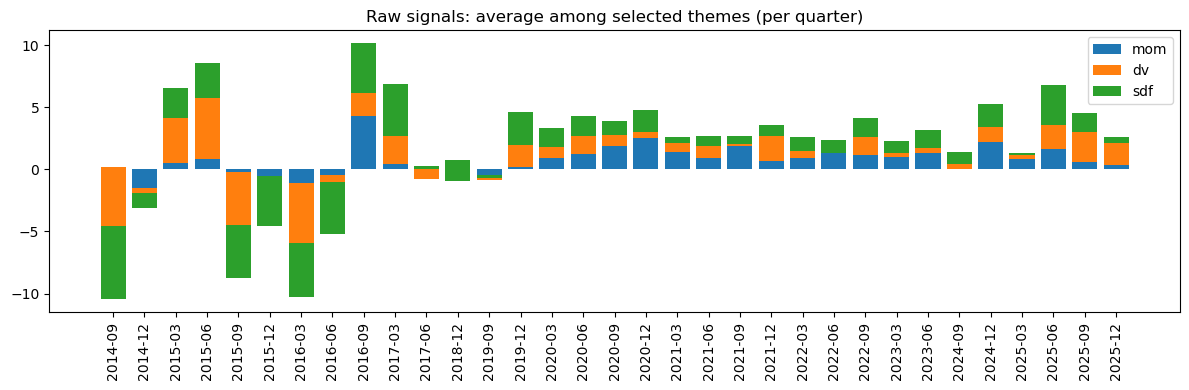

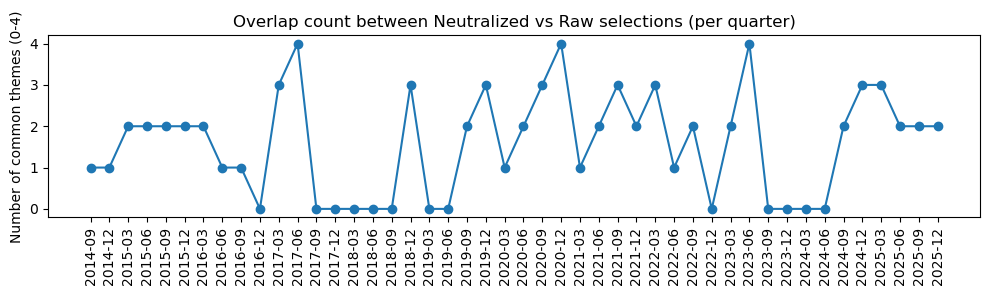

In [80]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#   (D) MSCI-like "2nd stage optimizer" for weights within selected themes
#   (E) 6M tie-break / fallback 강화 (score -> mom3 -> mom6)
#   (F) NEW: ETF factor regression (pseudo M/G/Q exposures) and inject into optimizer alpha
#
# Data: yfinance (Close, Volume)
# Signals:
#   - mom: 3m risk-adjusted momentum (changes last 3m vs prev 3m)  [MMS-like]
#   - dv : dollar-volume attention (changes)
#   - sdf: signed dollar-flow proxy (changes; sign from signal returns)
# Score: MMS-like -> cs-z per component -> sum -> re-z -> winsorize±3 -> round(0.1)
# Add-ons:
#   - execution lag
#   - liquidity filter (3m avg dollar volume)
#   - fallback to mom ranking (mom3 -> mom6)
#   - risk targeting (daily RV -> monthly fixed leverage)
#   - optional market neutralization (rolling beta vs SPY)
#   - NEW: style alpha from factor ETF regression (MTUM/IWF/QUAL) injected into optimizer alpha
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "Q"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63             # ~3 months trading days
LB_6M = 2 * LB_3M       # ~6 months
MIN_DV_3M = 3_000_000   # $/day

# market neutralization (for SIGNALS only)
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# risk targeting (portfolio-level)
TARGET_VOL_ANN = 0.12
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

# optimizer controls (2nd stage)
USE_WEIGHT_OPTIMIZER = True
W_MAX = 0.25
COV_WIN = 63
COV_SHRINK = 0.10
GAMMA_RISK = 10.0
LAMBDA_TURN = 1.0
GD_STEPS = 250
GD_LR = 0.05

# ---- NEW: factor regression (pseudo M/G/Q) ----
USE_STYLE_ALPHA = True
FACTOR_ETFS = {
    "M": "MTUM",   # Momentum
    "G": "IWF",    # Growth (alt: VUG)
    "Q": "QUAL",   # Quality
}
STYLE_WIN = 252          # rolling regression window (trading days)
STYLE_MIN_OBS = 126      # minimum obs to accept betas
STYLE_WEIGHT = 0.50      # weight on style_alpha in optimizer alpha
SCORE_WEIGHT = 1.00      # weight on MMS score in optimizer alpha
STYLE_WINSOR_K = 3.0     # winsorize style_alpha cross-sectionally at month-end
STYLE_TIEBREAK = True    # use style_alpha as extra tie-break in selection

PLOT = True
EPS = 1e-12

USE_ACTIVE_RISK = False


# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

def project_to_capped_simplex(v: np.ndarray, z: float = 1.0, ub: float = 1.0) -> np.ndarray:
    v = np.asarray(v, float).ravel()
    n = v.size
    ub = float(ub)

    if z > n * ub + 1e-12:
        w = np.ones(n) * ub
        return w / w.sum() * z

    lo = v.min() - ub
    hi = v.max()

    for _ in range(80):
        tau = 0.5 * (lo + hi)
        w = np.clip(v - tau, 0.0, ub)
        s = w.sum()
        if s > z:
            lo = tau
        else:
            hi = tau

    w = np.clip(v - 0.5 * (lo + hi), 0.0, ub)
    s = w.sum()
    if s <= 0:
        k = int(np.floor(z / ub))
        w = np.zeros(n)
        if k > 0:
            w[:k] = ub
        rem = z - w.sum()
        if rem > 0 and k < n:
            w[k] = min(ub, rem)
        return w
    return w * (z / s)

def shrink_cov(S: np.ndarray, shrink: float = 0.1, eps: float = 1e-8) -> np.ndarray:
    S = np.asarray(S, float)
    D = np.diag(np.diag(S))
    out = (1.0 - shrink) * S + shrink * D
    out = out + eps * np.eye(out.shape[0])
    return out


# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume


# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv


# ----------------------------
# 5) Market neutralization (signals only)
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out


# ----------------------------
# 6) MMS-like scores + decomposition + mom3/mom6 levels
# ----------------------------
def compute_month_end_scores_with_decomp_and_mom_levels(
    ret_for_signals: pd.DataFrame,
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score, rows_mom3, rows_mom6, rows_comp = [], [], [], []

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                 # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)     # prev 3m
        w6 = slice(loc - 2 * lb_3m + 1, loc + 1)             # last 6m

        # mom levels (risk-adjusted)
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom3 = R0 / (S0 + eps)

        R6 = (1.0 + ret_for_signals.iloc[w6]).prod(axis=0) - 1.0
        S6 = ret_for_signals.iloc[w6].std(axis=0, ddof=0)
        mom6 = R6 / (S6 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom3, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cs-z each
        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        # contributions
        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)
        score = winsorize(score, 3.0).round(1)

        rows_score.append(score.rename(t))
        rows_mom3.append(mom3.rename(t))
        rows_mom6.append(mom6.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom3_m  = pd.DataFrame(rows_mom3).sort_index()
    mom6_m  = pd.DataFrame(rows_mom6).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom3_m, mom6_m, comp_m


# ----------------------------
# 7) NEW: Style alpha via factor ETF regression (pseudo M/G/Q exposures)
# ----------------------------
def rolling_factor_betas_month_end(
    y_ret: pd.DataFrame,          # theme returns (daily)
    X_ret: pd.DataFrame,          # factor ETF returns (daily), columns = [M,G,Q]
    win: int = 252,
    min_obs: int = 126
):
    """
    Month-end rolling OLS betas with intercept:
      y = a + b'X + e
    Returns:
      betas_m: MultiIndex (date, theme) columns [beta_M, beta_G, beta_Q]
      style_alpha_m: month-end x theme (cross-sectional z of betas averaged)
    """
    idx = y_ret.index.intersection(X_ret.index)
    Y = y_ret.reindex(idx)
    X = X_ret.reindex(idx)

    # month ends based on idx
    month_ends = Y.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    betas_rows = []

    X_cols = list(X.columns)
    k = len(X_cols)
    if k < 2:
        # not enough factors
        betas_m = pd.DataFrame(columns=["beta_M","beta_G","beta_Q"])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    for t in month_ends:
        loc = idx.get_loc(t)
        start = loc - win + 1
        if start < 0:
            continue
        Xw = X.iloc[start:loc+1].copy()
        # build design matrix with intercept
        Xmat = np.column_stack([np.ones(len(Xw))] + [Xw[c].values for c in X_cols])

        for theme in Y.columns:
            yw = Y[theme].iloc[start:loc+1].values
            mask = np.isfinite(yw)
            for c in X_cols:
                mask = mask & np.isfinite(Xw[c].values)
            if mask.sum() < min_obs:
                continue
            A = Xmat[mask]
            b = yw[mask]
            # OLS via lstsq
            coef, *_ = np.linalg.lstsq(A, b, rcond=None)
            # coef[0]=intercept
            betas = coef[1:]
            row = {"date": t, "theme": theme}
            for j, c in enumerate(X_cols):
                row[f"beta_{c}"] = float(betas[j])
            betas_rows.append(row)

    if len(betas_rows) == 0:
        betas_m = pd.DataFrame(columns=[f"beta_{c}" for c in X_cols])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    betas_m = pd.DataFrame(betas_rows).set_index(["date","theme"]).sort_index()

    # build style alpha: cross-sectional z of betas each month-end, then average
    style_alpha_rows = []
    for d in betas_m.index.get_level_values(0).unique().sort_values():
        sub = betas_m.loc[d]
        # sub index: theme, columns: beta_*
        # cs-z each beta column
        zcols = []
        for c in [f"beta_{x}" for x in X_cols]:
            zc = zscore_cs(sub[c])
            zcols.append(zc)
        zmat = pd.concat(zcols, axis=1)
        zmat.columns = X_cols
        # average z across available factors
        a = zmat.mean(axis=1)
        a = winsorize(a, STYLE_WINSOR_K)
        style_alpha_rows.append(a.rename(d))

    style_alpha_m = pd.DataFrame(style_alpha_rows).sort_index()
    # align columns to all themes (missing -> NaN)
    style_alpha_m = style_alpha_m.reindex(columns=Y.columns)

    return betas_m, style_alpha_m


# ----------------------------
# 8) Optimizer within selected themes (2nd stage)
# ----------------------------
def optimize_weights_within_selected(
    score_vec: pd.Series,
    cov_mat: np.ndarray,
    w_prev: np.ndarray,
    w_max: float = 0.25,
    gamma_risk: float = 10.0,
    lambda_turn: float = 1.0,
    use_scipy: bool = True,
    w_bench: np.ndarray = None, 
    use_active_risk: bool = False
) -> np.ndarray:
    s = np.asarray(score_vec.values, float)
    n = s.size
    Sigma = np.asarray(cov_mat, float)
    w_prev = np.asarray(w_prev, float).ravel()
    if w_prev.size != n:
        w_prev = np.ones(n) / n

    if w_bench is None:
        w_bench = np.ones(n) / n
    w_bench = np.asarray(w_bench, float).ravel()

    w0 = project_to_capped_simplex(w_prev, z=1.0, ub=w_max)

    if use_scipy:
        try:
            from scipy.optimize import minimize

            def obj(w):
                w = np.asarray(w)
                ret_term = -np.dot(s, w)
                if use_active_risk:
                    a = (w - w_bench)
                    risk_term = gamma_risk * float(a @ Sigma @ a)
                else:
                    risk_term = gamma_risk * float(w @ Sigma @ w)
                turn_term = lambda_turn * float(np.sum((w - w_prev) ** 2))
                return ret_term + risk_term + turn_term

            def grad(w):
                w = np.asarray(w)
                return (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))

            cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0, "jac": lambda w: np.ones_like(w)}]
            bnds = [(0.0, w_max) for _ in range(n)]

            res = minimize(
                obj, w0, jac=grad, method="SLSQP",
                bounds=bnds, constraints=cons,
                options={"maxiter": 200, "ftol": 1e-12, "disp": False}
            )
            w = np.asarray(res.x, float)
            w = project_to_capped_simplex(w, z=1.0, ub=w_max)
            return w
        except Exception:
            pass

    # fallback: projected GD
    w = w0.copy()
    for _ in range(GD_STEPS):
        g = (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))
        w = w - GD_LR * g
        w = project_to_capped_simplex(w, z=1.0, ub=w_max)
    return w

def compute_cov_at_date(theme_ret_trade: pd.DataFrame, t: pd.Timestamp, win: int = 63):
    idx = theme_ret_trade.index
    t0 = safe_get_loc(idx, t, method="ffill")
    if t0 is None:
        return None
    loc = idx.get_loc(t0)
    if loc < win:
        return None
    X = theme_ret_trade.iloc[loc - win + 1: loc + 1]
    X = X.dropna(axis=1, how="all").fillna(0.0)
    if X.shape[1] < 2:
        return None
    return X.cov(ddof=0)


# ----------------------------
# 9) Liquidity filter + quarterly top-k + fallback + optimizer (+ style alpha injection)
# ----------------------------
def build_quarterly_weights(
    score_m,
    mom3_m,
    mom6_m,
    style_alpha_m,          # NEW (can be None)
    theme_dv,
    theme_ret_trade,
    top_k=TOP_K,
    lb_3m=LB_3M,
    min_dv_3m=MIN_DV_3M,
    use_optimizer: bool = True,
    w_max: float = W_MAX,
    cov_win: int = COV_WIN,
    cov_shrink: float = COV_SHRINK,
    gamma_risk: float = GAMMA_RISK,
    lambda_turn: float = LAMBDA_TURN
):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom3  = mom3_m.reindex(q_end)
    q_mom6  = mom6_m.reindex(q_end)
    q_style = None if style_alpha_m is None else style_alpha_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)
    w_prev_full = np.zeros(Wq.shape[1], dtype=float)

    for t in q_end:
        s = q_score.loc[t].copy()
        m3 = q_mom3.loc[t].copy()
        m6 = q_mom6.loc[t].copy()
        st = None if q_style is None else q_style.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m3[~dv_ok] = np.nan
        m6[~dv_ok] = np.nan
        if st is not None:
            st[~dv_ok] = np.nan

        # ranking table
        rank = pd.DataFrame({"score": s, "mom3": m3, "mom6": m6})
        if st is not None and STYLE_TIEBREAK:
            rank["style"] = st
        else:
            rank["style"] = np.nan

        # ---- Step1: pick top_k with tie-break
        # score -> (style) -> mom3 -> mom6
        pick = []
        rank_score = rank[rank["score"].notna()].copy()
        if len(rank_score) > 0:
            sort_cols = ["score"]
            asc = [False]
            if STYLE_TIEBREAK and st is not None:
                sort_cols += ["style"]
                asc += [False]
            sort_cols += ["mom3", "mom6"]
            asc += [False, False]

            rank_score = rank_score.sort_values(sort_cols, ascending=asc, kind="mergesort")
            pick = list(rank_score.head(top_k).index)

        # ---- Step2: fallback fill if < top_k
        if len(pick) < top_k:
            rank_mom = rank[rank["mom3"].notna()].copy()
            sort_cols = ["mom3", "mom6"]
            asc = [False, False]
            if STYLE_TIEBREAK and st is not None:
                # style used as extra info even in fallback (weakly)
                sort_cols = ["mom3", "style", "mom6"]
                asc = [False, False, False]
            rank_mom = rank_mom.sort_values(sort_cols, ascending=asc, kind="mergesort")
            for name in rank_mom.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) == 0:
            continue

        # ---- Step3: assign weights
        if (not use_optimizer) or (len(pick) == 1):
            Wq.loc[t, pick] = 1.0 / len(pick)
        else:
            # Build optimizer alpha (score_vec):
            #   alpha = SCORE_WEIGHT * score + STYLE_WEIGHT * style_alpha
            score_vec = s.reindex(pick)

            # fill NaN score among picked via mom fallback
            if score_vec.isna().any():
                m3p = m3.reindex(pick).fillna(0.0)
                m6p = m6.reindex(pick).fillna(0.0)
                alpha_fill = zscore_cs(m3p) + 0.25 * zscore_cs(m6p)
                score_vec = score_vec.fillna(alpha_fill)

            # style component
            if USE_STYLE_ALPHA and (st is not None):
                style_vec = st.reindex(pick)
                # if style missing, set 0 (neutral)
                style_vec = style_vec.fillna(0.0)
            else:
                style_vec = pd.Series(0.0, index=pick)

            alpha_vec = SCORE_WEIGHT * score_vec + STYLE_WEIGHT * style_vec

            # covariance from tradable theme returns
            S = compute_cov_at_date(theme_ret_trade[pick], t, win=cov_win)
            if S is None:
                Wq.loc[t, pick] = 1.0 / len(pick)
            else:
                Sigma = shrink_cov(S.values, shrink=cov_shrink, eps=1e-8)

                prev_series = pd.Series(w_prev_full, index=Wq.columns)
                w_prev_sub = prev_series.reindex(pick).values

                w_bench = np.ones(len(pick)) / len(pick)   # “親指数（等ウェイト）” 代替

                w_opt = optimize_weights_within_selected(
                    score_vec=alpha_vec,
                    cov_mat=Sigma,
                    w_prev=w_prev_sub,
                    w_max=w_max,
                    gamma_risk=gamma_risk,
                    lambda_turn=lambda_turn,
                    use_scipy=True,
                    w_bench=w_bench, 
                    use_active_risk=USE_ACTIVE_RISK
                )
                Wq.loc[t, pick] = w_opt

        w_prev_full = Wq.loc[t].values.copy()

    return Wq


# ----------------------------
# 10) Expand weights + backtest + risk targeting
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting(port_gross_ret, turnover, fee_bps,
                                target_vol_ann=TARGET_VOL_ANN, vol_lookback=VOL_LOOKBACK, max_leverage=MAX_LEVERAGE):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(gross, turnover, fee_bps=0.0)
    return bt


# ----------------------------
# 11) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    sel = (Wq > 0).astype(int)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]
    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    q_end = Wq.index
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        if len(comp_dates) == 0:
            break
        i = comp_dates.get_indexer([t], method="ffill")[0]
        if i < 0:
            continue
        t_comp = comp_dates[i]

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        return df.sort_values(["date","theme"])


# ----------------------------
# 12) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool):
    theme_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst})
    factor_etfs = sorted(set(FACTOR_ETFS.values())) if USE_STYLE_ALPHA else []
    all_etfs = sorted(set(theme_etfs + factor_etfs + [MKT_TICKER]))

    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes
    close_theme = close.reindex(columns=theme_etfs).dropna(how="all")
    vol_theme   = volume.reindex(columns=theme_etfs).fillna(0.0)
    theme_ret_trade, theme_dv = build_theme_series(close_theme, vol_theme)

    # signals returns (neutralized or raw)
    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    # MMS-like scores + mom3/mom6
    score_m, mom3_m, mom6_m, comp_m = compute_month_end_scores_with_decomp_and_mom_levels(
        ret_for_signals, theme_dv, lb_3m=LB_3M
    )

    # ---- NEW: Style alpha (pseudo M/G/Q exposures) ----
    style_alpha_m = None
    betas_m = None
    if USE_STYLE_ALPHA:
        # factor returns
        fac_cols = []
        for key in ["M","G","Q"]:
            fac_cols.append(FACTOR_ETFS[key])
        # keep only available in downloaded data
        fac_cols_avail = [c for c in fac_cols if c in close.columns]
        if len(fac_cols_avail) >= 2:
            fac_close = close[fac_cols_avail].dropna(how="all").ffill()
            fac_ret = fac_close.pct_change()

            # align factor columns to keys (M/G/Q) if possible
            # we rename columns to M,G,Q if present
            rename_map = {}
            for k, tkr in FACTOR_ETFS.items():
                if tkr in fac_ret.columns:
                    rename_map[tkr] = k
            fac_ret = fac_ret.rename(columns=rename_map)

            # ensure order M,G,Q subset
            fac_ret = fac_ret[[c for c in ["M","G","Q"] if c in fac_ret.columns]]

            betas_m, style_alpha_m = rolling_factor_betas_month_end(
                y_ret=theme_ret_trade,    # exposures on tradable theme returns
                X_ret=fac_ret,
                win=STYLE_WIN,
                min_obs=STYLE_MIN_OBS
            )
        else:
            # if factors missing, disable gracefully
            style_alpha_m = None
            betas_m = None

    # Quarterly weights (selection + optimizer with style alpha injection)
    Wq = build_quarterly_weights(
        score_m=score_m,
        mom3_m=mom3_m,
        mom6_m=mom6_m,
        style_alpha_m=style_alpha_m,
        theme_dv=theme_dv,
        theme_ret_trade=theme_ret_trade,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M,
        use_optimizer=USE_WEIGHT_OPTIMIZER,
        w_max=W_MAX,
        cov_win=COV_WIN,
        cov_shrink=COV_SHRINK,
        gamma_risk=GAMMA_RISK,
        lambda_turn=LAMBDA_TURN
    )

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom3_m": mom3_m,
        "mom6_m": mom6_m,
        "comp_m": comp_m,
        "betas_m": betas_m,
        "style_alpha_m": style_alpha_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
    ann_vol = annualize_vol(r)
    sharpe = ann_ret / (ann_vol + 1e-12)
    mdd = max_drawdown(bt_df["nav"])
    avg_turn = float(bt_df["turnover"].mean())
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1])
    }, name=name)


# ----------------------------
# 13) Execute
# ----------------------------
if __name__ == "__main__":
    out_neut = run_pipeline(use_neutralization=True)
    out_raw  = run_pipeline(use_neutralization=False)

    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals; optimized weights)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals; optimized weights)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    # quick sanity: show if style alpha exists
    if USE_STYLE_ALPHA:
        if out_raw["style_alpha_m"] is None or out_raw["style_alpha_m"].dropna(how="all").empty:
            print("\n[WARN] style_alpha_m is empty (factor ETFs missing or insufficient data).")
        else:
            print("\n[INFO] style_alpha_m computed. Example (last 3 rows):")
            print(out_raw["style_alpha_m"].tail(3))

    if PLOT:
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()



1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['PLST']: YFTzMissingError('possibly delisted; no timezone found')



=== Summary ===
                                                     ann_ret   ann_vol  \
Strategy (Neutralized signals; optimized weight...  0.054247  0.094014   
Strategy (Raw signals; optimized weights; TRC)      0.058962  0.095491   
EQW (All themes)                                    0.061731  0.123285   

                                                      sharpe    max_dd  \
Strategy (Neutralized signals; optimized weight...  0.577010 -0.223892   
Strategy (Raw signals; optimized weights; TRC)      0.617457 -0.201247   
EQW (All themes)                                    0.500716 -0.224240   

                                                    avg_turnover  final_nav  
Strategy (Neutralized signals; optimized weight...      0.014323   1.890129  
Strategy (Raw signals; optimized weights; TRC)          0.013336   1.994562  
EQW (All themes)                                        0.000000   2.058327  

[INFO] style_alpha_m computed. Example (last 3 rows):
            Ageing Soc

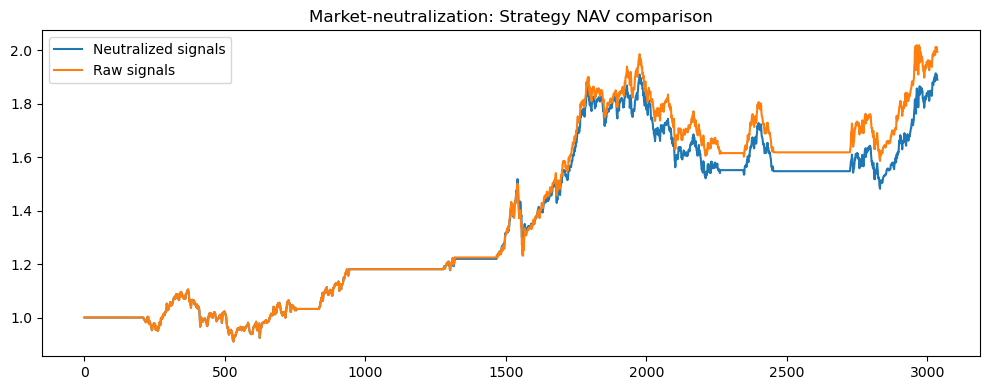

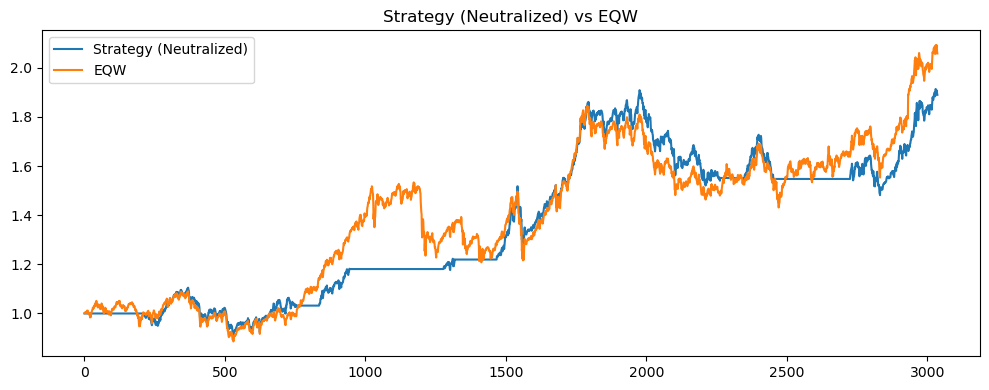

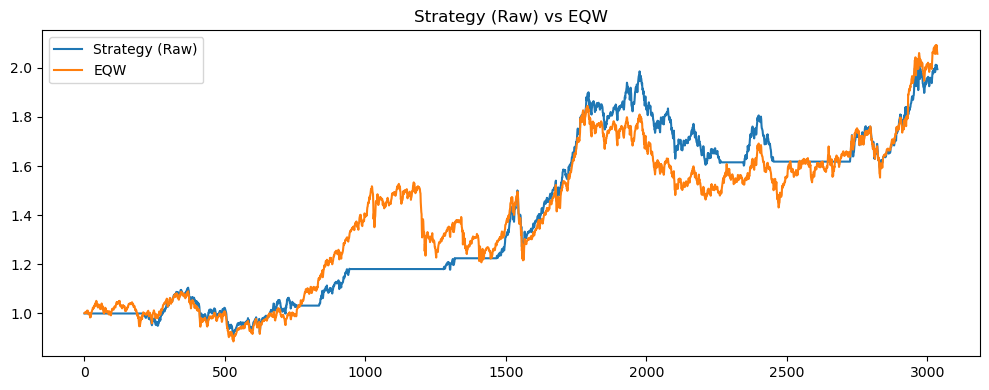

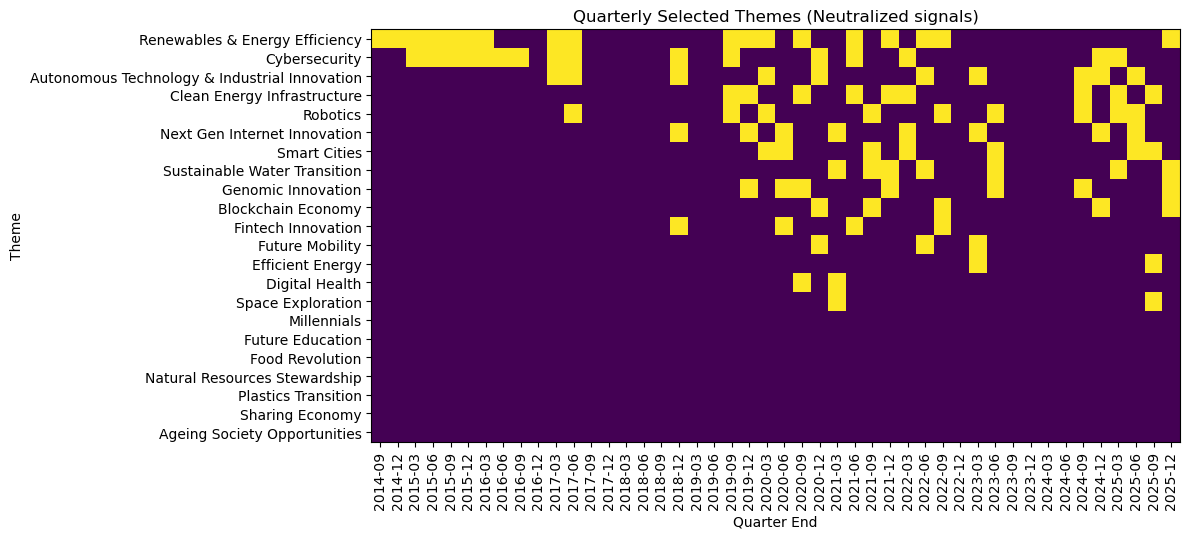

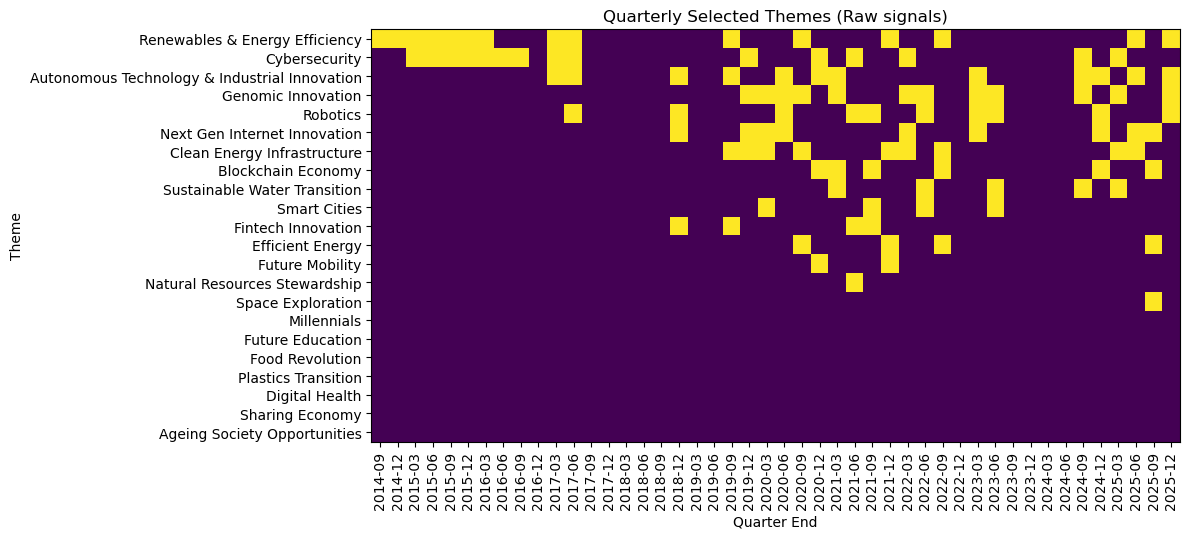

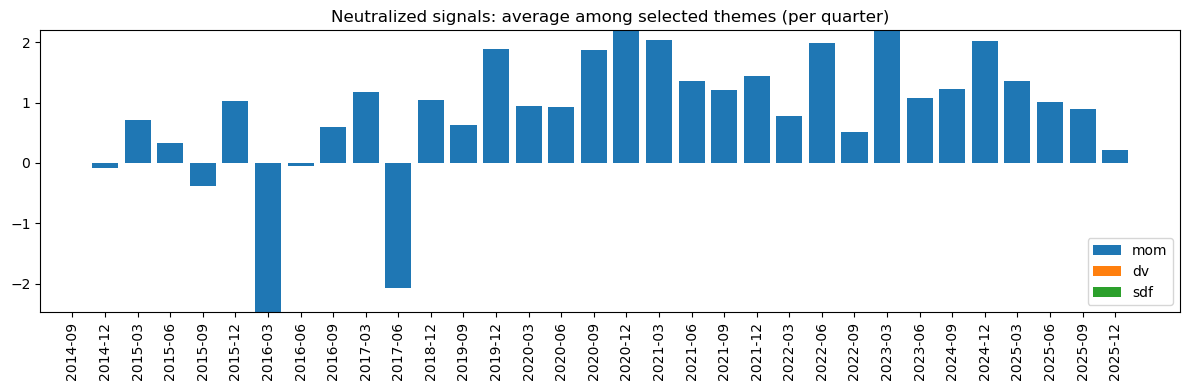

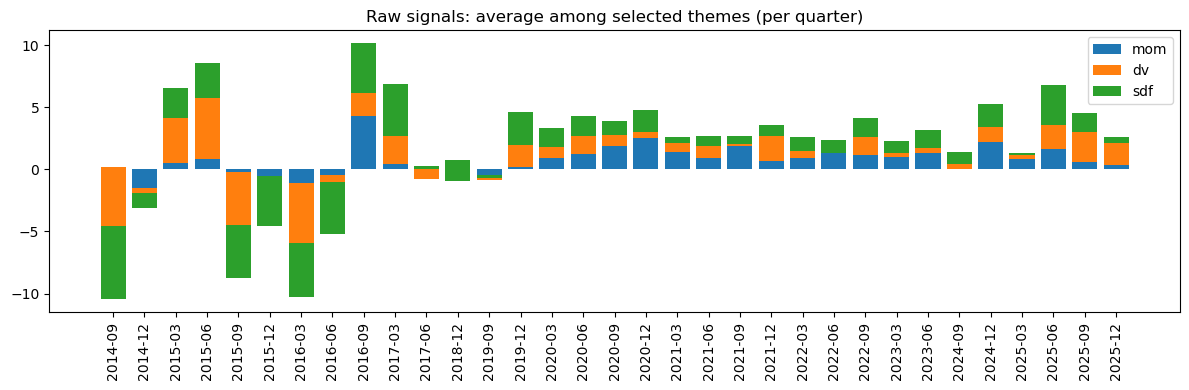

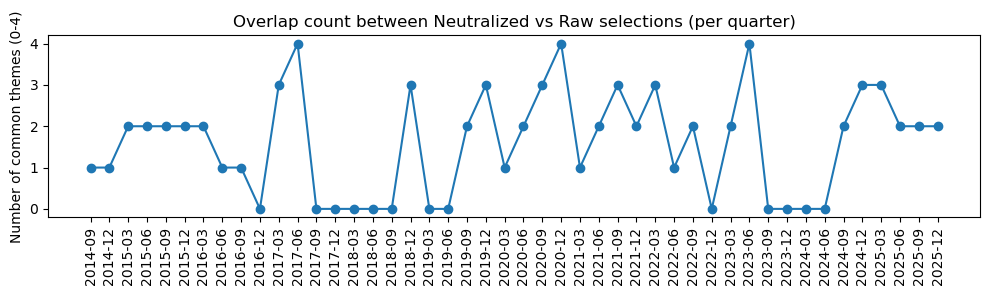

In [ ]:
# ============================================================
# Thematic ETF Rotation (Top-4, Quarterly Rebalance) - FULL +
#   (A) Quarterly selection heatmap
#   (B) Score decomposition (mom / dv / sdf contributions)
#   (C) Market-neutral vs non-neutral comparison
#   (D) MSCI-like "2nd stage optimizer" for weights within selected themes
#   (E) 6M tie-break / fallback 강화 (score -> mom3 -> mom6)
#   (F) ETF factor regression (pseudo M/G/Q exposures) and inject into optimizer alpha
#   (G) NEW (this change ONLY): MSCI-like target risk constraint INSIDE optimizer
#
# Key change:
#   - Add quadratic risk constraint:  w' Σ w <= (kappa * sigma_parent)^2
#   - sigma_parent is approximated as equal-weight portfolio risk of the SELECTED set
#     computed from the same (shrunk) Σ used in optimizer.
#
# Notes:
#   - Keeps your existing "portfolio-level monthly risk targeting" as-is (unchanged).
#   - This patch only adds the MSCI-style "target risk constraint" inside the 2nd stage optimizer.
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ----------------------------
# 0) Universe (your mapping)
# ----------------------------
THEME_ETFS = {
    "Ageing Society Opportunities": ["AGNG"],
    "Autonomous Technology & Industrial Innovation": ["ARKQ", "ROBO"],
    "Digital Health": ["EDOC"],
    "Efficient Energy": ["QCLN"],
    "Fintech Innovation": ["FINX"],
    "Future Education": ["LRNZ"],
    "Future Mobility": ["DRIV"],
    "Genomic Innovation": ["ARKG"],
    "Millennials": ["MILN"],
    "Next Gen Internet Innovation": ["ARKW"],
    "Robotics": ["BOTZ"],
    "Smart Cities": ["KOMP"],
    "Blockchain Economy": ["BLOK"],
    "Clean Energy Infrastructure": ["ICLN"],
    "Cybersecurity": ["HACK"],
    "Food Revolution": ["KROP"],
    "Natural Resources Stewardship": ["WOOD"],
    "Plastics Transition": ["PLST"],
    "Renewables & Energy Efficiency": ["TAN", "FAN"],
    "Sharing Economy": ["GIGE"],
    "Space Exploration": ["ARKX"],
    "Sustainable Water Transition": ["PHO"],
}

# ----------------------------
# 1) Config
# ----------------------------
START = "2014-01-01"
END   = None

TOP_K = 4
REBAL_FREQ = "Q"
EXEC_LAG_DAYS = 1
FEE_BPS = 10.0

LB_3M = 63             # ~3 months trading days
LB_6M = 2 * LB_3M       # ~6 months
MIN_DV_3M = 3_000_000   # $/day

# market neutralization (for SIGNALS only)
MKT_TICKER = "SPY"
BETA_WIN = 63
USE_INTERCEPT = True

# risk targeting (portfolio-level)  [UNCHANGED]
TARGET_VOL_ANN = 0.1
VOL_LOOKBACK = 20
MAX_LEVERAGE = 2.0

# optimizer controls (2nd stage)
USE_WEIGHT_OPTIMIZER = True
W_MAX = 0.25
COV_WIN = 63
COV_SHRINK = 0.10
GAMMA_RISK = 10.0      # used in fallback path or if you want risk penalty in objective
LAMBDA_TURN = 1.0
GD_STEPS = 250
GD_LR = 0.05

# ---- NEW: MSCI-like target risk constraint INSIDE optimizer ----
USE_TARGET_RISK_CONSTRAINT = True
KAPPA_PARENT_RISK = 1.00     # sigma_target = kappa * sigma_parent (<= parent risk if kappa<=1)
MIN_SIGMA_TARGET = 1e-6      # floor to avoid numerical issues

# ---- factor regression (pseudo M/G/Q) ----
USE_STYLE_ALPHA = True
FACTOR_ETFS = {
    "M": "MTUM",   # Momentum
    "G": "IWF",    # Growth (alt: VUG)
    "Q": "QUAL",   # Quality
}
STYLE_WIN = 252          # rolling regression window (trading days)
STYLE_MIN_OBS = 126      # minimum obs to accept betas
STYLE_WEIGHT = 0.50      # weight on style_alpha in optimizer alpha
SCORE_WEIGHT = 1.00      # weight on MMS score in optimizer alpha
STYLE_WINSOR_K = 3.0     # winsorize style_alpha cross-sectionally at month-end
STYLE_TIEBREAK = True    # use style_alpha as extra tie-break in selection

PLOT = True
EPS = 1e-12

# ----------------------------
# 2) Utilities
# ----------------------------
def zscore_cs(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd < 1e-12:
        return s * 0.0
    return (s - mu) / sd

def winsorize(s: pd.Series, k: float = 3.0) -> pd.Series:
    return s.clip(-k, k)

def annualize_vol(x: pd.Series) -> float:
    return float(x.std(ddof=0) * np.sqrt(252))

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def safe_get_loc(index: pd.DatetimeIndex, t: pd.Timestamp, method: str):
    pos = index.get_indexer([t], method=method)[0]
    if pos < 0:
        return None
    return index[pos]

def project_to_capped_simplex(v: np.ndarray, z: float = 1.0, ub: float = 1.0) -> np.ndarray:
    v = np.asarray(v, float).ravel()
    n = v.size
    ub = float(ub)

    if z > n * ub + 1e-12:
        w = np.ones(n) * ub
        return w / w.sum() * z

    lo = v.min() - ub
    hi = v.max()

    for _ in range(80):
        tau = 0.5 * (lo + hi)
        w = np.clip(v - tau, 0.0, ub)
        s = w.sum()
        if s > z:
            lo = tau
        else:
            hi = tau

    w = np.clip(v - 0.5 * (lo + hi), 0.0, ub)
    s = w.sum()
    if s <= 0:
        k = int(np.floor(z / ub))
        w = np.zeros(n)
        if k > 0:
            w[:k] = ub
        rem = z - w.sum()
        if rem > 0 and k < n:
            w[k] = min(ub, rem)
        return w
    return w * (z / s)

def shrink_cov(S: np.ndarray, shrink: float = 0.1, eps: float = 1e-8) -> np.ndarray:
    S = np.asarray(S, float)
    D = np.diag(np.diag(S))
    out = (1.0 - shrink) * S + shrink * D
    out = out + eps * np.eye(out.shape[0])
    return out

def port_sigma2(w: np.ndarray, Sigma: np.ndarray) -> float:
    w = np.asarray(w, float).ravel()
    Sigma = np.asarray(Sigma, float)
    return float(w @ Sigma @ w)

# ----------------------------
# 3) Download data
# ----------------------------
def download_ohlcv(etfs, start=START, end=END):
    data = yf.download(
        tickers=sorted(list(set(etfs))),
        start=start,
        end=end,
        auto_adjust=True,
        progress=False,
        group_by="column",
        threads=True,
    )
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        volume = data["Volume"].copy()
    else:
        close = data[["Close"]].copy()
        close.columns = [etfs[0]]
        volume = data[["Volume"]].copy()
        volume.columns = [etfs[0]]

    close = close.dropna(how="all").ffill()
    volume = volume.reindex(close.index).fillna(0.0)
    return close, volume

# ----------------------------
# 4) Build theme series
# ----------------------------
def build_theme_series(close: pd.DataFrame, volume: pd.DataFrame):
    etf_ret = close.pct_change()

    theme_ret = {}
    theme_dv = {}

    for theme, etfs in THEME_ETFS.items():
        cols = [c for c in etfs if c in close.columns]
        if len(cols) == 0:
            continue

        tr = etf_ret[cols].mean(axis=1, skipna=True)
        dv = (close[cols] * volume[cols]).sum(axis=1, min_count=1)

        theme_ret[theme] = tr
        theme_dv[theme] = dv

    theme_ret = pd.DataFrame(theme_ret).dropna(how="all")
    theme_dv = pd.DataFrame(theme_dv).reindex(theme_ret.index).fillna(0.0)
    return theme_ret, theme_dv

# ----------------------------
# 5) Market neutralization (signals only)
# ----------------------------
def neutralize_by_market(theme_ret: pd.DataFrame, mkt_ret: pd.Series, win: int = 63, use_intercept: bool = True) -> pd.DataFrame:
    idx = theme_ret.index
    m = mkt_ret.reindex(idx).fillna(0.0)

    if use_intercept:
        m_dm = m - m.rolling(win).mean()
        var_m = m_dm.rolling(win).var(ddof=0)
    else:
        m_dm = m
        var_m = (m * m).rolling(win).mean()

    out = pd.DataFrame(index=idx, columns=theme_ret.columns, dtype=float)

    for c in theme_ret.columns:
        r = theme_ret[c].fillna(0.0)
        if use_intercept:
            r_dm = r - r.rolling(win).mean()
            cov = (r_dm * m_dm).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            alpha = r.rolling(win).mean() - beta * m.rolling(win).mean()
            resid = r - alpha - beta * m
        else:
            cov = (r * m).rolling(win).mean()
            beta = cov / (var_m + 1e-12)
            resid = r - beta * m
        out[c] = resid

    return out

# ----------------------------
# 6) MMS-like scores + decomposition + mom3/mom6 levels
# ----------------------------
def compute_month_end_scores_with_decomp_and_mom_levels(
    ret_for_signals: pd.DataFrame,
    theme_dv: pd.DataFrame,
    lb_3m: int = LB_3M,
    eps: float = EPS
):
    idx = ret_for_signals.index
    dv = theme_dv.reindex(idx).fillna(0.0)
    sdf = np.sign(ret_for_signals).fillna(0.0) * dv

    month_ends = ret_for_signals.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    rows_score, rows_mom3, rows_mom6, rows_comp = [], [], [], []

    for t in month_ends:
        loc = idx.get_loc(t)
        if loc < 2 * lb_3m + 5:
            continue

        w0 = slice(loc - lb_3m + 1, loc + 1)                 # last 3m
        w1 = slice(loc - 2 * lb_3m + 1, loc - lb_3m + 1)     # prev 3m
        w6 = slice(loc - 2 * lb_3m + 1, loc + 1)             # last 6m

        # mom levels (risk-adjusted)
        R0 = (1.0 + ret_for_signals.iloc[w0]).prod(axis=0) - 1.0
        S0 = ret_for_signals.iloc[w0].std(axis=0, ddof=0)
        mom3 = R0 / (S0 + eps)

        R6 = (1.0 + ret_for_signals.iloc[w6]).prod(axis=0) - 1.0
        S6 = ret_for_signals.iloc[w6].std(axis=0, ddof=0)
        mom6 = R6 / (S6 + eps)

        R1 = (1.0 + ret_for_signals.iloc[w1]).prod(axis=0) - 1.0
        S1 = ret_for_signals.iloc[w1].std(axis=0, ddof=0)
        mom1 = R1 / (S1 + eps)

        dv0 = dv.iloc[w0].mean(axis=0)
        dv1 = dv.iloc[w1].mean(axis=0)

        sdf0 = sdf.iloc[w0].mean(axis=0)
        sdf1 = sdf.iloc[w1].mean(axis=0)

        def change_abs_pct(x0, x1):
            d_abs = x0 - x1
            d_pct = (x0 - x1) / (np.abs(x1) + eps)
            return d_abs, d_pct

        mom_abs, mom_pct = change_abs_pct(mom3, mom1)
        dv_abs,  dv_pct  = change_abs_pct(dv0, dv1)
        sdf_abs, sdf_pct = change_abs_pct(sdf0, sdf1)

        # cs-z each
        z_mom_abs = zscore_cs(mom_abs)
        z_mom_pct = zscore_cs(mom_pct)
        z_dv_abs  = zscore_cs(dv_abs)
        z_dv_pct  = zscore_cs(dv_pct)
        z_sdf_abs = zscore_cs(sdf_abs)
        z_sdf_pct = zscore_cs(sdf_pct)

        # contributions
        c_mom = z_mom_abs + z_mom_pct
        c_dv  = z_dv_abs  + z_dv_pct
        c_sdf = z_sdf_abs + z_sdf_pct

        raw = c_mom + c_dv + c_sdf
        score = zscore_cs(raw)
        score = winsorize(score, 3.0).round(1)

        rows_score.append(score.rename(t))
        rows_mom3.append(mom3.rename(t))
        rows_mom6.append(mom6.rename(t))

        comp = pd.DataFrame({
            "mom": c_mom,
            "dv": c_dv,
            "sdf": c_sdf,
            "raw_sum": raw,
            "score_final": score
        })
        comp.index.name = "theme"
        comp["date"] = t
        rows_comp.append(comp.reset_index())

    score_m = pd.DataFrame(rows_score).sort_index()
    mom3_m  = pd.DataFrame(rows_mom3).sort_index()
    mom6_m  = pd.DataFrame(rows_mom6).sort_index()
    comp_m  = pd.concat(rows_comp, axis=0).set_index(["date", "theme"]).sort_index()
    return score_m, mom3_m, mom6_m, comp_m

# ----------------------------
# 7) Style alpha via factor ETF regression (pseudo M/G/Q exposures)
# ----------------------------
def rolling_factor_betas_month_end(
    y_ret: pd.DataFrame,          # theme returns (daily)
    X_ret: pd.DataFrame,          # factor ETF returns (daily), columns = [M,G,Q]
    win: int = 252,
    min_obs: int = 126
):
    idx = y_ret.index.intersection(X_ret.index)
    Y = y_ret.reindex(idx)
    X = X_ret.reindex(idx)

    month_ends = Y.resample("M").last().index
    month_ends = pd.DatetimeIndex([d for d in month_ends if d in idx])

    betas_rows = []

    X_cols = list(X.columns)
    k = len(X_cols)
    if k < 2:
        betas_m = pd.DataFrame(columns=["beta_M", "beta_G", "beta_Q"])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    for t in month_ends:
        loc = idx.get_loc(t)
        start = loc - win + 1
        if start < 0:
            continue
        Xw = X.iloc[start:loc+1].copy()
        Xmat = np.column_stack([np.ones(len(Xw))] + [Xw[c].values for c in X_cols])

        for theme in Y.columns:
            yw = Y[theme].iloc[start:loc+1].values
            mask = np.isfinite(yw)
            for c in X_cols:
                mask = mask & np.isfinite(Xw[c].values)
            if mask.sum() < min_obs:
                continue
            A = Xmat[mask]
            b = yw[mask]
            coef, *_ = np.linalg.lstsq(A, b, rcond=None)
            betas = coef[1:]
            row = {"date": t, "theme": theme}
            for j, c in enumerate(X_cols):
                row[f"beta_{c}"] = float(betas[j])
            betas_rows.append(row)

    if len(betas_rows) == 0:
        betas_m = pd.DataFrame(columns=[f"beta_{c}" for c in X_cols])
        style_alpha_m = pd.DataFrame(index=[], columns=Y.columns)
        return betas_m, style_alpha_m

    betas_m = pd.DataFrame(betas_rows).set_index(["date","theme"]).sort_index()

    style_alpha_rows = []
    for d in betas_m.index.get_level_values(0).unique().sort_values():
        sub = betas_m.loc[d]
        zcols = []
        for c in [f"beta_{x}" for x in X_cols]:
            zc = zscore_cs(sub[c])
            zcols.append(zc)
        zmat = pd.concat(zcols, axis=1)
        zmat.columns = X_cols
        a = zmat.mean(axis=1)
        a = winsorize(a, STYLE_WINSOR_K)
        style_alpha_rows.append(a.rename(d))

    style_alpha_m = pd.DataFrame(style_alpha_rows).sort_index()
    style_alpha_m = style_alpha_m.reindex(columns=Y.columns)
    return betas_m, style_alpha_m

# ----------------------------
# 8) Optimizer within selected themes (2nd stage) + MSCI-like risk constraint
# ----------------------------
def optimize_weights_within_selected(
    score_vec: pd.Series,
    cov_mat: np.ndarray,
    w_prev: np.ndarray,
    w_max: float = 0.25,
    gamma_risk: float = 10.0,
    lambda_turn: float = 1.0,
    use_scipy: bool = True,
    # ---- NEW ----
    use_target_risk_constraint: bool = True,
    sigma_target2: float = None
) -> np.ndarray:
    """
    Solve (approx MSCI-like):
        maximize  score' w  - lambda_turn * ||w - w_prev||^2
        s.t.      sum(w)=1, 0<=w<=w_max
                  w' Σ w <= sigma_target^2    (optional, MSCI-like target risk constraint)

    Fallback:
        if constrained solve fails -> revert to your original penalized-risk objective.
    """
    s = np.asarray(score_vec.values, float)
    n = s.size
    Sigma = np.asarray(cov_mat, float)
    w_prev = np.asarray(w_prev, float).ravel()
    if w_prev.size != n:
        w_prev = np.ones(n) / n

    w0 = project_to_capped_simplex(w_prev, z=1.0, ub=w_max)

    # sanitize sigma_target2
    if (not use_target_risk_constraint) or (sigma_target2 is None) or (not np.isfinite(sigma_target2)):
        use_target_risk_constraint = False
    else:
        sigma_target2 = float(max(sigma_target2, MIN_SIGMA_TARGET**2))

    if use_scipy:
        try:
            from scipy.optimize import minimize

            # --- constrained objective (NO explicit risk penalty; risk via constraint) ---
            def obj_constrained(w):
                w = np.asarray(w)
                ret_term = -float(np.dot(s, w))  # maximize score
                turn_term = float(lambda_turn * np.sum((w - w_prev) ** 2))
                return ret_term + turn_term

            def grad_constrained(w):
                w = np.asarray(w)
                return (-s + 2.0 * lambda_turn * (w - w_prev))

            # equality constraint: sum(w)=1
            cons = [
                {"type": "eq",
                 "fun": lambda w: np.sum(w) - 1.0,
                 "jac": lambda w: np.ones_like(w)}
            ]

            # inequality: sigma_target2 - w' Σ w >= 0
            if use_target_risk_constraint:
                cons.append({
                    "type": "ineq",
                    "fun": lambda w: sigma_target2 - float(np.asarray(w) @ Sigma @ np.asarray(w)),
                    "jac": lambda w: -2.0 * (Sigma @ np.asarray(w))
                })

            bnds = [(0.0, w_max) for _ in range(n)]

            res = minimize(
                obj_constrained, w0, jac=grad_constrained,
                method="SLSQP",
                bounds=bnds, constraints=cons,
                options={"maxiter": 300, "ftol": 1e-12, "disp": False}
            )
            if res.success and np.all(np.isfinite(res.x)):
                w = np.asarray(res.x, float)
                w = project_to_capped_simplex(w, z=1.0, ub=w_max)
                # if constraint was intended, quickly check violation; if big -> fallback
                if use_target_risk_constraint:
                    v = float(w @ Sigma @ w) - sigma_target2
                    if v > 1e-8:
                        raise RuntimeError("risk constraint violated after projection")
                return w

        except Exception:
            # fall through to penalized-risk fallback
            pass

    # ---------- fallback: your original penalized objective ----------
    # Here we DO include risk penalty since constraint path failed.
    w = w0.copy()
    for _ in range(GD_STEPS):
        g = (-s + 2.0 * gamma_risk * (Sigma @ w) + 2.0 * lambda_turn * (w - w_prev))
        w = w - GD_LR * g
        w = project_to_capped_simplex(w, z=1.0, ub=w_max)
    return w

def compute_cov_at_date(theme_ret_trade: pd.DataFrame, t: pd.Timestamp, win: int = 63):
    idx = theme_ret_trade.index
    t0 = safe_get_loc(idx, t, method="ffill")
    if t0 is None:
        return None
    loc = idx.get_loc(t0)
    if loc < win:
        return None
    X = theme_ret_trade.iloc[loc - win + 1: loc + 1]
    X = X.dropna(axis=1, how="all").fillna(0.0)
    if X.shape[1] < 2:
        return None
    return X.cov(ddof=0)

# ----------------------------
# 9) Liquidity filter + quarterly top-k + fallback + optimizer (+ style alpha injection)
# ----------------------------
def build_quarterly_weights(
    score_m,
    mom3_m,
    mom6_m,
    style_alpha_m,          # can be None
    theme_dv,
    theme_ret_trade,
    top_k=TOP_K,
    lb_3m=LB_3M,
    min_dv_3m=MIN_DV_3M,
    use_optimizer: bool = True,
    w_max: float = W_MAX,
    cov_win: int = COV_WIN,
    cov_shrink: float = COV_SHRINK,
    gamma_risk: float = GAMMA_RISK,
    lambda_turn: float = LAMBDA_TURN
):
    q_end = score_m.resample(REBAL_FREQ).last().index
    q_score = score_m.reindex(q_end)
    q_mom3  = mom3_m.reindex(q_end)
    q_mom6  = mom6_m.reindex(q_end)
    q_style = None if style_alpha_m is None else style_alpha_m.reindex(q_end)

    # 3m avg dollar volume at quarter ends
    dv3m_at_q = {}
    idx = theme_dv.index
    for t in q_end:
        t0 = safe_get_loc(idx, t, method="ffill")
        if t0 is None:
            dv3m = pd.Series(np.nan, index=theme_dv.columns)
        else:
            loc = idx.get_loc(t0)
            if loc < lb_3m:
                dv3m = pd.Series(np.nan, index=theme_dv.columns)
            else:
                dv3m = theme_dv.iloc[loc - lb_3m + 1: loc + 1].mean(axis=0)
        dv3m_at_q[t] = dv3m
    dv3m_at_q = pd.DataFrame(dv3m_at_q).T.reindex(q_end)

    Wq = pd.DataFrame(0.0, index=q_end, columns=score_m.columns)
    w_prev_full = np.zeros(Wq.shape[1], dtype=float)

    for t in q_end:
        s = q_score.loc[t].copy()
        m3 = q_mom3.loc[t].copy()
        m6 = q_mom6.loc[t].copy()
        st = None if q_style is None else q_style.loc[t].copy()

        dv_ok = (dv3m_at_q.loc[t] >= min_dv_3m)
        s[~dv_ok] = np.nan
        m3[~dv_ok] = np.nan
        m6[~dv_ok] = np.nan
        if st is not None:
            st[~dv_ok] = np.nan

        rank = pd.DataFrame({"score": s, "mom3": m3, "mom6": m6})
        if st is not None and STYLE_TIEBREAK:
            rank["style"] = st
        else:
            rank["style"] = np.nan

        # ---- Step1: pick top_k with tie-break
        # score -> (style) -> mom3 -> mom6
        pick = []
        rank_score = rank[rank["score"].notna()].copy()
        if len(rank_score) > 0:
            sort_cols = ["score"]
            asc = [False]
            if STYLE_TIEBREAK and st is not None:
                sort_cols += ["style"]
                asc += [False]
            sort_cols += ["mom3", "mom6"]
            asc += [False, False]

            rank_score = rank_score.sort_values(sort_cols, ascending=asc, kind="mergesort")
            pick = list(rank_score.head(top_k).index)

        # ---- Step2: fallback fill if < top_k
        if len(pick) < top_k:
            rank_mom = rank[rank["mom3"].notna()].copy()
            sort_cols = ["mom3", "mom6"]
            asc = [False, False]
            if STYLE_TIEBREAK and st is not None:
                sort_cols = ["mom3", "style", "mom6"]
                asc = [False, False, False]
            rank_mom = rank_mom.sort_values(sort_cols, ascending=asc, kind="mergesort")
            for name in rank_mom.index:
                if name not in pick:
                    pick.append(name)
                if len(pick) == top_k:
                    break

        if len(pick) == 0:
            continue

        # ---- Step3: assign weights
        if (not use_optimizer) or (len(pick) == 1):
            Wq.loc[t, pick] = 1.0 / len(pick)
        else:
            # alpha = SCORE_WEIGHT * score + STYLE_WEIGHT * style_alpha
            score_vec = s.reindex(pick)

            # fill NaN score among picked via mom fallback
            if score_vec.isna().any():
                m3p = m3.reindex(pick).fillna(0.0)
                m6p = m6.reindex(pick).fillna(0.0)
                alpha_fill = zscore_cs(m3p) + 0.25 * zscore_cs(m6p)
                score_vec = score_vec.fillna(alpha_fill)

            if USE_STYLE_ALPHA and (st is not None):
                style_vec = st.reindex(pick).fillna(0.0)
            else:
                style_vec = pd.Series(0.0, index=pick)

            alpha_vec = SCORE_WEIGHT * score_vec + STYLE_WEIGHT * style_vec

            # covariance from tradable theme returns
            S = compute_cov_at_date(theme_ret_trade[pick], t, win=cov_win)
            if S is None:
                Wq.loc[t, pick] = 1.0 / len(pick)
            else:
                Sigma = shrink_cov(S.values, shrink=cov_shrink, eps=1e-8)

                prev_series = pd.Series(w_prev_full, index=Wq.columns)
                w_prev_sub = prev_series.reindex(pick).values

                # ---- NEW: compute "parent risk" and "target risk" (MSCI-like) ----
                # Approximate parent risk as equal-weight portfolio risk over the selected set.
                nsel = len(pick)
                w_parent = np.ones(nsel) / nsel
                sigma_parent2 = port_sigma2(w_parent, Sigma)

                # target risk = kappa * parent risk  (variance scales by kappa^2)
                if (USE_TARGET_RISK_CONSTRAINT and np.isfinite(sigma_parent2) and sigma_parent2 > 0):
                    sigma_target2 = (max(KAPPA_PARENT_RISK, 0.0) ** 2) * sigma_parent2
                    sigma_target2 = float(max(sigma_target2, MIN_SIGMA_TARGET**2))
                    use_trc = True
                else:
                    sigma_target2 = None
                    use_trc = False

                w_opt = optimize_weights_within_selected(
                    score_vec=alpha_vec,
                    cov_mat=Sigma,
                    w_prev=w_prev_sub,
                    w_max=w_max,
                    gamma_risk=gamma_risk,
                    lambda_turn=lambda_turn,
                    use_scipy=True,
                    # ---- NEW ----
                    use_target_risk_constraint=use_trc,
                    sigma_target2=sigma_target2
                )
                Wq.loc[t, pick] = w_opt

        w_prev_full = Wq.loc[t].values.copy()

    return Wq

# ----------------------------
# 10) Expand weights + backtest + risk targeting (UNCHANGED)
# ----------------------------
def expand_weights_daily(Wq, daily_index, exec_lag_days=EXEC_LAG_DAYS):
    Wd = pd.DataFrame(index=daily_index, columns=Wq.columns, data=np.nan)
    for t in Wq.index:
        t0 = safe_get_loc(daily_index, t, method="bfill")
        if t0 is None:
            continue
        loc = daily_index.get_loc(t0)
        apply_loc = min(loc + exec_lag_days, len(daily_index) - 1)
        Wd.iloc[apply_loc] = Wq.loc[t].values
    return Wd.ffill().fillna(0.0)

def apply_monthly_risk_targeting(port_gross_ret, turnover, fee_bps,
                                target_vol_ann=TARGET_VOL_ANN, vol_lookback=VOL_LOOKBACK, max_leverage=MAX_LEVERAGE):
    fee = fee_bps * 1e-4
    cost = turnover * fee

    idx = port_gross_ret.index
    month_starts = idx.to_series().groupby(idx.to_period("M")).head(1).index

    lev = pd.Series(index=idx, dtype=float)
    current_lev = 1.0

    for d in idx:
        if d in month_starts:
            loc = idx.get_loc(d)
            end = loc - 1
            start = end - vol_lookback + 1
            if start >= 0:
                window = port_gross_ret.iloc[start:end+1]
                rv = annualize_vol(window)
                if rv > 1e-12:
                    current_lev = float(np.clip(target_vol_ann / rv, 0.0, max_leverage))
                else:
                    current_lev = 0.0
            else:
                current_lev = 1.0
        lev.loc[d] = current_lev

    net = lev * port_gross_ret - lev * cost
    out = pd.DataFrame({
        "gross_ret": port_gross_ret,
        "turnover": turnover,
        "cost": cost,
        "leverage": lev,
        "net_ret": net,
        "nav": (1.0 + net).cumprod()
    }, index=idx)
    return out

def backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS):
    rets = theme_ret_trade.dropna(how="all")
    Wd = expand_weights_daily(Wq, rets.index, exec_lag_days=exec_lag_days).reindex(rets.index).fillna(0.0)
    port_gross = (Wd * rets).sum(axis=1)
    turnover = Wd.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(port_gross, turnover, fee_bps)
    return bt, Wd

def benchmark_equal_weight(theme_ret_trade):
    rets = theme_ret_trade.dropna(how="all")
    n = rets.shape[1]
    W = pd.DataFrame(1.0 / n, index=rets.index, columns=rets.columns)
    gross = (W * rets).sum(axis=1)
    turnover = W.diff().abs().sum(axis=1).fillna(0.0)
    bt = apply_monthly_risk_targeting(gross, turnover, fee_bps=0.0)
    return bt

# ----------------------------
# 11) Plotting add-ons
# ----------------------------
def plot_selection_heatmap(Wq, title="Quarterly Selected Themes (Top-4)"):
    sel = (Wq > 0).astype(int)
    order = sel.sum(axis=0).sort_values(ascending=False).index
    sel = sel[order]
    fig, ax = plt.subplots(figsize=(12, max(4, 0.25 * sel.shape[1])))
    ax.imshow(sel.T.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_yticks(np.arange(sel.shape[1]))
    ax.set_yticklabels(sel.columns)
    ax.set_xticks(np.arange(sel.shape[0]))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in sel.index], rotation=90)
    ax.set_xlabel("Quarter End")
    ax.set_ylabel("Theme")
    plt.tight_layout()
    plt.show()

def plot_nav_comparison(bt_a, bt_b, labels=("A", "B"), title="NAV Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(bt_a["nav"].values, label=labels[0])
    plt.plot(bt_b["nav"].values, label=labels[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_decomposition_for_quarters(comp_m, Wq, mode="avg_selected", title_prefix="Score Decomposition"):
    q_end = Wq.index
    comp_dates = comp_m.index.get_level_values(0).unique().sort_values()
    out_rows = []

    for t in q_end:
        if len(comp_dates) == 0:
            break
        i = comp_dates.get_indexer([t], method="ffill")[0]
        if i < 0:
            continue
        t_comp = comp_dates[i]

        selected = list(Wq.columns[Wq.loc[t] > 0])
        if len(selected) == 0:
            continue

        sub = comp_m.loc[(t_comp, selected), ["mom","dv","sdf"]].copy()

        if mode == "avg_selected":
            row = sub.mean(axis=0)
            row["date"] = t
            out_rows.append(row)
        else:
            for th in selected:
                row = sub.loc[th]
                row["date"] = t
                row["theme"] = th
                out_rows.append(row)

    if len(out_rows) == 0:
        print("No decomposition rows to plot.")
        return

    df = pd.DataFrame(out_rows)

    if mode == "avg_selected":
        df = df.set_index("date").sort_index()
        x = np.arange(len(df.index))
        plt.figure(figsize=(12,4))
        bottom = np.zeros(len(x))
        for col in ["mom","dv","sdf"]:
            plt.bar(x, df[col].values, bottom=bottom, label=col)
            bottom = bottom + df[col].values
        plt.xticks(x, [d.strftime("%Y-%m") for d in df.index], rotation=90)
        plt.title(f"{title_prefix}: average among selected themes (per quarter)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("mode='all_selected' is verbose; use 'avg_selected' unless needed.")
        return df.sort_values(["date","theme"])

# ----------------------------
# 12) Pipeline runner (with/without neutralization)
# ----------------------------
def run_pipeline(use_neutralization: bool):
    theme_etfs = sorted({e for lst in THEME_ETFS.values() for e in lst})
    factor_etfs = sorted(set(FACTOR_ETFS.values())) if USE_STYLE_ALPHA else []
    all_etfs = sorted(set(theme_etfs + factor_etfs + [MKT_TICKER]))

    close, volume = download_ohlcv(all_etfs, start=START, end=END)

    # market
    mkt_close = close[[MKT_TICKER]].dropna()
    mkt_ret = mkt_close[MKT_TICKER].pct_change()

    # themes
    close_theme = close.reindex(columns=theme_etfs).dropna(how="all")
    vol_theme   = volume.reindex(columns=theme_etfs).fillna(0.0)
    theme_ret_trade, theme_dv = build_theme_series(close_theme, vol_theme)

    # signals returns (neutralized or raw)
    if use_neutralization:
        ret_for_signals = neutralize_by_market(theme_ret_trade, mkt_ret, win=BETA_WIN, use_intercept=USE_INTERCEPT)
    else:
        ret_for_signals = theme_ret_trade.copy()

    # MMS-like scores + mom3/mom6
    score_m, mom3_m, mom6_m, comp_m = compute_month_end_scores_with_decomp_and_mom_levels(
        ret_for_signals, theme_dv, lb_3m=LB_3M
    )

    # Style alpha
    style_alpha_m = None
    betas_m = None
    if USE_STYLE_ALPHA:
        fac_cols = [FACTOR_ETFS[k] for k in ["M","G","Q"] if k in FACTOR_ETFS]
        fac_cols_avail = [c for c in fac_cols if c in close.columns]
        if len(fac_cols_avail) >= 2:
            fac_close = close[fac_cols_avail].dropna(how="all").ffill()
            fac_ret = fac_close.pct_change()
            rename_map = {}
            for k, tkr in FACTOR_ETFS.items():
                if tkr in fac_ret.columns:
                    rename_map[tkr] = k
            fac_ret = fac_ret.rename(columns=rename_map)
            fac_ret = fac_ret[[c for c in ["M","G","Q"] if c in fac_ret.columns]]
            betas_m, style_alpha_m = rolling_factor_betas_month_end(
                y_ret=theme_ret_trade,
                X_ret=fac_ret,
                win=STYLE_WIN,
                min_obs=STYLE_MIN_OBS
            )
        else:
            style_alpha_m = None
            betas_m = None

    # Quarterly weights (selection + optimizer + NEW risk constraint inside optimizer)
    Wq = build_quarterly_weights(
        score_m=score_m,
        mom3_m=mom3_m,
        mom6_m=mom6_m,
        style_alpha_m=style_alpha_m,
        theme_dv=theme_dv,
        theme_ret_trade=theme_ret_trade,
        top_k=TOP_K,
        lb_3m=LB_3M,
        min_dv_3m=MIN_DV_3M,
        use_optimizer=USE_WEIGHT_OPTIMIZER,
        w_max=W_MAX,
        cov_win=COV_WIN,
        cov_shrink=COV_SHRINK,
        gamma_risk=GAMMA_RISK,
        lambda_turn=LAMBDA_TURN
    )

    bt, Wd = backtest_strategy(theme_ret_trade, Wq, exec_lag_days=EXEC_LAG_DAYS, fee_bps=FEE_BPS)
    bt_eqw = benchmark_equal_weight(theme_ret_trade)

    return {
        "theme_ret_trade": theme_ret_trade,
        "ret_for_signals": ret_for_signals,
        "theme_dv": theme_dv,
        "score_m": score_m,
        "mom3_m": mom3_m,
        "mom6_m": mom6_m,
        "comp_m": comp_m,
        "betas_m": betas_m,
        "style_alpha_m": style_alpha_m,
        "Wq": Wq,
        "Wd": Wd,
        "bt": bt,
        "bt_eqw": bt_eqw,
    }

def summarize(bt_df, name):
    r = bt_df["net_ret"].dropna()
    ann_ret = float((1.0 + r).prod() ** (252.0 / len(r)) - 1.0)
    ann_vol = annualize_vol(r)
    sharpe = ann_ret / (ann_vol + 1e-12)
    mdd = max_drawdown(bt_df["nav"])
    avg_turn = float(bt_df["turnover"].mean())
    return pd.Series({
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_dd": mdd,
        "avg_turnover": avg_turn,
        "final_nav": float(bt_df["nav"].iloc[-1])
    }, name=name)

# ----------------------------
# 13) Execute
# ----------------------------
if __name__ == "__main__":
    out_neut = run_pipeline(use_neutralization=True)
    out_raw  = run_pipeline(use_neutralization=False)

    summary = pd.concat([
        summarize(out_neut["bt"], "Strategy (Neutralized signals; optimized weights; TRC)"),
        summarize(out_raw["bt"],  "Strategy (Raw signals; optimized weights; TRC)"),
        summarize(out_neut["bt_eqw"], "EQW (All themes)")
    ], axis=1).T

    print("\n=== Summary ===")
    print(summary)

    if USE_STYLE_ALPHA:
        if out_raw["style_alpha_m"] is None or out_raw["style_alpha_m"].dropna(how="all").empty:
            print("\n[WARN] style_alpha_m is empty (factor ETFs missing or insufficient data).")
        else:
            print("\n[INFO] style_alpha_m computed. Example (last 3 rows):")
            print(out_raw["style_alpha_m"].tail(3))

    if PLOT:
        plot_nav_comparison(
            out_neut["bt"], out_raw["bt"],
            labels=("Neutralized signals", "Raw signals"),
            title="Market-neutralization: Strategy NAV comparison"
        )

        plot_nav_comparison(
            out_neut["bt"], out_neut["bt_eqw"],
            labels=("Strategy (Neutralized)", "EQW"),
            title="Strategy (Neutralized) vs EQW"
        )
        plot_nav_comparison(
            out_raw["bt"], out_raw["bt_eqw"],
            labels=("Strategy (Raw)", "EQW"),
            title="Strategy (Raw) vs EQW"
        )

        plot_selection_heatmap(out_neut["Wq"], title="Quarterly Selected Themes (Neutralized signals)")
        plot_selection_heatmap(out_raw["Wq"],  title="Quarterly Selected Themes (Raw signals)")

        plot_score_decomposition_for_quarters(out_neut["comp_m"], out_neut["Wq"], mode="avg_selected",
                                             title_prefix="Neutralized signals")
        plot_score_decomposition_for_quarters(out_raw["comp_m"], out_raw["Wq"], mode="avg_selected",
                                             title_prefix="Raw signals")

        sel_neut = (out_neut["Wq"] > 0).astype(int)
        sel_raw  = (out_raw["Wq"] > 0).astype(int)
        common = (sel_neut & sel_raw).sum(axis=1)
        plt.figure(figsize=(10,3))
        plt.plot(common.values, marker="o")
        plt.title("Overlap count between Neutralized vs Raw selections (per quarter)")
        plt.xticks(np.arange(len(common.index)), [d.strftime("%Y-%m") for d in common.index], rotation=90)
        plt.ylabel("Number of common themes (0-4)")
        plt.tight_layout()
        plt.show()
